In [1]:
#80
#途中まで50と同じ

#データダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-01-30 16:12:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  14.8MB/s    in 1.9s    

2022-01-30 16:12:29 (14.8 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']) #具体例からこのように分ける

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']] #publisherが”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”であるものの、そのカテゴリ名と記事見出しを抽出 isin https://vector-ium.com/pandas-isin/  loc(列ラベル) https://note.nkmk.me/python-pandas-at-iat-loc-iloc/

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['CATEGORY']) #学習データ80%とその他20%に分ける train_test_splitについて https://qiita.com/KyleKatarn/items/2afa6787f04f28e2cd2d
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=42, stratify=valid_test['CATEGORY']) #その他に分けられたデータを半分ずつ検証データと評価データに分類(全体から見ると10%,10%)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


# データの保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [41]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id.values()))}\n')
print('---頻度上位20語---')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]} 出現回数:{d[word2id[key]-1][1]}')

ID数: 9374

---頻度上位20語---
to: 1 出現回数:2141
s: 2 出現回数:1907
in: 3 出現回数:1423
UPDATE: 4 出現回数:1074
on: 5 出現回数:1065
as: 6 出現回数:1018
US: 7 出現回数:998
The: 8 出現回数:975
of: 9 出現回数:967
for: 10 出現回数:942
1: 11 出現回数:860
To: 12 出現回数:737
2: 13 出現回数:678
the: 14 出現回数:611
and: 15 出現回数:577
In: 16 出現回数:509
Of: 17 出現回数:478
at: 18 出現回数:466
a: 19 出現回数:449
A: 20 出現回数:442


### defaultdictについて
https://qiita.com/xza/items/

In [42]:
def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]

In [43]:
#確認
text = train.iloc[0, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: UPDATE 1-Sandwich chain Quiznos files for bankruptcy protection
ID列: [4, 11, 0, 1717, 0, 790, 10, 1238, 3532]


In [44]:
#81
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out
    
  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
    return hidden

In [45]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer(text)

    return {
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

In [46]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 195,  557, 1078,  389, 3022,   87,  288,  605,   94,   41, 2657,  214])
  labels: 0


In [47]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# デバイスの指定
device = torch.device("cpu")

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.5103, 0.1156, 0.1398, 0.2344]], grad_fn=<SoftmaxBackward>)
tensor([[0.3001, 0.3704, 0.1276, 0.2018]], grad_fn=<SoftmaxBackward>)
tensor([[0.2712, 0.1824, 0.2419, 0.3046]], grad_fn=<SoftmaxBackward>)
tensor([[0.1443, 0.4161, 0.2758, 0.1638]], grad_fn=<SoftmaxBackward>)
tensor([[0.1837, 0.2154, 0.2695, 0.3314]], grad_fn=<SoftmaxBackward>)
tensor([[0.3584, 0.1119, 0.2466, 0.2831]], grad_fn=<SoftmaxBackward>)
tensor([[0.2007, 0.2401, 0.2427, 0.3166]], grad_fn=<SoftmaxBackward>)
tensor([[0.2526, 0.1897, 0.4248, 0.1329]], grad_fn=<SoftmaxBackward>)
tensor([[0.3262, 0.3272, 0.1346, 0.2119]], grad_fn=<SoftmaxBackward>)
tensor([[0.2603, 0.2140, 0.2783, 0.2474]], grad_fn=<SoftmaxBackward>)


In [48]:
#82
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
        
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [10]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [14]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device("cpu")

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

epoch: 1, loss_train: 1.1152, accuracy_train: 0.5115, loss_valid: 1.1322, accuracy_valid: 0.4910, 65.0134sec
epoch: 2, loss_train: 1.0356, accuracy_train: 0.5748, loss_valid: 1.0831, accuracy_valid: 0.5352, 64.0373sec
epoch: 3, loss_train: 0.9097, accuracy_train: 0.6604, loss_valid: 0.9974, accuracy_valid: 0.6033, 65.0825sec
epoch: 4, loss_train: 0.7619, accuracy_train: 0.7308, loss_valid: 0.8843, accuracy_valid: 0.6894, 65.3206sec
epoch: 5, loss_train: 0.6684, accuracy_train: 0.7639, loss_valid: 0.8272, accuracy_valid: 0.7073, 65.2251sec
epoch: 6, loss_train: 0.6004, accuracy_train: 0.7858, loss_valid: 0.7688, accuracy_valid: 0.7313, 65.8995sec
epoch: 7, loss_train: 0.5614, accuracy_train: 0.7950, loss_valid: 0.7513, accuracy_valid: 0.7238, 65.4773sec
epoch: 8, loss_train: 0.5238, accuracy_train: 0.8085, loss_valid: 0.7208, accuracy_valid: 0.7463, 64.5503sec
epoch: 9, loss_train: 0.5066, accuracy_train: 0.8127, loss_valid: 0.7151, accuracy_valid: 0.7463, 65.9286sec
epoch: 10, loss_tra

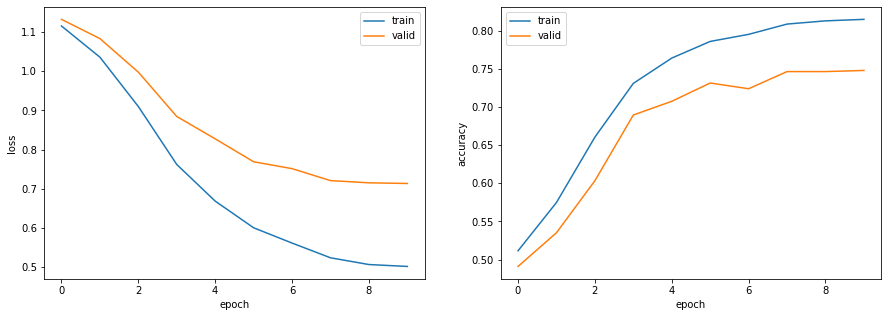

正解率（学習データ）：0.815
正解率（評価データ）：0.772


In [15]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [33]:
#83
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

## GPUの確認

In [16]:
!nvidia-smi

Sun Jan 30 16:24:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN X ...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   24C    P8     8W / 250W |      8MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN X ...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [17]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device("cuda")

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2604, accuracy_train: 0.4056, loss_valid: 1.2629, accuracy_valid: 0.4072, 10.0428sec
epoch: 2, loss_train: 1.2696, accuracy_train: 0.4086, loss_valid: 1.2843, accuracy_valid: 0.4019, 10.0283sec
epoch: 3, loss_train: 1.1659, accuracy_train: 0.4963, loss_valid: 1.1762, accuracy_valid: 0.4798, 9.9935sec
epoch: 4, loss_train: 1.0956, accuracy_train: 0.5671, loss_valid: 1.1211, accuracy_valid: 0.5240, 10.1462sec
epoch: 5, loss_train: 1.0144, accuracy_train: 0.6353, loss_valid: 1.0663, accuracy_valid: 0.5861, 10.7708sec
epoch: 6, loss_train: 0.9934, accuracy_train: 0.6465, loss_valid: 1.0409, accuracy_valid: 0.5921, 10.7953sec
epoch: 7, loss_train: 0.9584, accuracy_train: 0.6660, loss_valid: 1.0156, accuracy_valid: 0.6115, 10.1055sec
epoch: 8, loss_train: 0.9278, accuracy_train: 0.6846, loss_valid: 0.9840, accuracy_valid: 0.6295, 10.0323sec
epoch: 9, loss_train: 0.8989, accuracy_train: 0.6982, loss_valid: 0.9677, accuracy_valid: 0.6310, 10.0533sec
epoch: 10, loss_trai

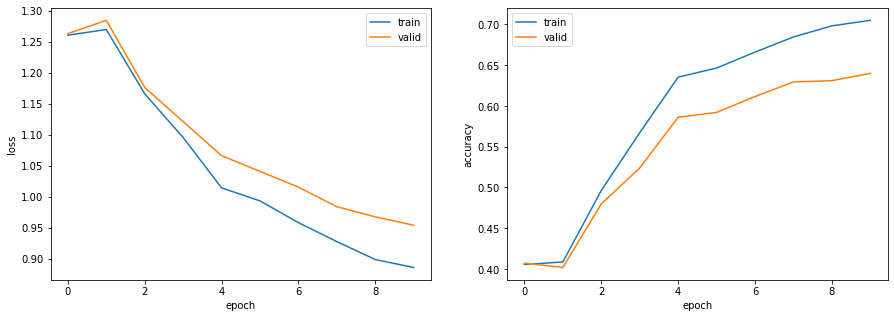

正解率（学習データ）：0.705
正解率（評価データ）：0.661


In [18]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [19]:
#84(準備)
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2022-01-30 16:26:08--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.73.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.73.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  17.4MB/s    in 1m 55s  

2022-01-30 16:28:03 (13.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [29]:
!pip install gensim

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 24.1 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 17.2 MB/s eta 0:00:01
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [50]:
from gensim.models import KeyedVectors
import numpy as np

# 学習済みモデルのロード
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = torch.tensor(model[word])
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9130 / 9375
torch.Size([9375, 300])


In [51]:
#84
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden() # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(device)
    return hidden

In [52]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1727, accuracy_train: 0.4048, loss_valid: 1.1770, accuracy_valid: 0.4004, 10.2407sec
epoch: 2, loss_train: 1.1675, accuracy_train: 0.4589, loss_valid: 1.2061, accuracy_valid: 0.4424, 10.3068sec
epoch: 3, loss_train: 1.1229, accuracy_train: 0.5299, loss_valid: 1.1616, accuracy_valid: 0.4963, 10.2803sec
epoch: 4, loss_train: 1.0831, accuracy_train: 0.5792, loss_valid: 1.1326, accuracy_valid: 0.5509, 10.2392sec
epoch: 5, loss_train: 1.0355, accuracy_train: 0.6105, loss_valid: 1.0762, accuracy_valid: 0.5786, 10.1870sec
epoch: 6, loss_train: 0.9867, accuracy_train: 0.6338, loss_valid: 1.0342, accuracy_valid: 0.6115, 10.1711sec
epoch: 7, loss_train: 0.9885, accuracy_train: 0.6277, loss_valid: 1.0592, accuracy_valid: 0.5928, 10.1750sec
epoch: 8, loss_train: 0.9354, accuracy_train: 0.6603, loss_valid: 0.9968, accuracy_valid: 0.6243, 10.1195sec
epoch: 9, loss_train: 0.9587, accuracy_train: 0.6455, loss_valid: 1.0229, accuracy_valid: 0.6198, 10.1766sec
epoch: 10, loss_tra

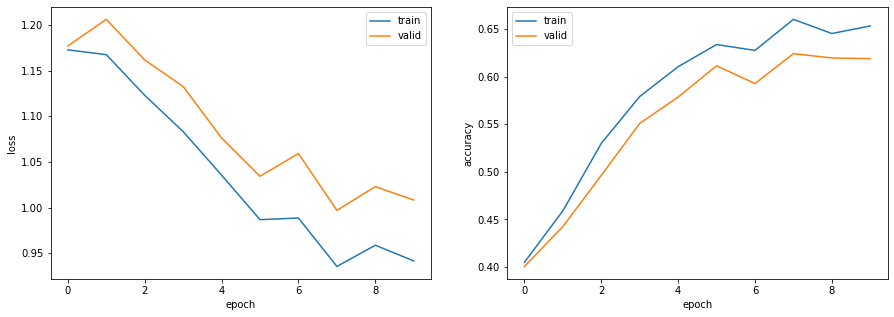

正解率（学習データ）：0.653
正解率（評価データ）：0.653


In [53]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [57]:
#85
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1785, accuracy_train: 0.3981, loss_valid: 1.1797, accuracy_valid: 0.4094, 16.1610sec
epoch: 2, loss_train: 1.1629, accuracy_train: 0.4612, loss_valid: 1.1962, accuracy_valid: 0.4543, 16.0586sec
epoch: 3, loss_train: 1.0489, accuracy_train: 0.5956, loss_valid: 1.0856, accuracy_valid: 0.5674, 16.1191sec
epoch: 4, loss_train: 1.1514, accuracy_train: 0.5249, loss_valid: 1.2068, accuracy_valid: 0.5045, 16.6655sec
epoch: 5, loss_train: 0.9867, accuracy_train: 0.6403, loss_valid: 1.0199, accuracy_valid: 0.6055, 16.0653sec
epoch: 6, loss_train: 1.1109, accuracy_train: 0.5711, loss_valid: 1.1598, accuracy_valid: 0.5539, 16.0158sec
epoch: 7, loss_train: 1.0316, accuracy_train: 0.6023, loss_valid: 1.0918, accuracy_valid: 0.5771, 16.0690sec
epoch: 8, loss_train: 0.9517, accuracy_train: 0.6450, loss_valid: 1.0117, accuracy_valid: 0.6198, 16.0438sec
epoch: 9, loss_train: 0.9660, accuracy_train: 0.6373, loss_valid: 1.0258, accuracy_valid: 0.6085, 16.0734sec
epoch: 10, loss_tra

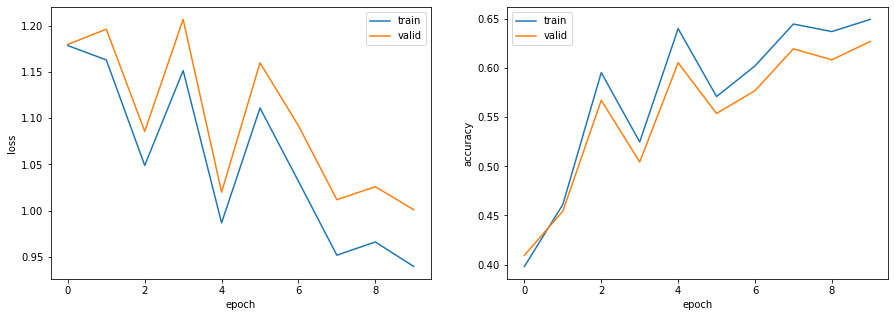

In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

In [27]:
#86

from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)
    
  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [28]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2229, 0.3275, 0.1748, 0.2748]], grad_fn=<SoftmaxBackward>)
tensor([[0.2635, 0.2269, 0.2131, 0.2965]], grad_fn=<SoftmaxBackward>)
tensor([[0.2216, 0.2451, 0.1980, 0.3353]], grad_fn=<SoftmaxBackward>)
tensor([[0.2412, 0.2842, 0.2107, 0.2638]], grad_fn=<SoftmaxBackward>)
tensor([[0.2485, 0.2746, 0.2039, 0.2730]], grad_fn=<SoftmaxBackward>)
tensor([[0.2696, 0.2742, 0.1877, 0.2684]], grad_fn=<SoftmaxBackward>)
tensor([[0.2590, 0.2768, 0.1879, 0.2762]], grad_fn=<SoftmaxBackward>)
tensor([[0.2565, 0.2441, 0.2106, 0.2888]], grad_fn=<SoftmaxBackward>)
tensor([[0.2450, 0.2529, 0.2219, 0.2802]], grad_fn=<SoftmaxBackward>)
tensor([[0.2064, 0.2359, 0.2488, 0.3089]], grad_fn=<SoftmaxBackward>)


In [29]:
#87

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0728, accuracy_train: 0.5572, loss_valid: 1.0893, accuracy_valid: 0.5531, 7.9598sec
epoch: 2, loss_train: 0.9988, accuracy_train: 0.6246, loss_valid: 1.0329, accuracy_valid: 0.6010, 7.9088sec
epoch: 3, loss_train: 0.9244, accuracy_train: 0.6797, loss_valid: 0.9731, accuracy_valid: 0.6400, 7.8834sec
epoch: 4, loss_train: 0.8622, accuracy_train: 0.7085, loss_valid: 0.9268, accuracy_valid: 0.6654, 7.8559sec
epoch: 5, loss_train: 0.8163, accuracy_train: 0.7221, loss_valid: 0.8900, accuracy_valid: 0.6744, 7.8554sec
epoch: 6, loss_train: 0.7848, accuracy_train: 0.7367, loss_valid: 0.8710, accuracy_valid: 0.6916, 7.8573sec
epoch: 7, loss_train: 0.7621, accuracy_train: 0.7421, loss_valid: 0.8552, accuracy_valid: 0.6976, 7.8268sec
epoch: 8, loss_train: 0.7494, accuracy_train: 0.7459, loss_valid: 0.8458, accuracy_valid: 0.7028, 7.8381sec
epoch: 9, loss_train: 0.7437, accuracy_train: 0.7471, loss_valid: 0.8422, accuracy_valid: 0.7028, 7.8611sec
epoch: 10, loss_train: 0.742

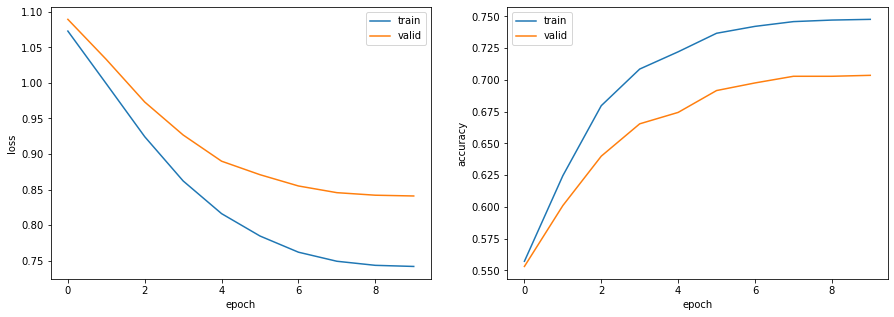

正解率（学習データ）：0.748
正解率（評価データ）：0.707


In [30]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## #88
まず #85のハイパーパラメータ探索を行う

In [20]:
!pip install optuna

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 308 kB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 25.3 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 65.4 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 16.1 MB/s eta 0:00:01
     |████████████████████████████████| 149 kB 58.8 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=0639f34f20ddb942b23a9aaec47cfcc5596ab785248850555e7bb7dfcc309408
  Stored in directory: /home/jovyan/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [16]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

In [49]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden() # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(device)
    return hidden

In [12]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率を返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=num_eta_min, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    
    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
    
    # 終了時刻の記録
    e_time = time.time()
    
    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 
    
    
    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return log_train, log_valid



def display_train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率を返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=num_eta_min, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    
    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
    
    # 終了時刻の記録
    e_time = time.time()
    
    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 
    
    
    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [51]:
import optuna

def Get_Optimizer(trial, model): #optimizerの最適化関数
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD']) 
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) #学習率の初期値を変更
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    return optimizer

# デバイスの指定
device = torch.device('cuda')

def objective(trial): 
       
    # デバイスの指定
    device = torch.device('cuda')
    
    #パラメータの設定(小文字はハイパーパラメータチューニングを行う)
    VOCAB_SIZE = len(set(word2id.values())) + 1
    EMB_SIZE =300
    PADDING_IDX = len(set(word2id.values()))
    OUTPUT_SIZE = 4
    hidden_size = int(trial.suggest_discrete_uniform('hidden_size', 10, 100, 10))
    #hidden_size = 50
    num_layers = int(trial.suggest_discrete_uniform('num_layers', 2, 5, 1))
    batch_size = int(trial.suggest_discrete_uniform('batch_size', 64, 1024, 64)) #適切なバッチサイズを64-1024の間で64刻みで探す
    #num_epochs = trial.suggest_int('num_epochs', 5, 50) #適切なエポック数を探す
    num_epochs = 10
    num_eta_min = trial.suggest_loguniform('min_lr', 1e-5, 1e-1)#スケジューラの学習率の最小値
    
    
    # モデルの定義
    model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, hidden_size, num_layers, emb_weights=weights, bidirectional=True)
    
    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()
    
    # オプティマイザの定義
    #optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    optimizer = Get_Optimizer(trial,model)

    
    return train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=Padsequence(PADDING_IDX), device=device)[1][-1][0] #log_validの最後のlossを取得
    #return train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, device)[1][-3][0] #log_validの最後から3番目のlossを取得（最小値)

In [52]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=14400)

[I 2022-01-30 20:16:28,431] A new study created in memory with name: no-name-51016808-46a7-4980-9bd2-b10c2f3b660b


epoch: 1, loss_train: 1.3938, accuracy_train: 0.2098, loss_valid: 1.3872, accuracy_valid: 0.2373, 20.0498sec
epoch: 2, loss_train: 1.3848, accuracy_train: 0.2423, loss_valid: 1.3784, accuracy_valid: 0.2605, 19.9649sec
epoch: 3, loss_train: 1.3611, accuracy_train: 0.3196, loss_valid: 1.3551, accuracy_valid: 0.3368, 19.9275sec
epoch: 4, loss_train: 1.3209, accuracy_train: 0.3951, loss_valid: 1.3156, accuracy_valid: 0.3930, 19.9560sec
epoch: 5, loss_train: 1.2705, accuracy_train: 0.4099, loss_valid: 1.2664, accuracy_valid: 0.4049, 20.0746sec
epoch: 6, loss_train: 1.2228, accuracy_train: 0.4123, loss_valid: 1.2200, accuracy_valid: 0.3967, 20.0022sec
epoch: 7, loss_train: 1.1900, accuracy_train: 0.4198, loss_valid: 1.1885, accuracy_valid: 0.3997, 19.9749sec
epoch: 8, loss_train: 1.1742, accuracy_train: 0.4247, loss_valid: 1.1737, accuracy_valid: 0.4034, 19.9041sec
epoch: 9, loss_train: 1.1687, accuracy_train: 0.4244, loss_valid: 1.1686, accuracy_valid: 0.4049, 19.9187sec


[I 2022-01-30 20:19:48,240] Trial 0 finished with value: 1.1670186011020296 and parameters: {'hidden_size': 90.0, 'num_layers': 3.0, 'batch_size': 384.0, 'min_lr': 0.009582366317616893, 'optimizer': 'SGD', 'lr': 0.00013013291438730018}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.1668, accuracy_train: 0.4245, loss_valid: 1.1670, accuracy_valid: 0.4072, 19.9951sec
epoch: 1, loss_train: 1.1632, accuracy_train: 0.4110, loss_valid: 1.1656, accuracy_valid: 0.4034, 27.8341sec
epoch: 2, loss_train: 1.1611, accuracy_train: 0.4279, loss_valid: 1.1631, accuracy_valid: 0.4311, 27.7788sec
epoch: 3, loss_train: 1.2134, accuracy_train: 0.4074, loss_valid: 1.2615, accuracy_valid: 0.3982, 27.7484sec
epoch: 4, loss_train: 1.1547, accuracy_train: 0.5116, loss_valid: 1.1973, accuracy_valid: 0.4948, 27.7462sec
epoch: 5, loss_train: 1.1688, accuracy_train: 0.5281, loss_valid: 1.1863, accuracy_valid: 0.5075, 27.8821sec
epoch: 6, loss_train: 1.1763, accuracy_train: 0.5767, loss_valid: 1.2323, accuracy_valid: 0.5487, 27.5938sec
epoch: 7, loss_train: 1.5317, accuracy_train: 0.3737, loss_valid: 1.5721, accuracy_valid: 0.3892, 27.8876sec
epoch: 8, loss_train: 1.1476, accuracy_train: 0.5526, loss_valid: 1.1743, accuracy_valid: 0.5337, 27.7797sec
epoch: 9, loss_tra

[I 2022-01-30 20:24:26,341] Trial 1 finished with value: 1.2922429468839647 and parameters: {'hidden_size': 30.0, 'num_layers': 5.0, 'batch_size': 832.0, 'min_lr': 0.012418421563891356, 'optimizer': 'Adam', 'lr': 0.0006633059248505418}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.2401, accuracy_train: 0.5223, loss_valid: 1.2922, accuracy_valid: 0.4993, 27.9095sec
epoch: 1, loss_train: 1.0301, accuracy_train: 0.6162, loss_valid: 1.0570, accuracy_valid: 0.5988, 25.0913sec
epoch: 2, loss_train: 1.0765, accuracy_train: 0.5845, loss_valid: 1.0974, accuracy_valid: 0.5509, 25.2260sec
epoch: 3, loss_train: 1.1649, accuracy_train: 0.3964, loss_valid: 1.1719, accuracy_valid: 0.3960, 25.0666sec
epoch: 4, loss_train: 1.1393, accuracy_train: 0.4999, loss_valid: 1.1412, accuracy_valid: 0.4850, 25.2038sec
epoch: 5, loss_train: 1.1856, accuracy_train: 0.4266, loss_valid: 1.2066, accuracy_valid: 0.4214, 25.1101sec
epoch: 6, loss_train: 1.1751, accuracy_train: 0.3946, loss_valid: 1.1819, accuracy_valid: 0.3937, 25.0916sec
epoch: 7, loss_train: 1.6230, accuracy_train: 0.2158, loss_valid: 1.6674, accuracy_valid: 0.1961, 25.3143sec
epoch: 8, loss_train: 1.2415, accuracy_train: 0.4163, loss_valid: 1.2513, accuracy_valid: 0.4049, 25.1244sec
epoch: 9, loss_tra

[I 2022-01-30 20:28:37,898] Trial 2 finished with value: 1.228107738682253 and parameters: {'hidden_size': 50.0, 'num_layers': 4.0, 'batch_size': 128.0, 'min_lr': 0.022773643002911275, 'optimizer': 'Adam', 'lr': 0.004139869635237494}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.2459, accuracy_train: 0.4070, loss_valid: 1.2281, accuracy_valid: 0.4019, 25.1770sec
epoch: 1, loss_train: 1.2649, accuracy_train: 0.4246, loss_valid: 1.2637, accuracy_valid: 0.4244, 27.7417sec
epoch: 2, loss_train: 1.2101, accuracy_train: 0.4214, loss_valid: 1.2089, accuracy_valid: 0.4319, 27.7483sec
epoch: 3, loss_train: 1.1870, accuracy_train: 0.4203, loss_valid: 1.1857, accuracy_valid: 0.4281, 27.8209sec
epoch: 4, loss_train: 1.1772, accuracy_train: 0.4207, loss_valid: 1.1759, accuracy_valid: 0.4274, 27.7059sec
epoch: 5, loss_train: 1.1729, accuracy_train: 0.4207, loss_valid: 1.1716, accuracy_valid: 0.4304, 27.8148sec
epoch: 6, loss_train: 1.1707, accuracy_train: 0.4209, loss_valid: 1.1694, accuracy_valid: 0.4296, 27.7452sec
epoch: 7, loss_train: 1.1696, accuracy_train: 0.4200, loss_valid: 1.1683, accuracy_valid: 0.4274, 27.5216sec
epoch: 8, loss_train: 1.1690, accuracy_train: 0.4209, loss_valid: 1.1677, accuracy_valid: 0.4281, 27.8598sec
epoch: 9, loss_tra

[I 2022-01-30 20:33:15,320] Trial 3 finished with value: 1.1674573120778193 and parameters: {'hidden_size': 80.0, 'num_layers': 5.0, 'batch_size': 1024.0, 'min_lr': 2.4240921484684552e-05, 'optimizer': 'SGD', 'lr': 0.01131922354546442}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.1687, accuracy_train: 0.4208, loss_valid: 1.1675, accuracy_valid: 0.4266, 27.7982sec
epoch: 1, loss_train: 1.3269, accuracy_train: 0.3693, loss_valid: 1.3276, accuracy_valid: 0.3735, 15.8640sec
epoch: 2, loss_train: 1.2160, accuracy_train: 0.4027, loss_valid: 1.2169, accuracy_valid: 0.4019, 15.8428sec
epoch: 3, loss_train: 1.1678, accuracy_train: 0.4223, loss_valid: 1.1667, accuracy_valid: 0.4222, 15.8502sec
epoch: 4, loss_train: 1.1779, accuracy_train: 0.4062, loss_valid: 1.1860, accuracy_valid: 0.4132, 15.8483sec
epoch: 5, loss_train: 1.2319, accuracy_train: 0.3915, loss_valid: 1.2507, accuracy_valid: 0.3915, 15.8518sec
epoch: 6, loss_train: 1.1224, accuracy_train: 0.5446, loss_valid: 1.1518, accuracy_valid: 0.5210, 15.8323sec
epoch: 7, loss_train: 1.1684, accuracy_train: 0.5408, loss_valid: 1.2154, accuracy_valid: 0.5187, 15.8221sec
epoch: 8, loss_train: 1.1549, accuracy_train: 0.5768, loss_valid: 1.2300, accuracy_valid: 0.5404, 15.9102sec
epoch: 9, loss_tra

[I 2022-01-30 20:35:53,874] Trial 4 finished with value: 1.1974503598594202 and parameters: {'hidden_size': 20.0, 'num_layers': 2.0, 'batch_size': 256.0, 'min_lr': 0.0032793060443160305, 'optimizer': 'Adam', 'lr': 7.74626630858388e-05}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.1340, accuracy_train: 0.5857, loss_valid: 1.1975, accuracy_valid: 0.5599, 15.8477sec
epoch: 1, loss_train: 1.3267, accuracy_train: 0.3837, loss_valid: 1.3364, accuracy_valid: 0.3907, 15.8184sec
epoch: 2, loss_train: 1.2946, accuracy_train: 0.3983, loss_valid: 1.3043, accuracy_valid: 0.4094, 15.8414sec
epoch: 3, loss_train: 1.2720, accuracy_train: 0.4031, loss_valid: 1.2816, accuracy_valid: 0.4154, 15.8122sec
epoch: 4, loss_train: 1.2564, accuracy_train: 0.4043, loss_valid: 1.2659, accuracy_valid: 0.4169, 15.9039sec
epoch: 5, loss_train: 1.2457, accuracy_train: 0.4043, loss_valid: 1.2551, accuracy_valid: 0.4154, 15.9198sec
epoch: 6, loss_train: 1.2387, accuracy_train: 0.4044, loss_valid: 1.2480, accuracy_valid: 0.4132, 15.7919sec
epoch: 7, loss_train: 1.2342, accuracy_train: 0.4053, loss_valid: 1.2435, accuracy_valid: 0.4139, 15.9527sec
epoch: 8, loss_train: 1.2317, accuracy_train: 0.4061, loss_valid: 1.2409, accuracy_valid: 0.4132, 15.8490sec
epoch: 9, loss_tra

[I 2022-01-30 20:38:32,382] Trial 5 finished with value: 1.2390197419567022 and parameters: {'hidden_size': 10.0, 'num_layers': 2.0, 'batch_size': 832.0, 'min_lr': 0.00028275919755516574, 'optimizer': 'SGD', 'lr': 0.010992155559429501}. Best is trial 0 with value: 1.1670186011020296.


epoch: 10, loss_train: 1.2298, accuracy_train: 0.4068, loss_valid: 1.2390, accuracy_valid: 0.4117, 15.7092sec
epoch: 1, loss_train: 1.4279, accuracy_train: 0.1471, loss_valid: 1.4286, accuracy_valid: 0.1557, 15.9041sec
epoch: 2, loss_train: 1.4174, accuracy_train: 0.1700, loss_valid: 1.4183, accuracy_valid: 0.1751, 16.0307sec
epoch: 3, loss_train: 1.3813, accuracy_train: 0.2762, loss_valid: 1.3826, accuracy_valid: 0.2829, 15.9242sec
epoch: 4, loss_train: 1.3215, accuracy_train: 0.4053, loss_valid: 1.3236, accuracy_valid: 0.4034, 15.8937sec
epoch: 5, loss_train: 1.2549, accuracy_train: 0.4202, loss_valid: 1.2576, accuracy_valid: 0.4229, 15.7166sec
epoch: 6, loss_train: 1.2034, accuracy_train: 0.4199, loss_valid: 1.2060, accuracy_valid: 0.4184, 15.9548sec
epoch: 7, loss_train: 1.1773, accuracy_train: 0.4200, loss_valid: 1.1792, accuracy_valid: 0.4259, 15.8157sec
epoch: 8, loss_train: 1.1685, accuracy_train: 0.4208, loss_valid: 1.1698, accuracy_valid: 0.4207, 15.7988sec
epoch: 9, loss_tra

[I 2022-01-30 20:41:11,109] Trial 6 finished with value: 1.1657964696962677 and parameters: {'hidden_size': 90.0, 'num_layers': 2.0, 'batch_size': 1024.0, 'min_lr': 0.04305117790145214, 'optimizer': 'SGD', 'lr': 1.6504128929549728e-05}. Best is trial 6 with value: 1.1657964696962677.


epoch: 10, loss_train: 1.1651, accuracy_train: 0.4136, loss_valid: 1.1658, accuracy_valid: 0.4192, 15.8063sec
epoch: 1, loss_train: 1.3960, accuracy_train: 0.2012, loss_valid: 1.3996, accuracy_valid: 0.1729, 24.2092sec
epoch: 2, loss_train: 1.3911, accuracy_train: 0.2210, loss_valid: 1.3948, accuracy_valid: 0.1841, 24.3362sec
epoch: 3, loss_train: 1.3865, accuracy_train: 0.2390, loss_valid: 1.3903, accuracy_valid: 0.2066, 24.3379sec
epoch: 4, loss_train: 1.3822, accuracy_train: 0.2579, loss_valid: 1.3861, accuracy_valid: 0.2208, 24.2834sec
epoch: 5, loss_train: 1.3784, accuracy_train: 0.2710, loss_valid: 1.3824, accuracy_valid: 0.2410, 24.2952sec
epoch: 6, loss_train: 1.3750, accuracy_train: 0.2851, loss_valid: 1.3791, accuracy_valid: 0.2567, 24.3801sec
epoch: 7, loss_train: 1.3720, accuracy_train: 0.2991, loss_valid: 1.3761, accuracy_valid: 0.2657, 24.2359sec
epoch: 8, loss_train: 1.3694, accuracy_train: 0.3094, loss_valid: 1.3736, accuracy_valid: 0.2769, 24.3224sec
epoch: 9, loss_tra

[I 2022-01-30 20:45:14,123] Trial 7 finished with value: 1.3691189713820726 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 256.0, 'min_lr': 4.796703483477973e-05, 'optimizer': 'SGD', 'lr': 9.618087886858199e-05}. Best is trial 6 with value: 1.1657964696962677.


epoch: 10, loss_train: 1.3648, accuracy_train: 0.3258, loss_valid: 1.3691, accuracy_valid: 0.2979, 24.3414sec
epoch: 1, loss_train: 6.9911, accuracy_train: 0.3790, loss_valid: 7.3350, accuracy_valid: 0.3466, 28.0645sec
epoch: 2, loss_train: 2.6110, accuracy_train: 0.3663, loss_valid: 3.0988, accuracy_valid: 0.3466, 27.9914sec
epoch: 3, loss_train: 5.0430, accuracy_train: 0.3911, loss_valid: 5.3964, accuracy_valid: 0.3615, 28.1530sec
epoch: 4, loss_train: 2.5546, accuracy_train: 0.3085, loss_valid: 2.8887, accuracy_valid: 0.3001, 28.0970sec
epoch: 5, loss_train: 2.5082, accuracy_train: 0.3913, loss_valid: 2.6948, accuracy_valid: 0.3855, 28.1682sec
epoch: 6, loss_train: 2.1333, accuracy_train: 0.3926, loss_valid: 2.3648, accuracy_valid: 0.3885, 28.3312sec
epoch: 7, loss_train: 1.8705, accuracy_train: 0.3911, loss_valid: 2.1740, accuracy_valid: 0.3840, 28.0563sec
epoch: 8, loss_train: 1.7346, accuracy_train: 0.3907, loss_valid: 2.0589, accuracy_valid: 0.3593, 28.1853sec
epoch: 9, loss_tra

[I 2022-01-30 20:49:55,361] Trial 8 finished with value: 2.0410245533443185 and parameters: {'hidden_size': 40.0, 'num_layers': 5.0, 'batch_size': 448.0, 'min_lr': 4.790282609520423e-05, 'optimizer': 'RMSprop', 'lr': 0.058667278277811624}. Best is trial 6 with value: 1.1657964696962677.


epoch: 10, loss_train: 1.7176, accuracy_train: 0.4053, loss_valid: 2.0410, accuracy_valid: 0.3847, 28.1049sec
epoch: 1, loss_train: 1.3977, accuracy_train: 0.2711, loss_valid: 1.4036, accuracy_valid: 0.2448, 24.0043sec
epoch: 2, loss_train: 1.3974, accuracy_train: 0.2721, loss_valid: 1.4033, accuracy_valid: 0.2448, 23.8879sec
epoch: 3, loss_train: 1.3971, accuracy_train: 0.2736, loss_valid: 1.4030, accuracy_valid: 0.2485, 23.9553sec
epoch: 4, loss_train: 1.3968, accuracy_train: 0.2742, loss_valid: 1.4028, accuracy_valid: 0.2500, 23.9336sec
epoch: 5, loss_train: 1.3965, accuracy_train: 0.2748, loss_valid: 1.4025, accuracy_valid: 0.2515, 24.0381sec
epoch: 6, loss_train: 1.3963, accuracy_train: 0.2748, loss_valid: 1.4022, accuracy_valid: 0.2545, 23.9136sec
epoch: 7, loss_train: 1.3960, accuracy_train: 0.2754, loss_valid: 1.4020, accuracy_valid: 0.2545, 23.9459sec
epoch: 8, loss_train: 1.3958, accuracy_train: 0.2759, loss_valid: 1.4017, accuracy_valid: 0.2545, 24.0302sec
epoch: 9, loss_tra

[I 2022-01-30 20:53:54,845] Trial 9 finished with value: 1.4012742790276418 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 640.0, 'min_lr': 1.1032115691574387e-05, 'optimizer': 'SGD', 'lr': 1.3653296186450255e-05}. Best is trial 6 with value: 1.1657964696962677.


epoch: 10, loss_train: 1.3953, accuracy_train: 0.2763, loss_valid: 1.4013, accuracy_valid: 0.2567, 23.9689sec
epoch: 1, loss_train: 1.3075, accuracy_train: 0.3984, loss_valid: 1.3041, accuracy_valid: 0.3915, 19.8458sec
epoch: 2, loss_train: 1.7962, accuracy_train: 0.1130, loss_valid: 1.8043, accuracy_valid: 0.1078, 19.9541sec
epoch: 3, loss_train: 2.1016, accuracy_train: 0.3011, loss_valid: 2.1826, accuracy_valid: 0.2934, 19.6893sec


[I 2022-01-30 20:55:14,080] Trial 10 finished with value: 7.317129891740782 and parameters: {'hidden_size': 100.0, 'num_layers': 3.0, 'batch_size': 1024.0, 'min_lr': 0.09771458494424784, 'optimizer': 'RMSprop', 'lr': 1.2221289376967635e-05}. Best is trial 6 with value: 1.1657964696962677.


epoch: 4, loss_train: 7.5043, accuracy_train: 0.3204, loss_valid: 7.3171, accuracy_valid: 0.3226, 19.7089sec
epoch: 1, loss_train: 1.3671, accuracy_train: 0.3595, loss_valid: 1.3691, accuracy_valid: 0.3555, 19.7792sec
epoch: 2, loss_train: 1.3334, accuracy_train: 0.4137, loss_valid: 1.3352, accuracy_valid: 0.4094, 19.8333sec
epoch: 3, loss_train: 1.2489, accuracy_train: 0.4252, loss_valid: 1.2502, accuracy_valid: 0.4207, 19.9542sec
epoch: 4, loss_train: 1.1828, accuracy_train: 0.4282, loss_valid: 1.1832, accuracy_valid: 0.4229, 19.9006sec
epoch: 5, loss_train: 1.1682, accuracy_train: 0.4267, loss_valid: 1.1679, accuracy_valid: 0.4237, 19.7072sec
epoch: 6, loss_train: 1.1680, accuracy_train: 0.4273, loss_valid: 1.1676, accuracy_valid: 0.4222, 19.9376sec
epoch: 7, loss_train: 1.1658, accuracy_train: 0.4262, loss_valid: 1.1650, accuracy_valid: 0.4237, 19.9079sec
epoch: 8, loss_train: 1.1660, accuracy_train: 0.4189, loss_valid: 1.1651, accuracy_valid: 0.4334, 19.8532sec
epoch: 9, loss_trai

[I 2022-01-30 20:58:32,721] Trial 11 finished with value: 1.1647830112073236 and parameters: {'hidden_size': 100.0, 'num_layers': 3.0, 'batch_size': 512.0, 'min_lr': 0.09729229268058791, 'optimizer': 'SGD', 'lr': 0.00012849810312665557}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.1653, accuracy_train: 0.4305, loss_valid: 1.1648, accuracy_valid: 0.4356, 19.7892sec
epoch: 1, loss_train: 1.3978, accuracy_train: 0.2719, loss_valid: 1.4012, accuracy_valid: 0.2522, 16.0407sec
epoch: 2, loss_train: 1.3708, accuracy_train: 0.3326, loss_valid: 1.3745, accuracy_valid: 0.3166, 15.8566sec
epoch: 3, loss_train: 1.2975, accuracy_train: 0.3816, loss_valid: 1.3018, accuracy_valid: 0.3840, 15.9731sec
epoch: 4, loss_train: 1.2104, accuracy_train: 0.3992, loss_valid: 1.2146, accuracy_valid: 0.3772, 16.0196sec
epoch: 5, loss_train: 1.1728, accuracy_train: 0.4063, loss_valid: 1.1757, accuracy_valid: 0.3892, 15.9917sec
epoch: 6, loss_train: 1.1680, accuracy_train: 0.4020, loss_valid: 1.1701, accuracy_valid: 0.3900, 15.8821sec
epoch: 7, loss_train: 1.1669, accuracy_train: 0.4073, loss_valid: 1.1689, accuracy_valid: 0.3885, 16.0282sec
epoch: 8, loss_train: 1.1674, accuracy_train: 0.3943, loss_valid: 1.1691, accuracy_valid: 0.3757, 15.8969sec
epoch: 9, loss_tra

[I 2022-01-30 21:01:12,420] Trial 12 finished with value: 1.169192876956777 and parameters: {'hidden_size': 80.0, 'num_layers': 2.0, 'batch_size': 640.0, 'min_lr': 0.09623484373505821, 'optimizer': 'SGD', 'lr': 0.0003881941457810236}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.1672, accuracy_train: 0.4014, loss_valid: 1.1692, accuracy_valid: 0.3743, 15.9510sec
epoch: 1, loss_train: 1.3709, accuracy_train: 0.3221, loss_valid: 1.3706, accuracy_valid: 0.3241, 19.8808sec
epoch: 2, loss_train: 1.3702, accuracy_train: 0.3245, loss_valid: 1.3699, accuracy_valid: 0.3249, 19.6799sec
epoch: 3, loss_train: 1.3687, accuracy_train: 0.3302, loss_valid: 1.3684, accuracy_valid: 0.3308, 19.7804sec
epoch: 4, loss_train: 1.3661, accuracy_train: 0.3415, loss_valid: 1.3657, accuracy_valid: 0.3391, 19.7468sec
epoch: 5, loss_train: 1.3620, accuracy_train: 0.3537, loss_valid: 1.3616, accuracy_valid: 0.3481, 19.7182sec
epoch: 6, loss_train: 1.3565, accuracy_train: 0.3697, loss_valid: 1.3561, accuracy_valid: 0.3615, 19.8226sec
epoch: 7, loss_train: 1.3497, accuracy_train: 0.3827, loss_valid: 1.3493, accuracy_valid: 0.3780, 19.7845sec
epoch: 8, loss_train: 1.3420, accuracy_train: 0.3940, loss_valid: 1.3415, accuracy_valid: 0.3862, 19.6960sec
epoch: 9, loss_tra

[I 2022-01-30 21:04:30,170] Trial 13 finished with value: 1.3245431232059788 and parameters: {'hidden_size': 100.0, 'num_layers': 3.0, 'batch_size': 768.0, 'min_lr': 0.0009398449117989522, 'optimizer': 'SGD', 'lr': 3.6895937331460155e-05}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.3251, accuracy_train: 0.4032, loss_valid: 1.3245, accuracy_valid: 0.4109, 19.8104sec
epoch: 1, loss_train: 1.3823, accuracy_train: 0.2873, loss_valid: 1.3811, accuracy_valid: 0.2799, 16.0227sec
epoch: 2, loss_train: 1.3688, accuracy_train: 0.3307, loss_valid: 1.3676, accuracy_valid: 0.3278, 15.9798sec
epoch: 3, loss_train: 1.3306, accuracy_train: 0.3973, loss_valid: 1.3295, accuracy_valid: 0.3982, 15.8398sec
epoch: 4, loss_train: 1.2702, accuracy_train: 0.4076, loss_valid: 1.2691, accuracy_valid: 0.4049, 16.1646sec
epoch: 5, loss_train: 1.2093, accuracy_train: 0.4091, loss_valid: 1.2084, accuracy_valid: 0.4049, 16.0748sec
epoch: 6, loss_train: 1.1762, accuracy_train: 0.4118, loss_valid: 1.1754, accuracy_valid: 0.4049, 16.0621sec
epoch: 7, loss_train: 1.1676, accuracy_train: 0.4117, loss_valid: 1.1667, accuracy_valid: 0.4042, 16.0491sec
epoch: 8, loss_train: 1.1666, accuracy_train: 0.4087, loss_valid: 1.1657, accuracy_valid: 0.4072, 16.0638sec
epoch: 9, loss_tra

[I 2022-01-30 21:07:10,639] Trial 14 finished with value: 1.1651050950774176 and parameters: {'hidden_size': 80.0, 'num_layers': 2.0, 'batch_size': 512.0, 'min_lr': 0.040733571544799965, 'optimizer': 'SGD', 'lr': 0.00032401117122214375}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.1660, accuracy_train: 0.4117, loss_valid: 1.1651, accuracy_valid: 0.4019, 15.9776sec
epoch: 1, loss_train: 1.1768, accuracy_train: 0.3913, loss_valid: 1.1765, accuracy_valid: 0.3937, 20.0095sec
epoch: 2, loss_train: 1.1845, accuracy_train: 0.3604, loss_valid: 1.1795, accuracy_valid: 0.3698, 19.8958sec
epoch: 3, loss_train: 1.4131, accuracy_train: 0.3458, loss_valid: 1.3802, accuracy_valid: 0.3503, 19.8473sec
epoch: 4, loss_train: 1.1624, accuracy_train: 0.4239, loss_valid: 1.1686, accuracy_valid: 0.4139, 20.0423sec
epoch: 5, loss_train: 1.1848, accuracy_train: 0.3990, loss_valid: 1.1893, accuracy_valid: 0.3862, 19.9751sec
epoch: 6, loss_train: 1.1876, accuracy_train: 0.4232, loss_valid: 1.1890, accuracy_valid: 0.4222, 19.9098sec
epoch: 7, loss_train: 1.1683, accuracy_train: 0.3902, loss_valid: 1.1722, accuracy_valid: 0.3862, 19.8468sec
epoch: 8, loss_train: 1.1371, accuracy_train: 0.5109, loss_valid: 1.1495, accuracy_valid: 0.4820, 19.9293sec
epoch: 9, loss_tra

[I 2022-01-30 21:10:29,940] Trial 15 finished with value: 1.2628870558685172 and parameters: {'hidden_size': 70.0, 'num_layers': 3.0, 'batch_size': 512.0, 'min_lr': 0.005158632055726088, 'optimizer': 'RMSprop', 'lr': 0.0018041288034376848}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.2677, accuracy_train: 0.4169, loss_valid: 1.2629, accuracy_valid: 0.4184, 19.8688sec
epoch: 1, loss_train: 1.3507, accuracy_train: 0.3798, loss_valid: 1.3476, accuracy_valid: 0.3743, 16.1604sec
epoch: 2, loss_train: 1.3460, accuracy_train: 0.3873, loss_valid: 1.3430, accuracy_valid: 0.3757, 16.1941sec
epoch: 3, loss_train: 1.3390, accuracy_train: 0.3952, loss_valid: 1.3361, accuracy_valid: 0.3862, 16.1671sec
epoch: 4, loss_train: 1.3288, accuracy_train: 0.4041, loss_valid: 1.3260, accuracy_valid: 0.3967, 16.2708sec
epoch: 5, loss_train: 1.3151, accuracy_train: 0.4115, loss_valid: 1.3126, accuracy_valid: 0.4102, 16.1544sec
epoch: 6, loss_train: 1.2985, accuracy_train: 0.4180, loss_valid: 1.2962, accuracy_valid: 0.4192, 16.2920sec
epoch: 7, loss_train: 1.2800, accuracy_train: 0.4191, loss_valid: 1.2781, accuracy_valid: 0.4289, 16.2170sec
epoch: 8, loss_train: 1.2612, accuracy_train: 0.4196, loss_valid: 1.2594, accuracy_valid: 0.4311, 16.0595sec
epoch: 9, loss_tra

[I 2022-01-30 21:13:11,823] Trial 16 finished with value: 1.2262053637358243 and parameters: {'hidden_size': 80.0, 'num_layers': 2.0, 'batch_size': 320.0, 'min_lr': 0.0024142168897395566, 'optimizer': 'SGD', 'lr': 0.0002376811713142408}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.2277, accuracy_train: 0.4166, loss_valid: 1.2262, accuracy_valid: 0.4289, 16.2020sec
epoch: 1, loss_train: 1.3916, accuracy_train: 0.2313, loss_valid: 1.3960, accuracy_valid: 0.2410, 19.7923sec
epoch: 2, loss_train: 1.3628, accuracy_train: 0.3488, loss_valid: 1.3676, accuracy_valid: 0.3353, 19.8522sec
epoch: 3, loss_train: 1.3129, accuracy_train: 0.4098, loss_valid: 1.3182, accuracy_valid: 0.3907, 19.8283sec
epoch: 4, loss_train: 1.2487, accuracy_train: 0.4115, loss_valid: 1.2546, accuracy_valid: 0.4079, 19.8815sec
epoch: 5, loss_train: 1.1952, accuracy_train: 0.4142, loss_valid: 1.2009, accuracy_valid: 0.4079, 19.8166sec
epoch: 6, loss_train: 1.1712, accuracy_train: 0.4141, loss_valid: 1.1762, accuracy_valid: 0.4057, 19.7388sec
epoch: 7, loss_train: 1.1651, accuracy_train: 0.4145, loss_valid: 1.1697, accuracy_valid: 0.4064, 19.8028sec
epoch: 8, loss_train: 1.1645, accuracy_train: 0.4140, loss_valid: 1.1691, accuracy_valid: 0.4109, 19.8359sec
epoch: 9, loss_tra

[I 2022-01-30 21:16:29,938] Trial 17 finished with value: 1.1692487224044201 and parameters: {'hidden_size': 100.0, 'num_layers': 3.0, 'batch_size': 640.0, 'min_lr': 0.03727598128768002, 'optimizer': 'SGD', 'lr': 0.0013947622949880873}. Best is trial 11 with value: 1.1647830112073236.


epoch: 10, loss_train: 1.1646, accuracy_train: 0.4106, loss_valid: 1.1692, accuracy_valid: 0.3960, 19.7500sec
epoch: 1, loss_train: 1.2363, accuracy_train: 0.4000, loss_valid: 1.2740, accuracy_valid: 0.3975, 15.8987sec
epoch: 2, loss_train: 1.1609, accuracy_train: 0.4921, loss_valid: 1.1991, accuracy_valid: 0.4753, 16.0711sec
epoch: 3, loss_train: 1.1120, accuracy_train: 0.5465, loss_valid: 1.1499, accuracy_valid: 0.5217, 16.0981sec
epoch: 4, loss_train: 1.0552, accuracy_train: 0.6103, loss_valid: 1.1020, accuracy_valid: 0.5831, 16.1826sec
epoch: 5, loss_train: 1.0791, accuracy_train: 0.6111, loss_valid: 1.1339, accuracy_valid: 0.5801, 16.0755sec
epoch: 6, loss_train: 1.1029, accuracy_train: 0.5578, loss_valid: 1.1608, accuracy_valid: 0.5337, 16.0882sec
epoch: 7, loss_train: 1.0041, accuracy_train: 0.6115, loss_valid: 1.0570, accuracy_valid: 0.5786, 16.1080sec
epoch: 8, loss_train: 1.0190, accuracy_train: 0.6013, loss_valid: 1.0970, accuracy_valid: 0.5659, 15.9405sec
epoch: 9, loss_tra

[I 2022-01-30 21:19:10,443] Trial 18 finished with value: 1.1269427166392882 and parameters: {'hidden_size': 70.0, 'num_layers': 2.0, 'batch_size': 512.0, 'min_lr': 0.0005855979649919509, 'optimizer': 'RMSprop', 'lr': 0.000290621657961563}. Best is trial 18 with value: 1.1269427166392882.


epoch: 10, loss_train: 1.0181, accuracy_train: 0.5972, loss_valid: 1.1269, accuracy_valid: 0.5434, 15.9129sec
epoch: 1, loss_train: 1.1653, accuracy_train: 0.4225, loss_valid: 1.1699, accuracy_valid: 0.4162, 20.7608sec
epoch: 2, loss_train: 1.1742, accuracy_train: 0.3955, loss_valid: 1.1834, accuracy_valid: 0.3982, 20.6963sec
epoch: 3, loss_train: 1.1899, accuracy_train: 0.4025, loss_valid: 1.2150, accuracy_valid: 0.4004, 20.7337sec
epoch: 4, loss_train: 1.1187, accuracy_train: 0.5139, loss_valid: 1.1435, accuracy_valid: 0.5015, 20.6790sec
epoch: 5, loss_train: 0.9923, accuracy_train: 0.6291, loss_valid: 1.0222, accuracy_valid: 0.6055, 20.7266sec
epoch: 6, loss_train: 1.0782, accuracy_train: 0.5652, loss_valid: 1.1320, accuracy_valid: 0.5374, 20.7175sec
epoch: 7, loss_train: 0.9847, accuracy_train: 0.6359, loss_valid: 1.0477, accuracy_valid: 0.6078, 20.7664sec
epoch: 8, loss_train: 0.9376, accuracy_train: 0.6585, loss_valid: 1.0123, accuracy_valid: 0.6280, 20.7093sec
epoch: 9, loss_tra

[I 2022-01-30 21:22:37,654] Trial 19 finished with value: 1.0049202118437002 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 64.0, 'min_lr': 0.0003142913328109574, 'optimizer': 'RMSprop', 'lr': 4.7847959254919e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9117, accuracy_train: 0.6639, loss_valid: 1.0049, accuracy_valid: 0.6190, 20.6898sec
epoch: 1, loss_train: 1.1671, accuracy_train: 0.3991, loss_valid: 1.1696, accuracy_valid: 0.3952, 25.0474sec
epoch: 2, loss_train: 1.1725, accuracy_train: 0.4150, loss_valid: 1.1883, accuracy_valid: 0.4251, 25.1130sec
epoch: 3, loss_train: 1.1760, accuracy_train: 0.4476, loss_valid: 1.2106, accuracy_valid: 0.4506, 25.0681sec
epoch: 4, loss_train: 1.1488, accuracy_train: 0.5053, loss_valid: 1.1769, accuracy_valid: 0.5082, 25.1320sec
epoch: 5, loss_train: 1.1669, accuracy_train: 0.5060, loss_valid: 1.2051, accuracy_valid: 0.5015, 25.1283sec
epoch: 6, loss_train: 1.2521, accuracy_train: 0.4991, loss_valid: 1.2857, accuracy_valid: 0.4963, 25.1285sec
epoch: 7, loss_train: 1.1034, accuracy_train: 0.5614, loss_valid: 1.1303, accuracy_valid: 0.5561, 25.0827sec
epoch: 8, loss_train: 1.1013, accuracy_train: 0.5724, loss_valid: 1.1506, accuracy_valid: 0.5584, 25.0859sec
epoch: 9, loss_tra

[I 2022-01-30 21:26:48,625] Trial 20 finished with value: 1.0687050428241491 and parameters: {'hidden_size': 50.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.0003289924837629117, 'optimizer': 'RMSprop', 'lr': 4.1696240585307503e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9992, accuracy_train: 0.6176, loss_valid: 1.0687, accuracy_valid: 0.5966, 25.0945sec
epoch: 1, loss_train: 1.1618, accuracy_train: 0.4162, loss_valid: 1.1605, accuracy_valid: 0.4341, 25.0640sec
epoch: 2, loss_train: 1.1610, accuracy_train: 0.4339, loss_valid: 1.1705, accuracy_valid: 0.4177, 25.0381sec
epoch: 3, loss_train: 1.1510, accuracy_train: 0.4655, loss_valid: 1.1785, accuracy_valid: 0.4499, 25.0727sec
epoch: 4, loss_train: 1.0650, accuracy_train: 0.5728, loss_valid: 1.0876, accuracy_valid: 0.5599, 25.1020sec
epoch: 5, loss_train: 1.0052, accuracy_train: 0.6227, loss_valid: 1.0321, accuracy_valid: 0.6055, 25.0739sec
epoch: 6, loss_train: 1.0485, accuracy_train: 0.6047, loss_valid: 1.1211, accuracy_valid: 0.5734, 25.1117sec
epoch: 7, loss_train: 1.2256, accuracy_train: 0.5244, loss_valid: 1.2845, accuracy_valid: 0.5150, 25.0800sec
epoch: 8, loss_train: 1.1219, accuracy_train: 0.5723, loss_valid: 1.1820, accuracy_valid: 0.5576, 25.0871sec
epoch: 9, loss_tra

[I 2022-01-30 21:30:59,418] Trial 21 finished with value: 1.016098532401873 and parameters: {'hidden_size': 50.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.0002963047609338001, 'optimizer': 'RMSprop', 'lr': 3.304788445638084e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9609, accuracy_train: 0.6469, loss_valid: 1.0161, accuracy_valid: 0.6145, 25.0836sec
epoch: 1, loss_train: 1.1617, accuracy_train: 0.4363, loss_valid: 1.1651, accuracy_valid: 0.4169, 25.0486sec
epoch: 2, loss_train: 1.1719, accuracy_train: 0.4098, loss_valid: 1.1877, accuracy_valid: 0.3990, 25.0976sec
epoch: 3, loss_train: 1.1871, accuracy_train: 0.4269, loss_valid: 1.2230, accuracy_valid: 0.4169, 25.0555sec
epoch: 4, loss_train: 1.1214, accuracy_train: 0.5106, loss_valid: 1.1521, accuracy_valid: 0.4895, 25.0889sec
epoch: 5, loss_train: 1.0778, accuracy_train: 0.5558, loss_valid: 1.1170, accuracy_valid: 0.5344, 25.0315sec
epoch: 6, loss_train: 1.0868, accuracy_train: 0.5488, loss_valid: 1.1274, accuracy_valid: 0.5292, 25.1197sec
epoch: 7, loss_train: 1.0350, accuracy_train: 0.5831, loss_valid: 1.0691, accuracy_valid: 0.5659, 25.0289sec
epoch: 8, loss_train: 0.9952, accuracy_train: 0.6111, loss_valid: 1.0335, accuracy_valid: 0.5966, 25.0899sec
epoch: 9, loss_tra

[I 2022-01-30 21:35:10,052] Trial 22 finished with value: 1.0487954591841486 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.0002497391763981589, 'optimizer': 'RMSprop', 'lr': 3.648403195729291e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9798, accuracy_train: 0.6218, loss_valid: 1.0488, accuracy_valid: 0.5921, 25.0234sec
epoch: 1, loss_train: 1.1672, accuracy_train: 0.4091, loss_valid: 1.1674, accuracy_valid: 0.4064, 25.1223sec
epoch: 2, loss_train: 1.1652, accuracy_train: 0.4019, loss_valid: 1.1665, accuracy_valid: 0.3907, 25.0529sec
epoch: 3, loss_train: 1.1661, accuracy_train: 0.4389, loss_valid: 1.1850, accuracy_valid: 0.4491, 25.1860sec
epoch: 4, loss_train: 1.1857, accuracy_train: 0.4233, loss_valid: 1.2168, accuracy_valid: 0.4214, 25.1368sec
epoch: 5, loss_train: 1.1883, accuracy_train: 0.4467, loss_valid: 1.2052, accuracy_valid: 0.4446, 25.1387sec
epoch: 6, loss_train: 1.1729, accuracy_train: 0.4732, loss_valid: 1.1902, accuracy_valid: 0.4618, 25.1042sec
epoch: 7, loss_train: 1.1843, accuracy_train: 0.4744, loss_valid: 1.2055, accuracy_valid: 0.4573, 25.1103sec
epoch: 8, loss_train: 1.0998, accuracy_train: 0.5402, loss_valid: 1.1267, accuracy_valid: 0.5210, 25.0506sec
epoch: 9, loss_tra

[I 2022-01-30 21:39:21,156] Trial 23 finished with value: 1.2195458532294292 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 128.0, 'min_lr': 0.00013402663018473803, 'optimizer': 'RMSprop', 'lr': 3.8374012931029676e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.1648, accuracy_train: 0.5293, loss_valid: 1.2195, accuracy_valid: 0.5112, 25.1307sec
epoch: 1, loss_train: 1.1647, accuracy_train: 0.4346, loss_valid: 1.1635, accuracy_valid: 0.4319, 25.1568sec
epoch: 2, loss_train: 1.1618, accuracy_train: 0.4376, loss_valid: 1.1607, accuracy_valid: 0.4259, 25.1627sec
epoch: 3, loss_train: 1.1583, accuracy_train: 0.4290, loss_valid: 1.1579, accuracy_valid: 0.4199, 25.1160sec
epoch: 4, loss_train: 1.1686, accuracy_train: 0.4146, loss_valid: 1.1870, accuracy_valid: 0.4087, 25.0651sec
epoch: 5, loss_train: 1.1781, accuracy_train: 0.4410, loss_valid: 1.2162, accuracy_valid: 0.4326, 25.1351sec
epoch: 6, loss_train: 1.1105, accuracy_train: 0.5402, loss_valid: 1.1499, accuracy_valid: 0.5269, 25.1545sec
epoch: 7, loss_train: 1.0442, accuracy_train: 0.5887, loss_valid: 1.0828, accuracy_valid: 0.5659, 25.1206sec
epoch: 8, loss_train: 1.0991, accuracy_train: 0.5621, loss_valid: 1.1475, accuracy_valid: 0.5449, 25.0784sec
epoch: 9, loss_tra

[I 2022-01-30 21:43:32,262] Trial 24 finished with value: 1.0145520946557471 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.0001249821641370871, 'optimizer': 'RMSprop', 'lr': 3.301920659338678e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9674, accuracy_train: 0.6418, loss_valid: 1.0146, accuracy_valid: 0.6100, 25.0640sec
epoch: 1, loss_train: 1.2283, accuracy_train: 0.3881, loss_valid: 1.2267, accuracy_valid: 0.3660, 24.5728sec
epoch: 2, loss_train: 1.1949, accuracy_train: 0.3920, loss_valid: 1.1938, accuracy_valid: 0.3728, 24.6185sec
epoch: 3, loss_train: 1.1781, accuracy_train: 0.4011, loss_valid: 1.1775, accuracy_valid: 0.3892, 24.6374sec
epoch: 4, loss_train: 1.1715, accuracy_train: 0.4064, loss_valid: 1.1713, accuracy_valid: 0.4004, 24.8602sec
epoch: 5, loss_train: 1.1696, accuracy_train: 0.4087, loss_valid: 1.1698, accuracy_valid: 0.3952, 24.7063sec
epoch: 6, loss_train: 1.1706, accuracy_train: 0.4075, loss_valid: 1.1711, accuracy_valid: 0.3915, 24.6727sec
epoch: 7, loss_train: 1.1738, accuracy_train: 0.4040, loss_valid: 1.1762, accuracy_valid: 0.3952, 24.6260sec


[I 2022-01-30 21:46:49,694] Trial 25 finished with value: 1.2205702124866182 and parameters: {'hidden_size': 30.0, 'num_layers': 4.0, 'batch_size': 192.0, 'min_lr': 0.00011484717841314436, 'optimizer': 'RMSprop', 'lr': 2.3248287776695077e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 8, loss_train: 1.2080, accuracy_train: 0.3980, loss_valid: 1.2206, accuracy_valid: 0.3997, 24.7002sec
epoch: 1, loss_train: 1.1758, accuracy_train: 0.3996, loss_valid: 1.1878, accuracy_valid: 0.3982, 28.6723sec
epoch: 2, loss_train: 1.1410, accuracy_train: 0.5183, loss_valid: 1.1968, accuracy_valid: 0.4805, 28.7033sec
epoch: 3, loss_train: 1.0744, accuracy_train: 0.5682, loss_valid: 1.1112, accuracy_valid: 0.5442, 28.7226sec
epoch: 4, loss_train: 1.0117, accuracy_train: 0.6358, loss_valid: 1.0421, accuracy_valid: 0.6055, 28.7759sec
epoch: 5, loss_train: 1.2228, accuracy_train: 0.5064, loss_valid: 1.2681, accuracy_valid: 0.4970, 28.7506sec
epoch: 6, loss_train: 0.9599, accuracy_train: 0.6579, loss_valid: 1.0342, accuracy_valid: 0.6123, 28.7829sec
epoch: 7, loss_train: 1.0368, accuracy_train: 0.5922, loss_valid: 1.1150, accuracy_valid: 0.5569, 28.7107sec
epoch: 8, loss_train: 0.9101, accuracy_train: 0.6762, loss_valid: 0.9722, accuracy_valid: 0.6415, 28.7356sec
epoch: 9, loss_trai

[I 2022-01-30 21:51:37,009] Trial 26 finished with value: 1.0288477940429113 and parameters: {'hidden_size': 50.0, 'num_layers': 5.0, 'batch_size': 192.0, 'min_lr': 0.0013343924185428796, 'optimizer': 'RMSprop', 'lr': 6.899367273586599e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9448, accuracy_train: 0.6625, loss_valid: 1.0288, accuracy_valid: 0.6183, 28.6705sec
epoch: 1, loss_train: 1.1763, accuracy_train: 0.4175, loss_valid: 1.1999, accuracy_valid: 0.4102, 25.0671sec
epoch: 2, loss_train: 1.1148, accuracy_train: 0.5284, loss_valid: 1.1309, accuracy_valid: 0.5165, 24.9908sec
epoch: 3, loss_train: 1.0246, accuracy_train: 0.6065, loss_valid: 1.0525, accuracy_valid: 0.5868, 25.1164sec
epoch: 4, loss_train: 1.0801, accuracy_train: 0.5586, loss_valid: 1.1015, accuracy_valid: 0.5479, 25.0216sec
epoch: 5, loss_train: 1.0210, accuracy_train: 0.6083, loss_valid: 1.0541, accuracy_valid: 0.5898, 25.1374sec
epoch: 6, loss_train: 0.9981, accuracy_train: 0.6253, loss_valid: 1.0342, accuracy_valid: 0.6033, 25.0614sec
epoch: 7, loss_train: 1.0204, accuracy_train: 0.6073, loss_valid: 1.0611, accuracy_valid: 0.5876, 24.9967sec
epoch: 8, loss_train: 0.9863, accuracy_train: 0.6294, loss_valid: 1.0268, accuracy_valid: 0.6078, 25.0668sec
epoch: 9, loss_tra

[I 2022-01-30 21:55:47,683] Trial 27 finished with value: 1.0666781867558728 and parameters: {'hidden_size': 30.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.00010119759620278743, 'optimizer': 'RMSprop', 'lr': 0.00015895765542539813}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0193, accuracy_train: 0.6102, loss_valid: 1.0667, accuracy_valid: 0.5906, 25.1367sec
epoch: 1, loss_train: 1.1926, accuracy_train: 0.4196, loss_valid: 1.1932, accuracy_valid: 0.4124, 20.3423sec
epoch: 2, loss_train: 1.1678, accuracy_train: 0.4275, loss_valid: 1.1702, accuracy_valid: 0.4259, 20.4261sec
epoch: 3, loss_train: 1.1693, accuracy_train: 0.4588, loss_valid: 1.2109, accuracy_valid: 0.4379, 20.3803sec
epoch: 4, loss_train: 1.0586, accuracy_train: 0.5806, loss_valid: 1.0973, accuracy_valid: 0.5576, 20.3868sec
epoch: 5, loss_train: 1.1458, accuracy_train: 0.5050, loss_valid: 1.1959, accuracy_valid: 0.4858, 20.5123sec
epoch: 6, loss_train: 1.1042, accuracy_train: 0.5452, loss_valid: 1.1669, accuracy_valid: 0.5180, 20.4620sec
epoch: 7, loss_train: 1.0681, accuracy_train: 0.5749, loss_valid: 1.1330, accuracy_valid: 0.5479, 20.4185sec
epoch: 8, loss_train: 1.0676, accuracy_train: 0.5590, loss_valid: 1.1162, accuracy_valid: 0.5314, 20.4051sec
epoch: 9, loss_tra

[I 2022-01-30 21:59:11,883] Trial 28 finished with value: 1.1205908674077538 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.0006847934664648764, 'optimizer': 'RMSprop', 'lr': 2.2586991202795433e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0115, accuracy_train: 0.5984, loss_valid: 1.1206, accuracy_valid: 0.5696, 20.4522sec
epoch: 1, loss_train: 1.2324, accuracy_train: 0.3889, loss_valid: 1.2756, accuracy_valid: 0.3668, 24.1964sec
epoch: 2, loss_train: 1.1372, accuracy_train: 0.5677, loss_valid: 1.1891, accuracy_valid: 0.5442, 24.1222sec
epoch: 3, loss_train: 1.0889, accuracy_train: 0.6042, loss_valid: 1.1449, accuracy_valid: 0.5771, 24.1506sec
epoch: 4, loss_train: 1.0353, accuracy_train: 0.6260, loss_valid: 1.0742, accuracy_valid: 0.6025, 24.0044sec
epoch: 5, loss_train: 1.0142, accuracy_train: 0.6396, loss_valid: 1.0670, accuracy_valid: 0.6063, 24.0685sec
epoch: 6, loss_train: 1.0533, accuracy_train: 0.6162, loss_valid: 1.1014, accuracy_valid: 0.5898, 24.1707sec
epoch: 7, loss_train: 1.0326, accuracy_train: 0.6270, loss_valid: 1.0915, accuracy_valid: 0.6003, 24.2062sec
epoch: 8, loss_train: 1.0143, accuracy_train: 0.6391, loss_valid: 1.0690, accuracy_valid: 0.6138, 24.1148sec
epoch: 9, loss_tra

[I 2022-01-30 22:03:13,159] Trial 29 finished with value: 1.0653480151054744 and parameters: {'hidden_size': 20.0, 'num_layers': 4.0, 'batch_size': 384.0, 'min_lr': 4.635744700820419e-05, 'optimizer': 'RMSprop', 'lr': 0.0005839965327555538}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0077, accuracy_train: 0.6423, loss_valid: 1.0653, accuracy_valid: 0.6183, 24.1197sec
epoch: 1, loss_train: 1.1865, accuracy_train: 0.4065, loss_valid: 1.1883, accuracy_valid: 0.4139, 20.0446sec
epoch: 2, loss_train: 1.1748, accuracy_train: 0.4054, loss_valid: 1.1765, accuracy_valid: 0.4057, 20.1607sec
epoch: 3, loss_train: 1.1745, accuracy_train: 0.4141, loss_valid: 1.1796, accuracy_valid: 0.4124, 20.0977sec
epoch: 4, loss_train: 1.1922, accuracy_train: 0.3940, loss_valid: 1.2136, accuracy_valid: 0.3765, 20.1250sec


[I 2022-01-30 22:04:53,672] Trial 30 finished with value: 1.2375749300518435 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 320.0, 'min_lr': 0.0004102880816856885, 'optimizer': 'RMSprop', 'lr': 6.235405325277169e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 5, loss_train: 1.1977, accuracy_train: 0.4261, loss_valid: 1.2376, accuracy_valid: 0.4124, 20.0495sec
epoch: 1, loss_train: 1.1680, accuracy_train: 0.4963, loss_valid: 1.2296, accuracy_valid: 0.4686, 29.2223sec
epoch: 2, loss_train: 1.0984, accuracy_train: 0.5515, loss_valid: 1.1423, accuracy_valid: 0.5187, 29.2619sec
epoch: 3, loss_train: 1.0693, accuracy_train: 0.5800, loss_valid: 1.1239, accuracy_valid: 0.5561, 29.1958sec
epoch: 4, loss_train: 1.0553, accuracy_train: 0.5885, loss_valid: 1.0788, accuracy_valid: 0.5763, 29.1982sec
epoch: 5, loss_train: 1.0614, accuracy_train: 0.5884, loss_valid: 1.0950, accuracy_valid: 0.5576, 29.2521sec
epoch: 6, loss_train: 1.1309, accuracy_train: 0.5479, loss_valid: 1.1835, accuracy_valid: 0.5329, 29.1783sec
epoch: 7, loss_train: 0.9984, accuracy_train: 0.6249, loss_valid: 1.0467, accuracy_valid: 0.6093, 29.2249sec
epoch: 8, loss_train: 0.9558, accuracy_train: 0.6416, loss_valid: 1.0144, accuracy_valid: 0.6213, 29.1364sec
epoch: 9, loss_trai

[I 2022-01-30 22:09:45,652] Trial 31 finished with value: 1.121572321894283 and parameters: {'hidden_size': 50.0, 'num_layers': 5.0, 'batch_size': 128.0, 'min_lr': 0.0015432139973985902, 'optimizer': 'RMSprop', 'lr': 0.0001532602509072845}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0729, accuracy_train: 0.5825, loss_valid: 1.1216, accuracy_valid: 0.5591, 29.2409sec
epoch: 1, loss_train: 1.2853, accuracy_train: 0.4016, loss_valid: 1.2854, accuracy_valid: 0.4109, 28.8170sec
epoch: 2, loss_train: 1.2157, accuracy_train: 0.4256, loss_valid: 1.2155, accuracy_valid: 0.4334, 28.6502sec
epoch: 3, loss_train: 1.1732, accuracy_train: 0.4359, loss_valid: 1.1730, accuracy_valid: 0.4528, 28.7728sec
epoch: 4, loss_train: 1.1589, accuracy_train: 0.4441, loss_valid: 1.1595, accuracy_valid: 0.4596, 28.7641sec
epoch: 5, loss_train: 1.1592, accuracy_train: 0.4668, loss_valid: 1.1832, accuracy_valid: 0.4484, 28.5855sec
epoch: 6, loss_train: 1.1449, accuracy_train: 0.4817, loss_valid: 1.1696, accuracy_valid: 0.4678, 28.7446sec
epoch: 7, loss_train: 1.1105, accuracy_train: 0.5305, loss_valid: 1.1112, accuracy_valid: 0.5262, 28.7936sec
epoch: 8, loss_train: 1.0846, accuracy_train: 0.5534, loss_valid: 1.0896, accuracy_valid: 0.5464, 28.6863sec
epoch: 9, loss_tra

[I 2022-01-30 22:14:33,028] Trial 32 finished with value: 1.102955072348614 and parameters: {'hidden_size': 50.0, 'num_layers': 5.0, 'batch_size': 192.0, 'min_lr': 0.00017713571308050377, 'optimizer': 'RMSprop', 'lr': 1.0378010547132106e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0782, accuracy_train: 0.5542, loss_valid: 1.1030, accuracy_valid: 0.5464, 28.8168sec
epoch: 1, loss_train: 1.1612, accuracy_train: 0.4300, loss_valid: 1.1641, accuracy_valid: 0.4289, 29.4305sec
epoch: 2, loss_train: 1.1498, accuracy_train: 0.4961, loss_valid: 1.1636, accuracy_valid: 0.4865, 29.4761sec
epoch: 3, loss_train: 1.0616, accuracy_train: 0.5765, loss_valid: 1.1272, accuracy_valid: 0.5472, 30.4879sec
epoch: 4, loss_train: 1.0951, accuracy_train: 0.5713, loss_valid: 1.1748, accuracy_valid: 0.5524, 29.5414sec
epoch: 5, loss_train: 0.9229, accuracy_train: 0.6571, loss_valid: 1.0073, accuracy_valid: 0.6235, 29.5964sec
epoch: 6, loss_train: 0.9056, accuracy_train: 0.6630, loss_valid: 0.9698, accuracy_valid: 0.6362, 29.6010sec
epoch: 7, loss_train: 0.9921, accuracy_train: 0.6170, loss_valid: 1.0581, accuracy_valid: 0.5988, 29.9432sec
epoch: 8, loss_train: 0.9747, accuracy_train: 0.6430, loss_valid: 1.0831, accuracy_valid: 0.6078, 29.5234sec
epoch: 9, loss_tra

[I 2022-01-30 22:19:29,627] Trial 33 finished with value: 1.0464431191376315 and parameters: {'hidden_size': 50.0, 'num_layers': 5.0, 'batch_size': 64.0, 'min_lr': 0.0014780201588031445, 'optimizer': 'Adam', 'lr': 6.989285553862656e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 0.9229, accuracy_train: 0.6529, loss_valid: 1.0464, accuracy_valid: 0.6108, 29.4353sec
epoch: 1, loss_train: 1.1621, accuracy_train: 0.4227, loss_valid: 1.1631, accuracy_valid: 0.4177, 29.2230sec
epoch: 2, loss_train: 1.2331, accuracy_train: 0.4493, loss_valid: 1.2829, accuracy_valid: 0.4431, 29.2718sec
epoch: 3, loss_train: 1.1436, accuracy_train: 0.5324, loss_valid: 1.1854, accuracy_valid: 0.5262, 29.1498sec
epoch: 4, loss_train: 1.0269, accuracy_train: 0.6101, loss_valid: 1.0543, accuracy_valid: 0.5898, 29.2808sec
epoch: 5, loss_train: 1.1792, accuracy_train: 0.4013, loss_valid: 1.1891, accuracy_valid: 0.3990, 29.2863sec
epoch: 6, loss_train: 1.2169, accuracy_train: 0.3998, loss_valid: 1.2123, accuracy_valid: 0.4042, 29.1683sec
epoch: 7, loss_train: 1.2019, accuracy_train: 0.4190, loss_valid: 1.2081, accuracy_valid: 0.4199, 29.2019sec
epoch: 8, loss_train: 1.2088, accuracy_train: 0.4145, loss_valid: 1.1991, accuracy_valid: 0.4139, 29.2208sec
epoch: 9, loss_tra

[I 2022-01-30 22:24:21,948] Trial 34 finished with value: 1.218660982381441 and parameters: {'hidden_size': 70.0, 'num_layers': 5.0, 'batch_size': 128.0, 'min_lr': 0.007636637093445076, 'optimizer': 'RMSprop', 'lr': 2.0432526028987777e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.2142, accuracy_train: 0.4146, loss_valid: 1.2187, accuracy_valid: 0.4162, 29.1703sec
epoch: 1, loss_train: 1.1990, accuracy_train: 0.4259, loss_valid: 1.2050, accuracy_valid: 0.4154, 24.2134sec
epoch: 2, loss_train: 1.1637, accuracy_train: 0.4271, loss_valid: 1.1680, accuracy_valid: 0.4064, 24.3863sec
epoch: 3, loss_train: 1.1625, accuracy_train: 0.4157, loss_valid: 1.1677, accuracy_valid: 0.4072, 24.3718sec
epoch: 4, loss_train: 1.1641, accuracy_train: 0.4177, loss_valid: 1.1722, accuracy_valid: 0.4064, 24.4405sec
epoch: 5, loss_train: 1.1948, accuracy_train: 0.4197, loss_valid: 1.2228, accuracy_valid: 0.4072, 24.4380sec
epoch: 6, loss_train: 1.1233, accuracy_train: 0.5400, loss_valid: 1.1723, accuracy_valid: 0.5090, 24.4769sec
epoch: 7, loss_train: 1.1405, accuracy_train: 0.5386, loss_valid: 1.2208, accuracy_valid: 0.5090, 24.3969sec
epoch: 8, loss_train: 1.1917, accuracy_train: 0.5225, loss_valid: 1.2762, accuracy_valid: 0.4948, 24.3961sec
epoch: 9, loss_tra

[I 2022-01-30 22:28:26,038] Trial 35 finished with value: 1.2278939419409294 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 256.0, 'min_lr': 0.0005150483833004656, 'optimizer': 'Adam', 'lr': 5.624324344109957e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.1142, accuracy_train: 0.5621, loss_valid: 1.2279, accuracy_valid: 0.5262, 24.4132sec
epoch: 1, loss_train: 1.1656, accuracy_train: 0.4133, loss_valid: 1.1661, accuracy_valid: 0.4057, 29.1617sec
epoch: 2, loss_train: 1.1767, accuracy_train: 0.3978, loss_valid: 1.1795, accuracy_valid: 0.3892, 29.1812sec
epoch: 3, loss_train: 1.1872, accuracy_train: 0.4101, loss_valid: 1.2014, accuracy_valid: 0.4124, 29.2902sec
epoch: 4, loss_train: 1.1647, accuracy_train: 0.4582, loss_valid: 1.1854, accuracy_valid: 0.4618, 29.1126sec
epoch: 5, loss_train: 1.1498, accuracy_train: 0.4880, loss_valid: 1.1608, accuracy_valid: 0.4948, 29.1532sec
epoch: 6, loss_train: 1.1414, accuracy_train: 0.5036, loss_valid: 1.1543, accuracy_valid: 0.5090, 29.2353sec
epoch: 7, loss_train: 1.0921, accuracy_train: 0.5488, loss_valid: 1.1048, accuracy_valid: 0.5442, 29.1964sec
epoch: 8, loss_train: 1.1158, accuracy_train: 0.5381, loss_valid: 1.1296, accuracy_valid: 0.5397, 29.2670sec
epoch: 9, loss_tra

[I 2022-01-30 22:33:18,071] Trial 36 finished with value: 1.0685292738908065 and parameters: {'hidden_size': 30.0, 'num_layers': 5.0, 'batch_size': 128.0, 'min_lr': 6.715283858250347e-05, 'optimizer': 'RMSprop', 'lr': 9.447707963451628e-05}. Best is trial 19 with value: 1.0049202118437002.


epoch: 10, loss_train: 1.0555, accuracy_train: 0.5763, loss_valid: 1.0685, accuracy_valid: 0.5771, 29.2560sec
epoch: 1, loss_train: 1.2996, accuracy_train: 0.4220, loss_valid: 1.2958, accuracy_valid: 0.4296, 20.5046sec
epoch: 2, loss_train: 1.2209, accuracy_train: 0.4290, loss_valid: 1.2187, accuracy_valid: 0.4326, 20.5912sec
epoch: 3, loss_train: 1.1673, accuracy_train: 0.4314, loss_valid: 1.1662, accuracy_valid: 0.4439, 20.5226sec
epoch: 4, loss_train: 1.1590, accuracy_train: 0.4496, loss_valid: 1.1621, accuracy_valid: 0.4401, 20.5211sec
epoch: 5, loss_train: 1.1756, accuracy_train: 0.4864, loss_valid: 1.2234, accuracy_valid: 0.4798, 20.4455sec
epoch: 6, loss_train: 1.0646, accuracy_train: 0.5738, loss_valid: 1.0787, accuracy_valid: 0.5681, 20.3892sec
epoch: 7, loss_train: 1.0176, accuracy_train: 0.6153, loss_valid: 1.0358, accuracy_valid: 0.6048, 20.5063sec
epoch: 8, loss_train: 1.0251, accuracy_train: 0.6085, loss_valid: 1.0548, accuracy_valid: 0.5958, 20.3872sec
epoch: 9, loss_tra

[I 2022-01-30 22:36:42,902] Trial 37 finished with value: 0.9934170393239774 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.00021948547301643226, 'optimizer': 'Adam', 'lr': 2.669319796719011e-05}. Best is trial 37 with value: 0.9934170393239774.


epoch: 10, loss_train: 0.9563, accuracy_train: 0.6552, loss_valid: 0.9934, accuracy_valid: 0.6317, 20.4429sec
epoch: 1, loss_train: 1.1863, accuracy_train: 0.4175, loss_valid: 1.1888, accuracy_valid: 0.4124, 20.9351sec
epoch: 2, loss_train: 1.1626, accuracy_train: 0.4121, loss_valid: 1.1628, accuracy_valid: 0.4147, 20.9164sec
epoch: 3, loss_train: 1.1592, accuracy_train: 0.4300, loss_valid: 1.1606, accuracy_valid: 0.4311, 20.8641sec
epoch: 4, loss_train: 1.1605, accuracy_train: 0.4262, loss_valid: 1.1674, accuracy_valid: 0.4326, 20.9420sec
epoch: 5, loss_train: 1.1611, accuracy_train: 0.4259, loss_valid: 1.1748, accuracy_valid: 0.4229, 20.9325sec


[I 2022-01-30 22:38:48,392] Trial 38 finished with value: 1.1950736164065179 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 64.0, 'min_lr': 2.4435102382465806e-05, 'optimizer': 'Adam', 'lr': 2.4628297070662166e-05}. Best is trial 37 with value: 0.9934170393239774.


epoch: 6, loss_train: 1.1690, accuracy_train: 0.4186, loss_valid: 1.1951, accuracy_valid: 0.4154, 20.8627sec
epoch: 1, loss_train: 1.2868, accuracy_train: 0.3956, loss_valid: 1.2811, accuracy_valid: 0.3975, 20.1315sec
epoch: 2, loss_train: 1.3134, accuracy_train: 0.4151, loss_valid: 1.3014, accuracy_valid: 0.4162, 20.0189sec
epoch: 3, loss_train: 1.3478, accuracy_train: 0.3858, loss_valid: 1.3570, accuracy_valid: 0.3728, 20.1424sec
epoch: 4, loss_train: 1.3343, accuracy_train: 0.4306, loss_valid: 1.3410, accuracy_valid: 0.4169, 20.0470sec
epoch: 5, loss_train: 1.2479, accuracy_train: 0.4946, loss_valid: 1.2488, accuracy_valid: 0.4820, 20.0733sec
epoch: 6, loss_train: 1.2627, accuracy_train: 0.5089, loss_valid: 1.3000, accuracy_valid: 0.4903, 20.0493sec
epoch: 7, loss_train: 1.2758, accuracy_train: 0.5018, loss_valid: 1.2915, accuracy_valid: 0.4940, 20.0765sec
epoch: 8, loss_train: 1.2369, accuracy_train: 0.5504, loss_valid: 1.2620, accuracy_valid: 0.5397, 19.9036sec
epoch: 9, loss_trai

[I 2022-01-30 22:42:08,838] Trial 39 finished with value: 1.2409049422106522 and parameters: {'hidden_size': 20.0, 'num_layers': 3.0, 'batch_size': 320.0, 'min_lr': 0.00022744499286517813, 'optimizer': 'Adam', 'lr': 0.010318716076160316}. Best is trial 37 with value: 0.9934170393239774.


epoch: 10, loss_train: 1.2115, accuracy_train: 0.5699, loss_valid: 1.2409, accuracy_valid: 0.5389, 19.9991sec
epoch: 1, loss_train: 1.5285, accuracy_train: 0.4072, loss_valid: 1.5489, accuracy_valid: 0.3945, 24.4622sec
epoch: 2, loss_train: 1.2664, accuracy_train: 0.4235, loss_valid: 1.2665, accuracy_valid: 0.4229, 24.4111sec
epoch: 3, loss_train: 1.2359, accuracy_train: 0.4251, loss_valid: 1.2338, accuracy_valid: 0.4244, 24.3892sec
epoch: 4, loss_train: 1.1888, accuracy_train: 0.3966, loss_valid: 1.1865, accuracy_valid: 0.3960, 24.4073sec
epoch: 5, loss_train: 1.3437, accuracy_train: 0.4238, loss_valid: 1.3419, accuracy_valid: 0.4237, 24.3360sec
epoch: 6, loss_train: 1.1707, accuracy_train: 0.4248, loss_valid: 1.1683, accuracy_valid: 0.4244, 24.4723sec
epoch: 7, loss_train: 1.2062, accuracy_train: 0.3964, loss_valid: 1.2037, accuracy_valid: 0.3960, 24.4403sec
epoch: 8, loss_train: 1.1980, accuracy_train: 0.4227, loss_valid: 1.1966, accuracy_valid: 0.4222, 24.4221sec
epoch: 9, loss_tra

[I 2022-01-30 22:46:13,292] Trial 40 finished with value: 1.1664477558193092 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 256.0, 'min_lr': 6.991561854860922e-05, 'optimizer': 'Adam', 'lr': 0.09468176903406506}. Best is trial 37 with value: 0.9934170393239774.


epoch: 10, loss_train: 1.1678, accuracy_train: 0.4225, loss_valid: 1.1664, accuracy_valid: 0.4222, 24.4616sec
epoch: 1, loss_train: 1.2263, accuracy_train: 0.4221, loss_valid: 1.2246, accuracy_valid: 0.4319, 20.4790sec
epoch: 2, loss_train: 1.1722, accuracy_train: 0.4107, loss_valid: 1.1726, accuracy_valid: 0.3892, 20.5055sec
epoch: 3, loss_train: 1.1686, accuracy_train: 0.3993, loss_valid: 1.1704, accuracy_valid: 0.3870, 20.4576sec
epoch: 4, loss_train: 1.2016, accuracy_train: 0.4030, loss_valid: 1.2379, accuracy_valid: 0.4019, 20.5463sec
epoch: 5, loss_train: 1.0568, accuracy_train: 0.5961, loss_valid: 1.0971, accuracy_valid: 0.5689, 20.6118sec
epoch: 6, loss_train: 1.0386, accuracy_train: 0.6120, loss_valid: 1.1252, accuracy_valid: 0.5749, 20.4596sec
epoch: 7, loss_train: 0.9960, accuracy_train: 0.6230, loss_valid: 1.0574, accuracy_valid: 0.5943, 20.4851sec
epoch: 8, loss_train: 0.9690, accuracy_train: 0.6384, loss_valid: 1.0869, accuracy_valid: 0.5898, 20.4626sec
epoch: 9, loss_tra

[I 2022-01-30 22:49:38,331] Trial 41 finished with value: 0.9859132645819002 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.0009601578702346814, 'optimizer': 'Adam', 'lr': 3.0434689497176263e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 0.9018, accuracy_train: 0.6849, loss_valid: 0.9859, accuracy_valid: 0.6482, 20.5099sec
epoch: 1, loss_train: 1.3049, accuracy_train: 0.3664, loss_valid: 1.3075, accuracy_valid: 0.3660, 20.2257sec
epoch: 2, loss_train: 1.2193, accuracy_train: 0.3861, loss_valid: 1.2222, accuracy_valid: 0.3900, 20.1866sec
epoch: 3, loss_train: 1.1781, accuracy_train: 0.3904, loss_valid: 1.1811, accuracy_valid: 0.3997, 20.1974sec
epoch: 4, loss_train: 1.1741, accuracy_train: 0.3918, loss_valid: 1.1789, accuracy_valid: 0.3997, 20.2761sec
epoch: 5, loss_train: 1.1765, accuracy_train: 0.3953, loss_valid: 1.1838, accuracy_valid: 0.4004, 20.1954sec
epoch: 6, loss_train: 1.1842, accuracy_train: 0.3980, loss_valid: 1.2005, accuracy_valid: 0.4027, 20.2115sec


[I 2022-01-30 22:51:59,883] Trial 42 finished with value: 1.2561698028828927 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 128.0, 'min_lr': 0.0001809485905877346, 'optimizer': 'Adam', 'lr': 3.135699033683953e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 7, loss_train: 1.2220, accuracy_train: 0.3969, loss_valid: 1.2562, accuracy_valid: 0.3945, 20.2243sec
epoch: 1, loss_train: 1.3330, accuracy_train: 0.3645, loss_valid: 1.3275, accuracy_valid: 0.3735, 20.4296sec
epoch: 2, loss_train: 1.2204, accuracy_train: 0.3990, loss_valid: 1.2163, accuracy_valid: 0.4199, 20.4098sec
epoch: 3, loss_train: 1.1671, accuracy_train: 0.4072, loss_valid: 1.1651, accuracy_valid: 0.4214, 20.4249sec
epoch: 4, loss_train: 1.1674, accuracy_train: 0.4024, loss_valid: 1.1697, accuracy_valid: 0.4072, 20.5093sec
epoch: 5, loss_train: 1.2039, accuracy_train: 0.4266, loss_valid: 1.2445, accuracy_valid: 0.4266, 20.3440sec
epoch: 6, loss_train: 1.1262, accuracy_train: 0.5429, loss_valid: 1.1660, accuracy_valid: 0.5322, 20.6123sec
epoch: 7, loss_train: 1.1316, accuracy_train: 0.5769, loss_valid: 1.2148, accuracy_valid: 0.5539, 20.4363sec
epoch: 8, loss_train: 1.0782, accuracy_train: 0.5954, loss_valid: 1.1774, accuracy_valid: 0.5606, 20.4632sec
epoch: 9, loss_trai

[I 2022-01-30 22:55:24,489] Trial 43 finished with value: 1.017677895100174 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.0008641997700727135, 'optimizer': 'Adam', 'lr': 1.8027981344822243e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 0.9333, accuracy_train: 0.6604, loss_valid: 1.0177, accuracy_valid: 0.6175, 20.4110sec
epoch: 1, loss_train: 1.3615, accuracy_train: 0.3264, loss_valid: 1.3605, accuracy_valid: 0.3151, 20.1276sec
epoch: 2, loss_train: 1.3272, accuracy_train: 0.3806, loss_valid: 1.3273, accuracy_valid: 0.3698, 20.0771sec
epoch: 3, loss_train: 1.2569, accuracy_train: 0.3934, loss_valid: 1.2585, accuracy_valid: 0.3982, 19.9941sec
epoch: 4, loss_train: 1.1770, accuracy_train: 0.4005, loss_valid: 1.1781, accuracy_valid: 0.4012, 20.0764sec
epoch: 5, loss_train: 1.1676, accuracy_train: 0.4055, loss_valid: 1.1685, accuracy_valid: 0.4147, 19.9314sec
epoch: 6, loss_train: 1.1766, accuracy_train: 0.4003, loss_valid: 1.1812, accuracy_valid: 0.4042, 19.8790sec
epoch: 7, loss_train: 1.2129, accuracy_train: 0.3969, loss_valid: 1.2306, accuracy_valid: 0.3990, 19.8976sec


[I 2022-01-30 22:58:04,788] Trial 44 finished with value: 1.2725985091915744 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 384.0, 'min_lr': 0.0003588889564784121, 'optimizer': 'Adam', 'lr': 1.0394506891087935e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 8, loss_train: 1.2248, accuracy_train: 0.4167, loss_valid: 1.2726, accuracy_valid: 0.4087, 20.2669sec
epoch: 1, loss_train: 1.1625, accuracy_train: 0.4363, loss_valid: 1.1670, accuracy_valid: 0.4222, 26.4528sec
epoch: 2, loss_train: 1.1823, accuracy_train: 0.4973, loss_valid: 1.2351, accuracy_valid: 0.4790, 26.5760sec
epoch: 3, loss_train: 1.0113, accuracy_train: 0.6081, loss_valid: 1.0791, accuracy_valid: 0.5831, 26.4202sec
epoch: 4, loss_train: 0.9559, accuracy_train: 0.6351, loss_valid: 1.0363, accuracy_valid: 0.6115, 26.7007sec
epoch: 5, loss_train: 1.0235, accuracy_train: 0.6088, loss_valid: 1.0836, accuracy_valid: 0.5808, 26.5454sec
epoch: 6, loss_train: 1.0311, accuracy_train: 0.6035, loss_valid: 1.0945, accuracy_valid: 0.5674, 26.6597sec


[I 2022-01-30 23:01:10,780] Trial 45 finished with value: 1.1529627608994166 and parameters: {'hidden_size': 70.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.0030551393623532695, 'optimizer': 'Adam', 'lr': 5.113861774392716e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 7, loss_train: 1.1050, accuracy_train: 0.5633, loss_valid: 1.1530, accuracy_valid: 0.5442, 26.5959sec
epoch: 1, loss_train: 1.2039, accuracy_train: 0.4019, loss_valid: 1.2042, accuracy_valid: 0.4004, 20.2889sec
epoch: 2, loss_train: 1.1697, accuracy_train: 0.4117, loss_valid: 1.1699, accuracy_valid: 0.4109, 20.5083sec
epoch: 3, loss_train: 1.1674, accuracy_train: 0.4120, loss_valid: 1.1681, accuracy_valid: 0.4072, 20.4021sec
epoch: 4, loss_train: 1.1734, accuracy_train: 0.3994, loss_valid: 1.1779, accuracy_valid: 0.4094, 20.3522sec
epoch: 5, loss_train: 1.2085, accuracy_train: 0.3993, loss_valid: 1.2284, accuracy_valid: 0.3975, 20.5256sec
epoch: 6, loss_train: 1.1564, accuracy_train: 0.4817, loss_valid: 1.1888, accuracy_valid: 0.4731, 20.4079sec
epoch: 7, loss_train: 1.1211, accuracy_train: 0.5183, loss_valid: 1.1486, accuracy_valid: 0.5082, 20.4209sec
epoch: 8, loss_train: 1.0988, accuracy_train: 0.5475, loss_valid: 1.1271, accuracy_valid: 0.5374, 20.4158sec
epoch: 9, loss_trai

[I 2022-01-30 23:04:34,949] Trial 46 finished with value: 1.1223517092179038 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 8.826015155070352e-05, 'optimizer': 'Adam', 'lr': 0.00011499374531388927}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0922, accuracy_train: 0.5536, loss_valid: 1.1224, accuracy_valid: 0.5434, 20.4402sec
epoch: 1, loss_train: 1.1663, accuracy_train: 0.4039, loss_valid: 1.1664, accuracy_valid: 0.4027, 24.4136sec
epoch: 2, loss_train: 1.1625, accuracy_train: 0.4134, loss_valid: 1.1658, accuracy_valid: 0.4094, 24.4207sec
epoch: 3, loss_train: 1.1695, accuracy_train: 0.4936, loss_valid: 1.2311, accuracy_valid: 0.4663, 24.4045sec
epoch: 4, loss_train: 1.0932, accuracy_train: 0.5496, loss_valid: 1.1267, accuracy_valid: 0.5240, 24.4085sec
epoch: 5, loss_train: 1.0880, accuracy_train: 0.5558, loss_valid: 1.1284, accuracy_valid: 0.5292, 24.4391sec
epoch: 6, loss_train: 1.1034, accuracy_train: 0.5410, loss_valid: 1.1424, accuracy_valid: 0.5277, 24.4996sec


[I 2022-01-30 23:07:25,921] Trial 47 finished with value: 1.147947952318602 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 256.0, 'min_lr': 2.4646044016357885e-05, 'optimizer': 'Adam', 'lr': 0.00019649488861286387}. Best is trial 41 with value: 0.9859132645819002.


epoch: 7, loss_train: 1.1023, accuracy_train: 0.5479, loss_valid: 1.1479, accuracy_valid: 0.5352, 24.3453sec
epoch: 1, loss_train: 1.2204, accuracy_train: 0.4763, loss_valid: 1.2855, accuracy_valid: 0.4641, 20.8491sec
epoch: 2, loss_train: 0.9959, accuracy_train: 0.6372, loss_valid: 1.0746, accuracy_valid: 0.5981, 20.9369sec
epoch: 3, loss_train: 1.1601, accuracy_train: 0.5764, loss_valid: 1.2230, accuracy_valid: 0.5539, 20.7856sec
epoch: 4, loss_train: 1.1002, accuracy_train: 0.5956, loss_valid: 1.1591, accuracy_valid: 0.5629, 20.9624sec
epoch: 5, loss_train: 1.1659, accuracy_train: 0.5631, loss_valid: 1.2074, accuracy_valid: 0.5479, 20.8827sec
epoch: 6, loss_train: 1.0910, accuracy_train: 0.5993, loss_valid: 1.1633, accuracy_valid: 0.5756, 20.8792sec
epoch: 7, loss_train: 1.0034, accuracy_train: 0.6425, loss_valid: 1.0779, accuracy_valid: 0.6048, 21.0328sec
epoch: 8, loss_train: 0.9947, accuracy_train: 0.6568, loss_valid: 1.0978, accuracy_valid: 0.6145, 20.8247sec
epoch: 9, loss_trai

[I 2022-01-30 23:10:54,771] Trial 48 finished with value: 1.11529718135333 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 128.0, 'min_lr': 0.0005190273973492013, 'optimizer': 'Adam', 'lr': 0.0035283540885849155}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0045, accuracy_train: 0.6502, loss_valid: 1.1153, accuracy_valid: 0.6063, 20.8528sec
epoch: 1, loss_train: 1.2030, accuracy_train: 0.4065, loss_valid: 1.2064, accuracy_valid: 0.4012, 20.5586sec
epoch: 2, loss_train: 1.1701, accuracy_train: 0.4205, loss_valid: 1.1742, accuracy_valid: 0.4229, 20.5765sec
epoch: 3, loss_train: 1.1647, accuracy_train: 0.4291, loss_valid: 1.1693, accuracy_valid: 0.4289, 20.7302sec
epoch: 4, loss_train: 1.1718, accuracy_train: 0.4052, loss_valid: 1.1800, accuracy_valid: 0.4019, 20.6095sec
epoch: 5, loss_train: 1.1935, accuracy_train: 0.4036, loss_valid: 1.2140, accuracy_valid: 0.4027, 20.6214sec
epoch: 6, loss_train: 1.1625, accuracy_train: 0.4730, loss_valid: 1.1925, accuracy_valid: 0.4663, 20.6068sec
epoch: 7, loss_train: 1.1141, accuracy_train: 0.5368, loss_valid: 1.1357, accuracy_valid: 0.5225, 20.5585sec
epoch: 8, loss_train: 1.0573, accuracy_train: 0.5863, loss_valid: 1.0914, accuracy_valid: 0.5674, 20.6065sec
epoch: 9, loss_tra

[I 2022-01-30 23:14:20,931] Trial 49 finished with value: 1.0945049356223044 and parameters: {'hidden_size': 30.0, 'num_layers': 3.0, 'batch_size': 64.0, 'min_lr': 0.00015597761307201317, 'optimizer': 'RMSprop', 'lr': 2.807370520845532e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0521, accuracy_train: 0.5886, loss_valid: 1.0945, accuracy_valid: 0.5711, 20.5770sec
epoch: 1, loss_train: 1.3708, accuracy_train: 0.3409, loss_valid: 1.3765, accuracy_valid: 0.3316, 15.9858sec
epoch: 2, loss_train: 1.3577, accuracy_train: 0.3642, loss_valid: 1.3631, accuracy_valid: 0.3436, 15.9694sec
epoch: 3, loss_train: 1.3349, accuracy_train: 0.3854, loss_valid: 1.3396, accuracy_valid: 0.3675, 15.9280sec
epoch: 4, loss_train: 1.2973, accuracy_train: 0.4171, loss_valid: 1.3009, accuracy_valid: 0.4147, 15.8092sec
epoch: 5, loss_train: 1.2436, accuracy_train: 0.4141, loss_valid: 1.2455, accuracy_valid: 0.4147, 15.9493sec
epoch: 6, loss_train: 1.1853, accuracy_train: 0.3980, loss_valid: 1.1860, accuracy_valid: 0.4012, 15.8190sec
epoch: 7, loss_train: 1.1671, accuracy_train: 0.3946, loss_valid: 1.1697, accuracy_valid: 0.3862, 15.9679sec
epoch: 8, loss_train: 1.1644, accuracy_train: 0.4055, loss_valid: 1.1662, accuracy_valid: 0.3982, 15.8904sec
epoch: 9, loss_tra

[I 2022-01-30 23:17:00,028] Trial 50 finished with value: 1.1641527009670607 and parameters: {'hidden_size': 70.0, 'num_layers': 2.0, 'batch_size': 960.0, 'min_lr': 0.0002595584723387551, 'optimizer': 'Adam', 'lr': 1.4278698439290606e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.1628, accuracy_train: 0.4075, loss_valid: 1.1642, accuracy_valid: 0.4117, 15.8735sec
epoch: 1, loss_train: 1.2574, accuracy_train: 0.4245, loss_valid: 1.2606, accuracy_valid: 0.4109, 20.9361sec
epoch: 2, loss_train: 1.1770, accuracy_train: 0.4232, loss_valid: 1.1798, accuracy_valid: 0.4192, 20.7883sec
epoch: 3, loss_train: 1.1617, accuracy_train: 0.4144, loss_valid: 1.1638, accuracy_valid: 0.4132, 20.9585sec
epoch: 4, loss_train: 1.2011, accuracy_train: 0.4042, loss_valid: 1.2331, accuracy_valid: 0.4004, 20.8381sec
epoch: 5, loss_train: 1.0604, accuracy_train: 0.5807, loss_valid: 1.1177, accuracy_valid: 0.5524, 20.8642sec
epoch: 6, loss_train: 1.1280, accuracy_train: 0.5380, loss_valid: 1.2127, accuracy_valid: 0.5142, 20.8251sec
epoch: 7, loss_train: 1.0051, accuracy_train: 0.6210, loss_valid: 1.0917, accuracy_valid: 0.5831, 21.1640sec
epoch: 8, loss_train: 0.9261, accuracy_train: 0.6485, loss_valid: 0.9837, accuracy_valid: 0.6213, 20.9851sec
epoch: 9, loss_tra

[I 2022-01-30 23:20:29,422] Trial 51 finished with value: 1.0520573689234247 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 128.0, 'min_lr': 0.0009694059643228215, 'optimizer': 'Adam', 'lr': 1.9465596975750328e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 0.9411, accuracy_train: 0.6320, loss_valid: 1.0521, accuracy_valid: 0.5793, 20.9980sec
epoch: 1, loss_train: 1.3124, accuracy_train: 0.4158, loss_valid: 1.3131, accuracy_valid: 0.4124, 20.4578sec
epoch: 2, loss_train: 1.2520, accuracy_train: 0.4198, loss_valid: 1.2520, accuracy_valid: 0.4192, 20.4630sec
epoch: 3, loss_train: 1.1708, accuracy_train: 0.3933, loss_valid: 1.1693, accuracy_valid: 0.4102, 20.4711sec
epoch: 4, loss_train: 1.1576, accuracy_train: 0.4394, loss_valid: 1.1641, accuracy_valid: 0.4319, 20.5098sec
epoch: 5, loss_train: 1.0982, accuracy_train: 0.5413, loss_valid: 1.1277, accuracy_valid: 0.5120, 20.4825sec
epoch: 6, loss_train: 1.1499, accuracy_train: 0.5142, loss_valid: 1.1766, accuracy_valid: 0.5172, 20.5315sec
epoch: 7, loss_train: 1.1343, accuracy_train: 0.5282, loss_valid: 1.1807, accuracy_valid: 0.5067, 20.5031sec
epoch: 8, loss_train: 1.0920, accuracy_train: 0.5668, loss_valid: 1.1122, accuracy_valid: 0.5606, 20.3905sec
epoch: 9, loss_tra

[I 2022-01-30 23:23:54,243] Trial 52 finished with value: 1.087208510041906 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.000726716781641367, 'optimizer': 'Adam', 'lr': 1.5087196177592174e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0282, accuracy_train: 0.5980, loss_valid: 1.0872, accuracy_valid: 0.5808, 20.5431sec
epoch: 1, loss_train: 1.3015, accuracy_train: 0.4119, loss_valid: 1.2961, accuracy_valid: 0.4087, 20.1704sec
epoch: 2, loss_train: 1.1882, accuracy_train: 0.4243, loss_valid: 1.1862, accuracy_valid: 0.4207, 20.2838sec
epoch: 3, loss_train: 1.1664, accuracy_train: 0.4093, loss_valid: 1.1656, accuracy_valid: 0.3990, 20.1593sec
epoch: 4, loss_train: 1.1618, accuracy_train: 0.4228, loss_valid: 1.1609, accuracy_valid: 0.4109, 20.1906sec
epoch: 5, loss_train: 1.1643, accuracy_train: 0.4211, loss_valid: 1.1819, accuracy_valid: 0.4207, 20.1707sec
epoch: 6, loss_train: 1.1019, accuracy_train: 0.5276, loss_valid: 1.1188, accuracy_valid: 0.5120, 20.3533sec
epoch: 7, loss_train: 1.1508, accuracy_train: 0.4992, loss_valid: 1.1875, accuracy_valid: 0.4873, 20.2734sec
epoch: 8, loss_train: 1.0451, accuracy_train: 0.5905, loss_valid: 1.0849, accuracy_valid: 0.5659, 20.2614sec
epoch: 9, loss_tra

[I 2022-01-30 23:27:16,694] Trial 53 finished with value: 1.139640604140248 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 256.0, 'min_lr': 0.00041395517564345554, 'optimizer': 'Adam', 'lr': 4.535102000442429e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0887, accuracy_train: 0.5603, loss_valid: 1.1396, accuracy_valid: 0.5472, 20.2685sec
epoch: 1, loss_train: 1.3904, accuracy_train: 0.2328, loss_valid: 1.4018, accuracy_valid: 0.2163, 19.7755sec
epoch: 2, loss_train: 1.3399, accuracy_train: 0.3535, loss_valid: 1.3517, accuracy_valid: 0.3278, 19.8973sec
epoch: 3, loss_train: 1.2342, accuracy_train: 0.4298, loss_valid: 1.2450, accuracy_valid: 0.4147, 19.9295sec
epoch: 4, loss_train: 1.1647, accuracy_train: 0.4198, loss_valid: 1.1716, accuracy_valid: 0.4147, 19.9041sec
epoch: 5, loss_train: 1.1828, accuracy_train: 0.4053, loss_valid: 1.1994, accuracy_valid: 0.3945, 19.9254sec
epoch: 6, loss_train: 1.2670, accuracy_train: 0.3962, loss_valid: 1.3019, accuracy_valid: 0.3960, 19.9108sec
epoch: 7, loss_train: 1.0898, accuracy_train: 0.5764, loss_valid: 1.1203, accuracy_valid: 0.5494, 19.9831sec
epoch: 8, loss_train: 1.0885, accuracy_train: 0.5807, loss_valid: 1.1190, accuracy_valid: 0.5674, 20.1014sec
epoch: 9, loss_tra

[I 2022-01-30 23:30:36,113] Trial 54 finished with value: 1.0602119535787733 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 384.0, 'min_lr': 0.0008754117457013085, 'optimizer': 'Adam', 'lr': 1.7223505465531594e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 0.9635, accuracy_train: 0.6585, loss_valid: 1.0602, accuracy_valid: 0.6160, 20.0615sec
epoch: 1, loss_train: 1.1770, accuracy_train: 0.4199, loss_valid: 1.1789, accuracy_valid: 0.4244, 23.7338sec
epoch: 2, loss_train: 1.1665, accuracy_train: 0.4083, loss_valid: 1.1709, accuracy_valid: 0.4049, 23.9208sec
epoch: 3, loss_train: 1.2657, accuracy_train: 0.3876, loss_valid: 1.3174, accuracy_valid: 0.3690, 23.7263sec
epoch: 4, loss_train: 1.1663, accuracy_train: 0.4527, loss_valid: 1.1889, accuracy_valid: 0.4401, 23.9466sec
epoch: 5, loss_train: 1.1429, accuracy_train: 0.5295, loss_valid: 1.1574, accuracy_valid: 0.5037, 23.9106sec
epoch: 6, loss_train: 1.1799, accuracy_train: 0.4916, loss_valid: 1.2062, accuracy_valid: 0.4835, 23.8544sec
epoch: 7, loss_train: 1.1285, accuracy_train: 0.5482, loss_valid: 1.1538, accuracy_valid: 0.5240, 23.7628sec
epoch: 8, loss_train: 1.0588, accuracy_train: 0.6096, loss_valid: 1.0843, accuracy_valid: 0.5831, 23.7960sec
epoch: 9, loss_tra

[I 2022-01-30 23:34:34,920] Trial 55 finished with value: 1.099895188016092 and parameters: {'hidden_size': 50.0, 'num_layers': 4.0, 'batch_size': 768.0, 'min_lr': 0.0020328696615708355, 'optimizer': 'RMSprop', 'lr': 7.941460949323376e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0878, accuracy_train: 0.6118, loss_valid: 1.0999, accuracy_valid: 0.6048, 24.0052sec
epoch: 1, loss_train: 1.3031, accuracy_train: 0.3925, loss_valid: 1.3053, accuracy_valid: 0.3930, 20.2709sec
epoch: 2, loss_train: 1.2088, accuracy_train: 0.3911, loss_valid: 1.2108, accuracy_valid: 0.4072, 20.1512sec
epoch: 3, loss_train: 1.1681, accuracy_train: 0.4104, loss_valid: 1.1705, accuracy_valid: 0.4087, 20.0973sec
epoch: 4, loss_train: 1.1631, accuracy_train: 0.4262, loss_valid: 1.1659, accuracy_valid: 0.4244, 20.1377sec
epoch: 5, loss_train: 1.1771, accuracy_train: 0.4038, loss_valid: 1.1924, accuracy_valid: 0.4012, 20.1084sec
epoch: 6, loss_train: 1.2035, accuracy_train: 0.4211, loss_valid: 1.2485, accuracy_valid: 0.4251, 20.0966sec
epoch: 7, loss_train: 1.0889, accuracy_train: 0.5497, loss_valid: 1.1165, accuracy_valid: 0.5329, 20.0915sec
epoch: 8, loss_train: 1.0393, accuracy_train: 0.5949, loss_valid: 1.0866, accuracy_valid: 0.5719, 20.0802sec
epoch: 9, loss_tra

[I 2022-01-30 23:37:56,217] Trial 56 finished with value: 1.1389411195532648 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 128.0, 'min_lr': 0.00021425260874885724, 'optimizer': 'Adam', 'lr': 3.1749307793138636e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0512, accuracy_train: 0.5996, loss_valid: 1.1389, accuracy_valid: 0.5726, 20.1403sec
epoch: 1, loss_train: 2.2897, accuracy_train: 0.3406, loss_valid: 2.3275, accuracy_valid: 0.3510, 16.4097sec
epoch: 2, loss_train: 4.6950, accuracy_train: 0.3958, loss_valid: 4.7185, accuracy_valid: 0.3937, 16.3945sec
epoch: 3, loss_train: 1.7040, accuracy_train: 0.2961, loss_valid: 1.7236, accuracy_valid: 0.2919, 16.4363sec
epoch: 4, loss_train: 2.0736, accuracy_train: 0.3838, loss_valid: 2.0805, accuracy_valid: 0.3810, 16.4112sec
epoch: 5, loss_train: 1.4699, accuracy_train: 0.3997, loss_valid: 1.4654, accuracy_valid: 0.3990, 16.3648sec
epoch: 6, loss_train: 1.5615, accuracy_train: 0.3682, loss_valid: 1.5585, accuracy_valid: 0.3765, 16.4844sec
epoch: 7, loss_train: 1.8263, accuracy_train: 0.3413, loss_valid: 1.8419, accuracy_valid: 0.3308, 16.4389sec
epoch: 8, loss_train: 1.4680, accuracy_train: 0.3707, loss_valid: 1.4793, accuracy_valid: 0.3660, 16.5695sec
epoch: 9, loss_tra

[I 2022-01-30 23:40:40,552] Trial 57 finished with value: 1.7045740551443513 and parameters: {'hidden_size': 50.0, 'num_layers': 2.0, 'batch_size': 192.0, 'min_lr': 0.004170538675163241, 'optimizer': 'RMSprop', 'lr': 0.02357258246083096}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.6881, accuracy_train: 0.3819, loss_valid: 1.7046, accuracy_valid: 0.3832, 16.4169sec
epoch: 1, loss_train: 1.2412, accuracy_train: 0.3972, loss_valid: 1.2645, accuracy_valid: 0.3960, 25.0691sec
epoch: 2, loss_train: 1.0395, accuracy_train: 0.5865, loss_valid: 1.0724, accuracy_valid: 0.5726, 25.1429sec
epoch: 3, loss_train: 1.1551, accuracy_train: 0.5179, loss_valid: 1.1772, accuracy_valid: 0.5052, 25.1094sec
epoch: 4, loss_train: 1.2075, accuracy_train: 0.4070, loss_valid: 1.2177, accuracy_valid: 0.4019, 25.1976sec
epoch: 5, loss_train: 1.1894, accuracy_train: 0.4585, loss_valid: 1.1833, accuracy_valid: 0.4693, 25.0773sec
epoch: 6, loss_train: 1.5329, accuracy_train: 0.3968, loss_valid: 1.5406, accuracy_valid: 0.3937, 24.9306sec
epoch: 7, loss_train: 1.3266, accuracy_train: 0.3808, loss_valid: 1.3308, accuracy_valid: 0.3787, 25.0271sec
epoch: 8, loss_train: 1.3178, accuracy_train: 0.4357, loss_valid: 1.3190, accuracy_valid: 0.4364, 25.1428sec
epoch: 9, loss_tra

[I 2022-01-30 23:44:51,437] Trial 58 finished with value: 1.3360444211518159 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 64.0, 'min_lr': 0.015421503224566197, 'optimizer': 'RMSprop', 'lr': 0.00010270533081219331}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.3374, accuracy_train: 0.4356, loss_valid: 1.3360, accuracy_valid: 0.4364, 25.0688sec
epoch: 1, loss_train: 1.4534, accuracy_train: 0.0903, loss_valid: 1.4521, accuracy_valid: 0.0958, 20.0495sec
epoch: 2, loss_train: 1.4515, accuracy_train: 0.0916, loss_valid: 1.4502, accuracy_valid: 0.0966, 20.0439sec
epoch: 3, loss_train: 1.4488, accuracy_train: 0.0943, loss_valid: 1.4475, accuracy_valid: 0.0973, 20.0173sec
epoch: 4, loss_train: 1.4450, accuracy_train: 0.0987, loss_valid: 1.4438, accuracy_valid: 0.0996, 20.0887sec
epoch: 5, loss_train: 1.4400, accuracy_train: 0.1049, loss_valid: 1.4388, accuracy_valid: 0.1115, 20.0601sec
epoch: 6, loss_train: 1.4336, accuracy_train: 0.1125, loss_valid: 1.4324, accuracy_valid: 0.1160, 20.1720sec
epoch: 7, loss_train: 1.4260, accuracy_train: 0.1252, loss_valid: 1.4249, accuracy_valid: 0.1295, 20.0281sec
epoch: 8, loss_train: 1.4174, accuracy_train: 0.1454, loss_valid: 1.4164, accuracy_valid: 0.1527, 20.1253sec
epoch: 9, loss_tra

[I 2022-01-30 23:48:12,259] Trial 59 finished with value: 1.3979559297154764 and parameters: {'hidden_size': 90.0, 'num_layers': 3.0, 'batch_size': 320.0, 'min_lr': 0.0003102937207102577, 'optimizer': 'SGD', 'lr': 4.411455689116049e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.3989, accuracy_train: 0.2004, loss_valid: 1.3980, accuracy_valid: 0.2043, 20.1436sec
epoch: 1, loss_train: 1.1896, accuracy_train: 0.4221, loss_valid: 1.2072, accuracy_valid: 0.4019, 23.9355sec
epoch: 2, loss_train: 1.1930, accuracy_train: 0.4589, loss_valid: 1.2244, accuracy_valid: 0.4476, 23.9609sec
epoch: 3, loss_train: 1.1678, accuracy_train: 0.4869, loss_valid: 1.1920, accuracy_valid: 0.4828, 24.0422sec
epoch: 4, loss_train: 1.1088, accuracy_train: 0.5505, loss_valid: 1.1421, accuracy_valid: 0.5344, 23.9865sec
epoch: 5, loss_train: 1.1035, accuracy_train: 0.5599, loss_valid: 1.1489, accuracy_valid: 0.5449, 24.1826sec
epoch: 6, loss_train: 1.0996, accuracy_train: 0.5637, loss_valid: 1.1436, accuracy_valid: 0.5479, 24.0248sec
epoch: 7, loss_train: 1.1270, accuracy_train: 0.5504, loss_valid: 1.1693, accuracy_valid: 0.5427, 23.9250sec
epoch: 8, loss_train: 1.1199, accuracy_train: 0.5518, loss_valid: 1.1556, accuracy_valid: 0.5412, 24.0595sec
epoch: 9, loss_tra

[I 2022-01-30 23:52:12,584] Trial 60 finished with value: 1.1165590233721598 and parameters: {'hidden_size': 40.0, 'num_layers': 4.0, 'batch_size': 448.0, 'min_lr': 0.00012177467253952866, 'optimizer': 'RMSprop', 'lr': 0.0004972851300387645}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0743, accuracy_train: 0.5854, loss_valid: 1.1166, accuracy_valid: 0.5554, 24.0552sec
epoch: 1, loss_train: 1.1690, accuracy_train: 0.3972, loss_valid: 1.1724, accuracy_valid: 0.3937, 20.5403sec
epoch: 2, loss_train: 1.1942, accuracy_train: 0.3957, loss_valid: 1.2174, accuracy_valid: 0.3930, 20.4326sec
epoch: 3, loss_train: 1.2633, accuracy_train: 0.4145, loss_valid: 1.2773, accuracy_valid: 0.4117, 20.3903sec
epoch: 4, loss_train: 1.2157, accuracy_train: 0.4804, loss_valid: 1.2517, accuracy_valid: 0.4708, 20.4414sec
epoch: 5, loss_train: 1.0895, accuracy_train: 0.5436, loss_valid: 1.1259, accuracy_valid: 0.5292, 20.3565sec
epoch: 6, loss_train: 1.1794, accuracy_train: 0.5003, loss_valid: 1.2343, accuracy_valid: 0.4873, 20.4417sec
epoch: 7, loss_train: 0.9994, accuracy_train: 0.6085, loss_valid: 1.0566, accuracy_valid: 0.5853, 20.4592sec
epoch: 8, loss_train: 1.1797, accuracy_train: 0.4574, loss_valid: 1.2336, accuracy_valid: 0.4296, 20.4004sec
epoch: 9, loss_tra

[I 2022-01-30 23:55:36,810] Trial 61 finished with value: 1.1780070288742552 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 192.0, 'min_lr': 0.001692541592915118, 'optimizer': 'RMSprop', 'lr': 6.873721806316266e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.1302, accuracy_train: 0.5403, loss_valid: 1.1780, accuracy_valid: 0.5157, 20.3703sec
epoch: 1, loss_train: 1.2151, accuracy_train: 0.3788, loss_valid: 1.2169, accuracy_valid: 0.3728, 20.1463sec
epoch: 2, loss_train: 1.1702, accuracy_train: 0.4036, loss_valid: 1.1716, accuracy_valid: 0.3817, 20.2736sec
epoch: 3, loss_train: 1.1645, accuracy_train: 0.3923, loss_valid: 1.1667, accuracy_valid: 0.3705, 20.2151sec
epoch: 4, loss_train: 1.2013, accuracy_train: 0.3999, loss_valid: 1.2314, accuracy_valid: 0.4004, 20.1066sec
epoch: 5, loss_train: 1.0986, accuracy_train: 0.5332, loss_valid: 1.1340, accuracy_valid: 0.5254, 20.2652sec
epoch: 6, loss_train: 1.0727, accuracy_train: 0.5546, loss_valid: 1.1107, accuracy_valid: 0.5479, 20.1786sec
epoch: 7, loss_train: 1.0027, accuracy_train: 0.6204, loss_valid: 1.0588, accuracy_valid: 0.6003, 20.1220sec
epoch: 8, loss_train: 1.0245, accuracy_train: 0.6039, loss_valid: 1.0583, accuracy_valid: 0.5898, 20.1746sec
epoch: 9, loss_tra

[I 2022-01-30 23:58:58,690] Trial 62 finished with value: 1.0275121539786547 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 256.0, 'min_lr': 0.0014429068845768667, 'optimizer': 'RMSprop', 'lr': 2.8271151871752375e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 0.9862, accuracy_train: 0.6417, loss_valid: 1.0275, accuracy_valid: 0.6160, 20.2116sec
epoch: 1, loss_train: 1.1688, accuracy_train: 0.4352, loss_valid: 1.1703, accuracy_valid: 0.4311, 20.7951sec
epoch: 2, loss_train: 1.1606, accuracy_train: 0.4335, loss_valid: 1.1628, accuracy_valid: 0.4222, 20.8482sec
epoch: 3, loss_train: 1.0964, accuracy_train: 0.5415, loss_valid: 1.1148, accuracy_valid: 0.5292, 20.7722sec
epoch: 4, loss_train: 1.0464, accuracy_train: 0.5955, loss_valid: 1.0971, accuracy_valid: 0.5636, 20.7973sec
epoch: 5, loss_train: 1.1918, accuracy_train: 0.4866, loss_valid: 1.2309, accuracy_valid: 0.4723, 20.6918sec
epoch: 6, loss_train: 0.9736, accuracy_train: 0.6244, loss_valid: 1.0367, accuracy_valid: 0.6048, 20.7544sec
epoch: 7, loss_train: 1.0403, accuracy_train: 0.5729, loss_valid: 1.1153, accuracy_valid: 0.5584, 20.6823sec
epoch: 8, loss_train: 1.0855, accuracy_train: 0.5779, loss_valid: 1.1865, accuracy_valid: 0.5546, 20.6275sec
epoch: 9, loss_tra

[I 2022-01-31 00:02:26,313] Trial 63 finished with value: 1.1043480167912687 and parameters: {'hidden_size': 60.0, 'num_layers': 3.0, 'batch_size': 128.0, 'min_lr': 0.0011425157572648196, 'optimizer': 'RMSprop', 'lr': 2.7944570119316003e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0249, accuracy_train: 0.5546, loss_valid: 1.1043, accuracy_valid: 0.4888, 20.8048sec
epoch: 1, loss_train: 1.2703, accuracy_train: 0.4060, loss_valid: 1.2734, accuracy_valid: 0.4087, 20.2424sec
epoch: 2, loss_train: 1.2025, accuracy_train: 0.4124, loss_valid: 1.2073, accuracy_valid: 0.4102, 20.1925sec
epoch: 3, loss_train: 1.1740, accuracy_train: 0.4122, loss_valid: 1.1835, accuracy_valid: 0.4109, 20.2734sec
epoch: 4, loss_train: 1.2425, accuracy_train: 0.4007, loss_valid: 1.3067, accuracy_valid: 0.3705, 20.1469sec
epoch: 5, loss_train: 1.0723, accuracy_train: 0.5753, loss_valid: 1.1027, accuracy_valid: 0.5569, 20.3609sec
epoch: 6, loss_train: 1.1193, accuracy_train: 0.5496, loss_valid: 1.1673, accuracy_valid: 0.5292, 20.2480sec
epoch: 7, loss_train: 1.0799, accuracy_train: 0.5815, loss_valid: 1.1244, accuracy_valid: 0.5614, 20.2276sec
epoch: 8, loss_train: 1.1491, accuracy_train: 0.5305, loss_valid: 1.1629, accuracy_valid: 0.5322, 20.2188sec
epoch: 9, loss_tra

[I 2022-01-31 00:05:48,679] Trial 64 finished with value: 1.1745474092595414 and parameters: {'hidden_size': 50.0, 'num_layers': 3.0, 'batch_size': 256.0, 'min_lr': 0.0007254867657669687, 'optimizer': 'RMSprop', 'lr': 1.4754693534968781e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.1431, accuracy_train: 0.5535, loss_valid: 1.1745, accuracy_valid: 0.5457, 20.2051sec
epoch: 1, loss_train: 1.3703, accuracy_train: 0.2615, loss_valid: 1.3818, accuracy_valid: 0.2455, 20.6995sec
epoch: 2, loss_train: 1.3284, accuracy_train: 0.3414, loss_valid: 1.3410, accuracy_valid: 0.3256, 20.5610sec
epoch: 3, loss_train: 1.2615, accuracy_train: 0.3878, loss_valid: 1.2746, accuracy_valid: 0.3720, 20.5899sec
epoch: 4, loss_train: 1.1956, accuracy_train: 0.4159, loss_valid: 1.2050, accuracy_valid: 0.4079, 20.5859sec
epoch: 5, loss_train: 1.1752, accuracy_train: 0.4214, loss_valid: 1.1834, accuracy_valid: 0.4244, 20.5188sec
epoch: 6, loss_train: 1.1881, accuracy_train: 0.4248, loss_valid: 1.2080, accuracy_valid: 0.4154, 20.5179sec
epoch: 7, loss_train: 1.1678, accuracy_train: 0.4783, loss_valid: 1.1924, accuracy_valid: 0.4641, 20.6938sec
epoch: 8, loss_train: 1.1479, accuracy_train: 0.5134, loss_valid: 1.1761, accuracy_valid: 0.4940, 20.5683sec
epoch: 9, loss_tra

[I 2022-01-31 00:09:14,520] Trial 65 finished with value: 1.1245842029725364 and parameters: {'hidden_size': 10.0, 'num_layers': 3.0, 'batch_size': 64.0, 'min_lr': 0.00046572520504240157, 'optimizer': 'RMSprop', 'lr': 1.924784877816043e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0919, accuracy_train: 0.5643, loss_valid: 1.1246, accuracy_valid: 0.5442, 20.5439sec
epoch: 1, loss_train: 1.2098, accuracy_train: 0.4231, loss_valid: 1.2075, accuracy_valid: 0.4319, 19.8155sec
epoch: 2, loss_train: 1.1689, accuracy_train: 0.4335, loss_valid: 1.1664, accuracy_valid: 0.4349, 19.8627sec
epoch: 3, loss_train: 1.1669, accuracy_train: 0.4288, loss_valid: 1.1673, accuracy_valid: 0.4409, 19.8968sec
epoch: 4, loss_train: 1.1306, accuracy_train: 0.5082, loss_valid: 1.1523, accuracy_valid: 0.4918, 19.8044sec
epoch: 5, loss_train: 1.1175, accuracy_train: 0.5240, loss_valid: 1.1382, accuracy_valid: 0.5135, 19.6880sec
epoch: 6, loss_train: 1.0957, accuracy_train: 0.5501, loss_valid: 1.1196, accuracy_valid: 0.5225, 19.7602sec
epoch: 7, loss_train: 1.0892, accuracy_train: 0.5740, loss_valid: 1.1271, accuracy_valid: 0.5479, 19.7780sec
epoch: 8, loss_train: 1.1009, accuracy_train: 0.5978, loss_valid: 1.1359, accuracy_valid: 0.5546, 19.8199sec
epoch: 9, loss_tra

[I 2022-01-31 00:12:32,680] Trial 66 finished with value: 1.0868822488777652 and parameters: {'hidden_size': 40.0, 'num_layers': 3.0, 'batch_size': 576.0, 'min_lr': 0.0024398046833166752, 'optimizer': 'RMSprop', 'lr': 3.603431667989255e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.0694, accuracy_train: 0.6214, loss_valid: 1.0869, accuracy_valid: 0.5973, 19.8090sec
epoch: 1, loss_train: 1.3665, accuracy_train: 0.2428, loss_valid: 1.3640, accuracy_valid: 0.2537, 24.5378sec
epoch: 2, loss_train: 1.3624, accuracy_train: 0.2551, loss_valid: 1.3600, accuracy_valid: 0.2657, 24.5402sec
epoch: 3, loss_train: 1.3545, accuracy_train: 0.2803, loss_valid: 1.3523, accuracy_valid: 0.2807, 24.4299sec
epoch: 4, loss_train: 1.3414, accuracy_train: 0.3185, loss_valid: 1.3396, accuracy_valid: 0.3211, 24.5695sec
epoch: 5, loss_train: 1.3233, accuracy_train: 0.3624, loss_valid: 1.3219, accuracy_valid: 0.3608, 24.4060sec
epoch: 6, loss_train: 1.3013, accuracy_train: 0.3978, loss_valid: 1.3005, accuracy_valid: 0.3825, 24.4650sec
epoch: 7, loss_train: 1.2780, accuracy_train: 0.4125, loss_valid: 1.2778, accuracy_valid: 0.3907, 24.4170sec
epoch: 8, loss_train: 1.2553, accuracy_train: 0.4153, loss_valid: 1.2557, accuracy_valid: 0.3930, 24.4568sec
epoch: 9, loss_tra

[I 2022-01-31 00:16:37,622] Trial 67 finished with value: 1.2200031649031324 and parameters: {'hidden_size': 60.0, 'num_layers': 4.0, 'batch_size': 192.0, 'min_lr': 0.0011003852522187716, 'optimizer': 'SGD', 'lr': 5.058598975663492e-05}. Best is trial 41 with value: 0.9859132645819002.


epoch: 10, loss_train: 1.2186, accuracy_train: 0.4166, loss_valid: 1.2200, accuracy_valid: 0.3892, 24.5702sec


In [53]:
# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

Best trial:
  Value: 0.986
  Params: 
    hidden_size: 50.0
    num_layers: 3.0
    batch_size: 192.0
    min_lr: 0.0009601578702346814
    optimizer: Adam
    lr: 3.0434689497176263e-05


In [55]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE =300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
hidden_size = int(trial.params['hidden_size'])
num_layers = int(trial.params['num_layers'])
batch_size = int(trial.params['batch_size']) 
num_epochs = 10 
num_eta_min = trial.params['min_lr']

# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, hidden_size, num_layers, emb_weights=weights, bidirectional=True)
    
# 損失関数の定義
criterion = nn.CrossEntropyLoss()
    
# オプティマイザの定義
if trial.params['optimizer'] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=trial.params['lr'])

elif trial.params['optimizer'] == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(),lr=trial.params['lr'])

else:
    optimizer = torch.optim.SGD(model.parameters(),lr=trial.params['lr'])


log = display_train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, num_eta_min, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.3125, accuracy_train: 0.3740, loss_valid: 1.3227, accuracy_valid: 0.3496, 20.5725sec
epoch: 2, loss_train: 1.1840, accuracy_train: 0.4236, loss_valid: 1.1900, accuracy_valid: 0.4222, 20.7124sec
epoch: 3, loss_train: 1.1621, accuracy_train: 0.4203, loss_valid: 1.1709, accuracy_valid: 0.4192, 20.8751sec
epoch: 4, loss_train: 1.1909, accuracy_train: 0.4366, loss_valid: 1.2563, accuracy_valid: 0.4207, 20.9563sec
epoch: 5, loss_train: 1.0933, accuracy_train: 0.5496, loss_valid: 1.1454, accuracy_valid: 0.5217, 20.6818sec
epoch: 6, loss_train: 1.1439, accuracy_train: 0.5429, loss_valid: 1.2025, accuracy_valid: 0.5202, 20.9452sec
epoch: 7, loss_train: 1.0464, accuracy_train: 0.6105, loss_valid: 1.0789, accuracy_valid: 0.6010, 20.8663sec
epoch: 8, loss_train: 1.0687, accuracy_train: 0.5993, loss_valid: 1.0946, accuracy_valid: 0.5951, 20.9683sec
epoch: 9, loss_train: 1.0860, accuracy_train: 0.5842, loss_valid: 1.1112, accuracy_valid: 0.5704, 20.7839sec
epoch: 10, loss_tra

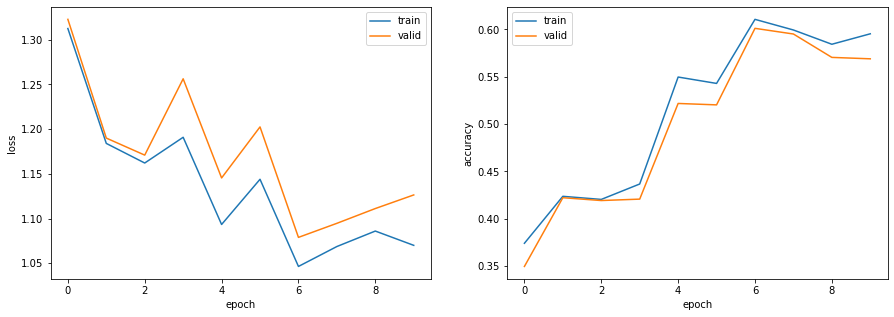

正解率（学習データ）：0.595
正解率（評価データ）：0.564


In [56]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

### #87の方

In [16]:
from torch.nn import functional as F

class CNN(nn.Module): #drop_rateを追加
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(out_channels, output_size)
    
  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [25]:
import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))
  num_eta_min = trial.suggest_loguniform('min_lr', 1e-5, 1e-1)#スケジューラの学習率の最小値



  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  KERNEL_HEIGHTS = 3
  STRIDE = 1
  PADDING = 1
  NUM_EPOCHS = 30

  # モデルの定義
  model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, out_channels, KERNEL_HEIGHTS, STRIDE, PADDING, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.device('cuda')


  return train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, num_eta_min, collate_fn=Padsequence(PADDING_IDX), device=device)[1][-1][0] #log_validの最後のlossを取得

In [26]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=10800)

[I 2022-01-31 16:48:34,155] A new study created in memory with name: no-name-0312d188-730e-4698-b7ec-e241b75396d8


epoch: 1, loss_train: 1.1358, accuracy_train: 0.5188, loss_valid: 1.1406, accuracy_valid: 0.5007, 7.8217sec
epoch: 2, loss_train: 1.1036, accuracy_train: 0.5410, loss_valid: 1.1138, accuracy_valid: 0.5232, 7.6566sec
epoch: 3, loss_train: 1.0814, accuracy_train: 0.5554, loss_valid: 1.0955, accuracy_valid: 0.5464, 7.6563sec
epoch: 4, loss_train: 1.0616, accuracy_train: 0.5715, loss_valid: 1.0787, accuracy_valid: 0.5726, 7.6903sec
epoch: 5, loss_train: 1.0417, accuracy_train: 0.5957, loss_valid: 1.0649, accuracy_valid: 0.5868, 7.5892sec
epoch: 6, loss_train: 1.0212, accuracy_train: 0.6204, loss_valid: 1.0487, accuracy_valid: 0.6048, 7.5920sec
epoch: 7, loss_train: 1.0002, accuracy_train: 0.6391, loss_valid: 1.0324, accuracy_valid: 0.6145, 7.5876sec
epoch: 8, loss_train: 0.9792, accuracy_train: 0.6470, loss_valid: 1.0137, accuracy_valid: 0.6280, 7.5635sec
epoch: 9, loss_train: 0.9586, accuracy_train: 0.6712, loss_valid: 0.9999, accuracy_valid: 0.6400, 7.5910sec
epoch: 10, loss_train: 0.938

[I 2022-01-31 16:52:25,348] Trial 0 finished with value: 0.8818090000813046 and parameters: {'emb_size': 400.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.008836280393119098, 'momentum': 0.7, 'batch_size': 128.0, 'min_lr': 1.7167070011707362e-05}. Best is trial 0 with value: 0.8818090000813046.


epoch: 30, loss_train: 0.7999, accuracy_train: 0.7372, loss_valid: 0.8818, accuracy_valid: 0.6946, 7.5836sec
epoch: 1, loss_train: 0.9902, accuracy_train: 0.6291, loss_valid: 1.0312, accuracy_valid: 0.6123, 8.0223sec
epoch: 2, loss_train: 0.8053, accuracy_train: 0.7239, loss_valid: 0.8935, accuracy_valid: 0.6811, 8.0484sec
epoch: 3, loss_train: 0.6821, accuracy_train: 0.7629, loss_valid: 0.8227, accuracy_valid: 0.6984, 8.0113sec
epoch: 4, loss_train: 0.5680, accuracy_train: 0.7983, loss_valid: 0.7452, accuracy_valid: 0.7290, 8.0022sec
epoch: 5, loss_train: 0.4816, accuracy_train: 0.8354, loss_valid: 0.7047, accuracy_valid: 0.7395, 8.0420sec
epoch: 6, loss_train: 0.4037, accuracy_train: 0.8643, loss_valid: 0.6428, accuracy_valid: 0.7657, 8.0142sec
epoch: 7, loss_train: 0.3373, accuracy_train: 0.8939, loss_valid: 0.6232, accuracy_valid: 0.7769, 8.0066sec
epoch: 8, loss_train: 0.2879, accuracy_train: 0.9341, loss_valid: 0.6080, accuracy_valid: 0.7912, 8.0246sec
epoch: 9, loss_train: 0.241

[I 2022-01-31 16:56:26,362] Trial 1 finished with value: 0.5095011624558584 and parameters: {'emb_size': 300.0, 'out_channels': 200.0, 'drop_rate': 0.2, 'learning_rate': 0.0057765845988047475, 'momentum': 0.9, 'batch_size': 32.0, 'min_lr': 0.0001821321531853565}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.0564, accuracy_train: 0.9983, loss_valid: 0.5095, accuracy_valid: 0.8256, 8.0664sec
epoch: 1, loss_train: 1.1277, accuracy_train: 0.5186, loss_valid: 1.1327, accuracy_valid: 0.5082, 7.5678sec
epoch: 2, loss_train: 1.0918, accuracy_train: 0.5402, loss_valid: 1.1051, accuracy_valid: 0.5329, 7.5746sec
epoch: 3, loss_train: 1.0661, accuracy_train: 0.5628, loss_valid: 1.0860, accuracy_valid: 0.5546, 7.6104sec
epoch: 4, loss_train: 1.0411, accuracy_train: 0.5833, loss_valid: 1.0680, accuracy_valid: 0.5801, 7.5831sec
epoch: 5, loss_train: 1.0143, accuracy_train: 0.6177, loss_valid: 1.0472, accuracy_valid: 0.6063, 7.5749sec
epoch: 6, loss_train: 0.9849, accuracy_train: 0.6424, loss_valid: 1.0235, accuracy_valid: 0.6243, 7.5854sec
epoch: 7, loss_train: 0.9550, accuracy_train: 0.6744, loss_valid: 1.0020, accuracy_valid: 0.6445, 7.5816sec
epoch: 8, loss_train: 0.9248, accuracy_train: 0.6784, loss_valid: 0.9764, accuracy_valid: 0.6534, 7.5666sec
epoch: 9, loss_train: 0.896

[I 2022-01-31 17:00:14,180] Trial 2 finished with value: 0.7648476798589792 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.004021579042206989, 'momentum': 0.9, 'batch_size': 128.0, 'min_lr': 0.0015716587334334354}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.6081, accuracy_train: 0.7864, loss_valid: 0.7648, accuracy_valid: 0.7343, 7.6025sec
epoch: 1, loss_train: 1.1602, accuracy_train: 0.5030, loss_valid: 1.1624, accuracy_valid: 0.4798, 7.6849sec
epoch: 2, loss_train: 1.1354, accuracy_train: 0.5140, loss_valid: 1.1419, accuracy_valid: 0.4978, 7.7180sec
epoch: 3, loss_train: 1.1183, accuracy_train: 0.5298, loss_valid: 1.1273, accuracy_valid: 0.5097, 7.6748sec
epoch: 4, loss_train: 1.1042, accuracy_train: 0.5377, loss_valid: 1.1169, accuracy_valid: 0.5150, 7.6709sec
epoch: 5, loss_train: 1.0926, accuracy_train: 0.5477, loss_valid: 1.1078, accuracy_valid: 0.5180, 7.7086sec
epoch: 6, loss_train: 1.0822, accuracy_train: 0.5554, loss_valid: 1.0999, accuracy_valid: 0.5314, 7.6893sec
epoch: 7, loss_train: 1.0727, accuracy_train: 0.5638, loss_valid: 1.0927, accuracy_valid: 0.5442, 7.6836sec
epoch: 8, loss_train: 1.0635, accuracy_train: 0.5684, loss_valid: 1.0854, accuracy_valid: 0.5472, 7.6997sec
epoch: 9, loss_train: 1.054

[I 2022-01-31 17:04:05,324] Trial 3 finished with value: 0.993278805930502 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.0017911099165667905, 'momentum': 0.8, 'batch_size': 80.0, 'min_lr': 0.0002916487869026352}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.9411, accuracy_train: 0.6758, loss_valid: 0.9933, accuracy_valid: 0.6415, 7.8641sec
epoch: 1, loss_train: 1.2233, accuracy_train: 0.4510, loss_valid: 1.2131, accuracy_valid: 0.4469, 7.6373sec
epoch: 2, loss_train: 1.1755, accuracy_train: 0.5041, loss_valid: 1.1716, accuracy_valid: 0.5022, 7.6517sec
epoch: 3, loss_train: 1.1516, accuracy_train: 0.5124, loss_valid: 1.1527, accuracy_valid: 0.5045, 7.6906sec
epoch: 4, loss_train: 1.1326, accuracy_train: 0.5187, loss_valid: 1.1374, accuracy_valid: 0.5112, 7.6878sec
epoch: 5, loss_train: 1.1159, accuracy_train: 0.5240, loss_valid: 1.1232, accuracy_valid: 0.5195, 7.6502sec
epoch: 6, loss_train: 1.1009, accuracy_train: 0.5339, loss_valid: 1.1116, accuracy_valid: 0.5284, 7.6597sec
epoch: 7, loss_train: 1.0860, accuracy_train: 0.5477, loss_valid: 1.1002, accuracy_valid: 0.5404, 7.6712sec
epoch: 8, loss_train: 1.0699, accuracy_train: 0.5581, loss_valid: 1.0869, accuracy_valid: 0.5531, 7.6623sec
epoch: 9, loss_train: 1.049

[I 2022-01-31 17:07:54,747] Trial 4 finished with value: 0.5916838077131745 and parameters: {'emb_size': 200.0, 'out_channels': 50.0, 'drop_rate': 0.5, 'learning_rate': 0.0006270272283580461, 'momentum': 0.9, 'batch_size': 96.0, 'min_lr': 0.012540551270501882}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.3076, accuracy_train: 0.9032, loss_valid: 0.5917, accuracy_valid: 0.7897, 7.6181sec
epoch: 1, loss_train: 1.3592, accuracy_train: 0.3804, loss_valid: 1.3557, accuracy_valid: 0.3840, 7.5481sec
epoch: 2, loss_train: 1.3048, accuracy_train: 0.3965, loss_valid: 1.2970, accuracy_valid: 0.3960, 7.5919sec
epoch: 3, loss_train: 1.2603, accuracy_train: 0.4029, loss_valid: 1.2507, accuracy_valid: 0.4057, 7.5879sec
epoch: 4, loss_train: 1.2254, accuracy_train: 0.4452, loss_valid: 1.2165, accuracy_valid: 0.4349, 7.5690sec
epoch: 5, loss_train: 1.1986, accuracy_train: 0.4953, loss_valid: 1.1924, accuracy_valid: 0.4678, 7.5802sec
epoch: 6, loss_train: 1.1780, accuracy_train: 0.5066, loss_valid: 1.1754, accuracy_valid: 0.4633, 7.6899sec
epoch: 7, loss_train: 1.1602, accuracy_train: 0.5110, loss_valid: 1.1613, accuracy_valid: 0.4775, 7.6026sec
epoch: 8, loss_train: 1.1435, accuracy_train: 0.5245, loss_valid: 1.1473, accuracy_valid: 0.5135, 7.6161sec
epoch: 9, loss_train: 1.128

[I 2022-01-31 17:11:42,856] Trial 5 finished with value: 0.7969816858286992 and parameters: {'emb_size': 400.0, 'out_channels': 50.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.0007994326594031405, 'momentum': 0.6, 'batch_size': 128.0, 'min_lr': 0.021219335579060392}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.6630, accuracy_train: 0.7689, loss_valid: 0.7970, accuracy_valid: 0.7133, 7.5748sec
epoch: 1, loss_train: 1.2082, accuracy_train: 0.4433, loss_valid: 1.2025, accuracy_valid: 0.4461, 7.7156sec
epoch: 2, loss_train: 1.1743, accuracy_train: 0.4819, loss_valid: 1.1721, accuracy_valid: 0.4723, 7.6627sec
epoch: 3, loss_train: 1.1599, accuracy_train: 0.5004, loss_valid: 1.1604, accuracy_valid: 0.4835, 7.6338sec
epoch: 4, loss_train: 1.1500, accuracy_train: 0.5025, loss_valid: 1.1522, accuracy_valid: 0.4828, 7.6293sec
epoch: 5, loss_train: 1.1418, accuracy_train: 0.5042, loss_valid: 1.1453, accuracy_valid: 0.4895, 7.6649sec
epoch: 6, loss_train: 1.1347, accuracy_train: 0.5067, loss_valid: 1.1395, accuracy_valid: 0.4925, 7.6354sec
epoch: 7, loss_train: 1.1286, accuracy_train: 0.5092, loss_valid: 1.1345, accuracy_valid: 0.4963, 7.6628sec
epoch: 8, loss_train: 1.1230, accuracy_train: 0.5132, loss_valid: 1.1297, accuracy_valid: 0.4993, 7.6555sec
epoch: 9, loss_train: 1.117

[I 2022-01-31 17:15:32,750] Trial 6 finished with value: 1.0918978473651195 and parameters: {'emb_size': 400.0, 'out_channels': 200.0, 'drop_rate': 0.1, 'learning_rate': 0.0007421840412830439, 'momentum': 0.8, 'batch_size': 96.0, 'min_lr': 0.00021054234335148627}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 1.0737, accuracy_train: 0.5564, loss_valid: 1.0919, accuracy_valid: 0.5457, 7.6466sec
epoch: 1, loss_train: 1.1565, accuracy_train: 0.4985, loss_valid: 1.1594, accuracy_valid: 0.4738, 7.7234sec
epoch: 2, loss_train: 1.1264, accuracy_train: 0.5170, loss_valid: 1.1331, accuracy_valid: 0.4948, 7.7420sec
epoch: 3, loss_train: 1.1073, accuracy_train: 0.5317, loss_valid: 1.1178, accuracy_valid: 0.5165, 7.7402sec
epoch: 4, loss_train: 1.0931, accuracy_train: 0.5405, loss_valid: 1.1067, accuracy_valid: 0.5314, 7.7723sec
epoch: 5, loss_train: 1.0803, accuracy_train: 0.5527, loss_valid: 1.0975, accuracy_valid: 0.5427, 7.7224sec
epoch: 6, loss_train: 1.0683, accuracy_train: 0.5586, loss_valid: 1.0878, accuracy_valid: 0.5479, 7.7257sec
epoch: 7, loss_train: 1.0562, accuracy_train: 0.5697, loss_valid: 1.0794, accuracy_valid: 0.5614, 7.7341sec
epoch: 8, loss_train: 1.0445, accuracy_train: 0.5782, loss_valid: 1.0709, accuracy_valid: 0.5696, 7.7322sec
epoch: 9, loss_train: 1.032

[I 2022-01-31 17:19:24,940] Trial 7 finished with value: 0.9628207478114588 and parameters: {'emb_size': 400.0, 'out_channels': 150.0, 'drop_rate': 0.0, 'learning_rate': 0.0008300107872692856, 'momentum': 0.9, 'batch_size': 64.0, 'min_lr': 9.626297774270316e-05}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.9002, accuracy_train: 0.6929, loss_valid: 0.9628, accuracy_valid: 0.6587, 7.7257sec
epoch: 1, loss_train: 1.3595, accuracy_train: 0.3955, loss_valid: 1.3483, accuracy_valid: 0.3960, 7.5930sec
epoch: 2, loss_train: 1.2966, accuracy_train: 0.3961, loss_valid: 1.2823, accuracy_valid: 0.3975, 7.6555sec
epoch: 3, loss_train: 1.2563, accuracy_train: 0.3993, loss_valid: 1.2421, accuracy_valid: 0.3997, 7.6142sec
epoch: 4, loss_train: 1.2302, accuracy_train: 0.4175, loss_valid: 1.2177, accuracy_valid: 0.4192, 7.5946sec
epoch: 5, loss_train: 1.2124, accuracy_train: 0.4542, loss_valid: 1.2021, accuracy_valid: 0.4401, 7.6468sec
epoch: 6, loss_train: 1.1995, accuracy_train: 0.4872, loss_valid: 1.1915, accuracy_valid: 0.4611, 7.5961sec
epoch: 7, loss_train: 1.1896, accuracy_train: 0.5040, loss_valid: 1.1837, accuracy_valid: 0.4805, 7.6083sec
epoch: 8, loss_train: 1.1816, accuracy_train: 0.5125, loss_valid: 1.1773, accuracy_valid: 0.4903, 7.6132sec
epoch: 9, loss_train: 1.174

[I 2022-01-31 17:23:13,726] Trial 8 finished with value: 1.139564038014519 and parameters: {'emb_size': 300.0, 'out_channels': 50.0, 'drop_rate': 0.2, 'learning_rate': 0.001101039582957652, 'momentum': 0.5, 'batch_size': 112.0, 'min_lr': 1.660785840601899e-05}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 1.1356, accuracy_train: 0.5222, loss_valid: 1.1396, accuracy_valid: 0.5052, 7.6209sec
epoch: 1, loss_train: 1.0876, accuracy_train: 0.5306, loss_valid: 1.1019, accuracy_valid: 0.5165, 8.5753sec
epoch: 2, loss_train: 1.0320, accuracy_train: 0.5899, loss_valid: 1.0581, accuracy_valid: 0.5823, 8.5701sec
epoch: 3, loss_train: 0.9623, accuracy_train: 0.6622, loss_valid: 1.0021, accuracy_valid: 0.6407, 8.5782sec
epoch: 4, loss_train: 0.8922, accuracy_train: 0.6998, loss_valid: 0.9490, accuracy_valid: 0.6737, 8.6093sec
epoch: 5, loss_train: 0.8335, accuracy_train: 0.7216, loss_valid: 0.9027, accuracy_valid: 0.6879, 8.5929sec
epoch: 6, loss_train: 0.7837, accuracy_train: 0.7352, loss_valid: 0.8688, accuracy_valid: 0.6961, 8.5889sec
epoch: 7, loss_train: 0.7422, accuracy_train: 0.7427, loss_valid: 0.8429, accuracy_valid: 0.6946, 8.5974sec
epoch: 8, loss_train: 0.7002, accuracy_train: 0.7578, loss_valid: 0.8152, accuracy_valid: 0.7096, 8.5844sec
epoch: 9, loss_train: 0.666

[I 2022-01-31 17:27:31,559] Trial 9 finished with value: 0.6712489003305068 and parameters: {'emb_size': 100.0, 'out_channels': 50.0, 'drop_rate': 0.4, 'learning_rate': 0.004665862581604787, 'momentum': 0.6, 'batch_size': 16.0, 'min_lr': 1.1779786812023121e-05}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.4444, accuracy_train: 0.8523, loss_valid: 0.6712, accuracy_valid: 0.7590, 8.6017sec
epoch: 1, loss_train: 0.5890, accuracy_train: 0.8005, loss_valid: 0.7626, accuracy_valid: 0.7305, 8.6854sec
epoch: 2, loss_train: 0.3515, accuracy_train: 0.9016, loss_valid: 0.6798, accuracy_valid: 0.7590, 8.6036sec
epoch: 3, loss_train: 0.1852, accuracy_train: 0.9513, loss_valid: 0.6146, accuracy_valid: 0.7882, 8.6094sec
epoch: 4, loss_train: 0.1088, accuracy_train: 0.9707, loss_valid: 0.6113, accuracy_valid: 0.8031, 8.6410sec
epoch: 5, loss_train: 0.0719, accuracy_train: 0.9827, loss_valid: 0.6209, accuracy_valid: 0.8084, 8.5799sec
epoch: 6, loss_train: 0.0378, accuracy_train: 0.9933, loss_valid: 0.6183, accuracy_valid: 0.8099, 8.5970sec
epoch: 7, loss_train: 0.0305, accuracy_train: 0.9948, loss_valid: 0.6099, accuracy_valid: 0.8234, 8.6153sec
epoch: 8, loss_train: 0.0267, accuracy_train: 0.9952, loss_valid: 0.6508, accuracy_valid: 0.8106, 8.6200sec
epoch: 9, loss_train: 0.016

[I 2022-01-31 17:29:49,459] Trial 10 finished with value: 0.6575050162577178 and parameters: {'emb_size': 300.0, 'out_channels': 100.0, 'drop_rate': 0.1, 'learning_rate': 0.046193756543585235, 'momentum': 0.8, 'batch_size': 16.0, 'min_lr': 0.002912144027573002}. Best is trial 1 with value: 0.5095011624558584.


epoch: 16, loss_train: 0.0082, accuracy_train: 0.9986, loss_valid: 0.6575, accuracy_valid: 0.8308, 8.6055sec
epoch: 1, loss_train: 0.8702, accuracy_train: 0.6948, loss_valid: 0.9305, accuracy_valid: 0.6587, 7.8314sec
epoch: 2, loss_train: 0.6627, accuracy_train: 0.7658, loss_valid: 0.7957, accuracy_valid: 0.7133, 7.8772sec
epoch: 3, loss_train: 0.5206, accuracy_train: 0.8335, loss_valid: 0.7219, accuracy_valid: 0.7522, 7.8457sec
epoch: 4, loss_train: 0.3897, accuracy_train: 0.8596, loss_valid: 0.6336, accuracy_valid: 0.7672, 7.8405sec
epoch: 5, loss_train: 0.2869, accuracy_train: 0.9267, loss_valid: 0.6037, accuracy_valid: 0.7912, 7.8630sec
epoch: 6, loss_train: 0.2100, accuracy_train: 0.9460, loss_valid: 0.5596, accuracy_valid: 0.8091, 7.8246sec
epoch: 7, loss_train: 0.1541, accuracy_train: 0.9662, loss_valid: 0.5321, accuracy_valid: 0.8181, 7.8189sec
epoch: 8, loss_train: 0.1103, accuracy_train: 0.9817, loss_valid: 0.5308, accuracy_valid: 0.8256, 7.8263sec
epoch: 9, loss_train: 0.079

[I 2022-01-31 17:31:39,362] Trial 11 finished with value: 0.577805063531976 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.2, 'learning_rate': 0.016225874528430412, 'momentum': 0.9, 'batch_size': 48.0, 'min_lr': 0.07060268770757462}. Best is trial 1 with value: 0.5095011624558584.


epoch: 14, loss_train: 0.0439, accuracy_train: 0.9917, loss_valid: 0.5778, accuracy_valid: 0.8189, 7.8663sec
epoch: 1, loss_train: 0.8751, accuracy_train: 0.6992, loss_valid: 0.9330, accuracy_valid: 0.6722, 7.8517sec
epoch: 2, loss_train: 0.6647, accuracy_train: 0.7632, loss_valid: 0.7958, accuracy_valid: 0.7058, 7.8796sec
epoch: 3, loss_train: 0.5039, accuracy_train: 0.8224, loss_valid: 0.6993, accuracy_valid: 0.7448, 7.8587sec
epoch: 4, loss_train: 0.3853, accuracy_train: 0.8737, loss_valid: 0.6435, accuracy_valid: 0.7642, 7.8639sec
epoch: 5, loss_train: 0.2969, accuracy_train: 0.9016, loss_valid: 0.6171, accuracy_valid: 0.7695, 7.8700sec
epoch: 6, loss_train: 0.2201, accuracy_train: 0.9525, loss_valid: 0.5784, accuracy_valid: 0.8076, 7.8643sec
epoch: 7, loss_train: 0.1736, accuracy_train: 0.9702, loss_valid: 0.5897, accuracy_valid: 0.7942, 7.8654sec
epoch: 8, loss_train: 0.1182, accuracy_train: 0.9833, loss_valid: 0.5587, accuracy_valid: 0.8076, 7.8624sec
epoch: 9, loss_train: 0.089

[I 2022-01-31 17:33:53,008] Trial 12 finished with value: 0.6105827802675257 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.2, 'learning_rate': 0.01580415182869161, 'momentum': 0.9, 'batch_size': 48.0, 'min_lr': 0.04959144776482051}. Best is trial 1 with value: 0.5095011624558584.


epoch: 17, loss_train: 0.0282, accuracy_train: 0.9957, loss_valid: 0.6106, accuracy_valid: 0.8159, 7.8293sec
epoch: 1, loss_train: 0.9085, accuracy_train: 0.6835, loss_valid: 0.9642, accuracy_valid: 0.6422, 7.8504sec
epoch: 2, loss_train: 0.7177, accuracy_train: 0.7491, loss_valid: 0.8355, accuracy_valid: 0.6886, 7.9042sec
epoch: 3, loss_train: 0.5770, accuracy_train: 0.8096, loss_valid: 0.7591, accuracy_valid: 0.7313, 7.8365sec
epoch: 4, loss_train: 0.4589, accuracy_train: 0.8465, loss_valid: 0.6898, accuracy_valid: 0.7515, 7.8552sec
epoch: 5, loss_train: 0.3806, accuracy_train: 0.8797, loss_valid: 0.6713, accuracy_valid: 0.7590, 7.8379sec
epoch: 6, loss_train: 0.2955, accuracy_train: 0.9150, loss_valid: 0.6184, accuracy_valid: 0.7874, 7.8576sec
epoch: 7, loss_train: 0.2286, accuracy_train: 0.9495, loss_valid: 0.5953, accuracy_valid: 0.7987, 7.8467sec
epoch: 8, loss_train: 0.1924, accuracy_train: 0.9616, loss_valid: 0.5980, accuracy_valid: 0.7942, 7.8567sec
epoch: 9, loss_train: 0.151

[I 2022-01-31 17:36:53,882] Trial 13 finished with value: 0.5553046786759744 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.1, 'learning_rate': 0.024433578617988245, 'momentum': 0.8, 'batch_size': 48.0, 'min_lr': 0.005430564724241327}. Best is trial 1 with value: 0.5095011624558584.


epoch: 23, loss_train: 0.0277, accuracy_train: 0.9990, loss_valid: 0.5553, accuracy_valid: 0.8151, 7.9556sec
epoch: 1, loss_train: 0.8277, accuracy_train: 0.7105, loss_valid: 0.9254, accuracy_valid: 0.6564, 8.0672sec
epoch: 2, loss_train: 0.5972, accuracy_train: 0.7797, loss_valid: 0.7576, accuracy_valid: 0.7290, 8.0776sec
epoch: 3, loss_train: 0.4234, accuracy_train: 0.8556, loss_valid: 0.6544, accuracy_valid: 0.7567, 8.0896sec
epoch: 4, loss_train: 0.2888, accuracy_train: 0.9293, loss_valid: 0.6115, accuracy_valid: 0.7927, 8.1108sec
epoch: 5, loss_train: 0.2017, accuracy_train: 0.9688, loss_valid: 0.5898, accuracy_valid: 0.8031, 8.0585sec
epoch: 6, loss_train: 0.1411, accuracy_train: 0.9825, loss_valid: 0.5832, accuracy_valid: 0.7964, 8.0656sec
epoch: 7, loss_train: 0.0946, accuracy_train: 0.9920, loss_valid: 0.5610, accuracy_valid: 0.8159, 8.0907sec
epoch: 8, loss_train: 0.0694, accuracy_train: 0.9954, loss_valid: 0.5600, accuracy_valid: 0.8219, 8.0566sec
epoch: 9, loss_train: 0.051

[I 2022-01-31 17:38:47,053] Trial 14 finished with value: 0.570156206202231 and parameters: {'emb_size': 300.0, 'out_channels': 200.0, 'drop_rate': 0.0, 'learning_rate': 0.03273922668605318, 'momentum': 0.7, 'batch_size': 32.0, 'min_lr': 0.005564858428568574}. Best is trial 1 with value: 0.5095011624558584.


epoch: 14, loss_train: 0.0221, accuracy_train: 0.9992, loss_valid: 0.5702, accuracy_valid: 0.8211, 8.0681sec
epoch: 1, loss_train: 1.0591, accuracy_train: 0.5718, loss_valid: 1.0833, accuracy_valid: 0.5636, 7.8997sec
epoch: 2, loss_train: 0.9569, accuracy_train: 0.6717, loss_valid: 1.0076, accuracy_valid: 0.6243, 7.8829sec
epoch: 3, loss_train: 0.8477, accuracy_train: 0.7147, loss_valid: 0.9198, accuracy_valid: 0.6796, 7.9204sec
epoch: 4, loss_train: 0.7634, accuracy_train: 0.7441, loss_valid: 0.8628, accuracy_valid: 0.6999, 7.8834sec
epoch: 5, loss_train: 0.6978, accuracy_train: 0.7617, loss_valid: 0.8358, accuracy_valid: 0.7088, 7.8851sec
epoch: 6, loss_train: 0.6343, accuracy_train: 0.7762, loss_valid: 0.7795, accuracy_valid: 0.7246, 7.8852sec
epoch: 7, loss_train: 0.5782, accuracy_train: 0.7943, loss_valid: 0.7499, accuracy_valid: 0.7350, 7.9069sec
epoch: 8, loss_train: 0.5291, accuracy_train: 0.8158, loss_valid: 0.7263, accuracy_valid: 0.7507, 7.8790sec
epoch: 9, loss_train: 0.486

[I 2022-01-31 17:42:43,302] Trial 15 finished with value: 0.5584727670585301 and parameters: {'emb_size': 200.0, 'out_channels': 150.0, 'drop_rate': 0.1, 'learning_rate': 0.009305447406279976, 'momentum': 0.8, 'batch_size': 48.0, 'min_lr': 0.0007232998112143536}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.1941, accuracy_train: 0.9655, loss_valid: 0.5585, accuracy_valid: 0.8129, 7.8504sec
epoch: 1, loss_train: 1.1208, accuracy_train: 0.5156, loss_valid: 1.1291, accuracy_valid: 0.5075, 8.0532sec
epoch: 2, loss_train: 1.0855, accuracy_train: 0.5444, loss_valid: 1.1006, accuracy_valid: 0.5427, 8.0411sec
epoch: 3, loss_train: 1.0559, accuracy_train: 0.5686, loss_valid: 1.0790, accuracy_valid: 0.5666, 8.0643sec
epoch: 4, loss_train: 1.0247, accuracy_train: 0.5931, loss_valid: 1.0559, accuracy_valid: 0.5838, 8.0460sec
epoch: 5, loss_train: 0.9893, accuracy_train: 0.6396, loss_valid: 1.0269, accuracy_valid: 0.6115, 8.0444sec
epoch: 6, loss_train: 0.9544, accuracy_train: 0.6723, loss_valid: 1.0017, accuracy_valid: 0.6430, 8.0220sec
epoch: 7, loss_train: 0.9170, accuracy_train: 0.6867, loss_valid: 0.9717, accuracy_valid: 0.6542, 8.0411sec
epoch: 8, loss_train: 0.8851, accuracy_train: 0.7005, loss_valid: 0.9497, accuracy_valid: 0.6647, 8.0550sec
epoch: 9, loss_train: 0.853

[I 2022-01-31 17:46:44,605] Trial 16 finished with value: 0.7927281645720569 and parameters: {'emb_size': 300.0, 'out_channels': 100.0, 'drop_rate': 0.1, 'learning_rate': 0.0021273777363322076, 'momentum': 0.8, 'batch_size': 32.0, 'min_lr': 8.47494549233735e-05}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.6484, accuracy_train: 0.7751, loss_valid: 0.7927, accuracy_valid: 0.7178, 8.0268sec
epoch: 1, loss_train: 1.0378, accuracy_train: 0.5824, loss_valid: 1.0650, accuracy_valid: 0.5741, 7.7424sec
epoch: 2, loss_train: 0.9047, accuracy_train: 0.6957, loss_valid: 0.9577, accuracy_valid: 0.6639, 7.7656sec
epoch: 3, loss_train: 0.7877, accuracy_train: 0.7341, loss_valid: 0.8757, accuracy_valid: 0.6939, 7.7682sec
epoch: 4, loss_train: 0.7066, accuracy_train: 0.7533, loss_valid: 0.8199, accuracy_valid: 0.7103, 7.7413sec
epoch: 5, loss_train: 0.6175, accuracy_train: 0.7866, loss_valid: 0.7734, accuracy_valid: 0.7305, 7.7521sec
epoch: 6, loss_train: 0.5467, accuracy_train: 0.8057, loss_valid: 0.7229, accuracy_valid: 0.7388, 7.7833sec
epoch: 7, loss_train: 0.4894, accuracy_train: 0.8469, loss_valid: 0.6978, accuracy_valid: 0.7657, 7.7673sec
epoch: 8, loss_train: 0.4366, accuracy_train: 0.8612, loss_valid: 0.6639, accuracy_valid: 0.7732, 7.7265sec
epoch: 9, loss_train: 0.388

[I 2022-01-31 17:50:37,381] Trial 17 finished with value: 0.5127874283613707 and parameters: {'emb_size': 200.0, 'out_channels': 200.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.024196779847072664, 'momentum': 0.7, 'batch_size': 64.0, 'min_lr': 0.0012621455157029767}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.1330, accuracy_train: 0.9858, loss_valid: 0.5128, accuracy_valid: 0.8226, 7.7651sec
epoch: 1, loss_train: 1.1215, accuracy_train: 0.5335, loss_valid: 1.1306, accuracy_valid: 0.5150, 7.7754sec
epoch: 2, loss_train: 1.0863, accuracy_train: 0.5405, loss_valid: 1.1000, accuracy_valid: 0.5314, 7.7724sec
epoch: 3, loss_train: 1.0589, accuracy_train: 0.5758, loss_valid: 1.0825, accuracy_valid: 0.5636, 7.7419sec
epoch: 4, loss_train: 1.0313, accuracy_train: 0.6007, loss_valid: 1.0637, accuracy_valid: 0.5681, 7.7581sec
epoch: 5, loss_train: 1.0001, accuracy_train: 0.6313, loss_valid: 1.0389, accuracy_valid: 0.6085, 7.7898sec
epoch: 6, loss_train: 0.9678, accuracy_train: 0.6654, loss_valid: 1.0126, accuracy_valid: 0.6310, 7.7611sec
epoch: 7, loss_train: 0.9354, accuracy_train: 0.6872, loss_valid: 0.9889, accuracy_valid: 0.6437, 7.7589sec
epoch: 8, loss_train: 0.9033, accuracy_train: 0.6989, loss_valid: 0.9654, accuracy_valid: 0.6564, 7.8414sec
epoch: 9, loss_train: 0.873

[I 2022-01-31 17:54:30,556] Trial 18 finished with value: 0.8009571421100767 and parameters: {'emb_size': 300.0, 'out_channels': 200.0, 'drop_rate': 0.4, 'learning_rate': 0.008373318955056558, 'momentum': 0.6, 'batch_size': 64.0, 'min_lr': 0.0005706182496548706}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.6583, accuracy_train: 0.7735, loss_valid: 0.8010, accuracy_valid: 0.7201, 7.7650sec
epoch: 1, loss_train: 1.1640, accuracy_train: 0.4876, loss_valid: 1.1661, accuracy_valid: 0.4581, 7.6947sec
epoch: 2, loss_train: 1.1389, accuracy_train: 0.5102, loss_valid: 1.1444, accuracy_valid: 0.4978, 7.6880sec
epoch: 3, loss_train: 1.1212, accuracy_train: 0.5178, loss_valid: 1.1292, accuracy_valid: 0.5045, 7.7121sec
epoch: 4, loss_train: 1.1071, accuracy_train: 0.5282, loss_valid: 1.1185, accuracy_valid: 0.5120, 7.6972sec
epoch: 5, loss_train: 1.0957, accuracy_train: 0.5370, loss_valid: 1.1095, accuracy_valid: 0.5307, 7.7007sec
epoch: 6, loss_train: 1.0853, accuracy_train: 0.5449, loss_valid: 1.1025, accuracy_valid: 0.5269, 7.7034sec
epoch: 7, loss_train: 1.0762, accuracy_train: 0.5536, loss_valid: 1.0960, accuracy_valid: 0.5419, 7.7365sec
epoch: 8, loss_train: 1.0674, accuracy_train: 0.5606, loss_valid: 1.0896, accuracy_valid: 0.5464, 7.7030sec
epoch: 9, loss_train: 1.059

[I 2022-01-31 17:58:22,323] Trial 19 finished with value: 1.0193180193856894 and parameters: {'emb_size': 200.0, 'out_channels': 200.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.002548285120861104, 'momentum': 0.7, 'batch_size': 80.0, 'min_lr': 6.637479196228411e-05}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.9753, accuracy_train: 0.6507, loss_valid: 1.0193, accuracy_valid: 0.6243, 7.7102sec
epoch: 1, loss_train: 1.0669, accuracy_train: 0.5734, loss_valid: 1.0903, accuracy_valid: 0.5307, 8.0856sec
epoch: 2, loss_train: 0.9796, accuracy_train: 0.6474, loss_valid: 1.0217, accuracy_valid: 0.6123, 8.1376sec
epoch: 3, loss_train: 0.8843, accuracy_train: 0.7029, loss_valid: 0.9500, accuracy_valid: 0.6692, 8.1557sec
epoch: 4, loss_train: 0.8038, accuracy_train: 0.7335, loss_valid: 0.8909, accuracy_valid: 0.6939, 8.0536sec
epoch: 5, loss_train: 0.7385, accuracy_train: 0.7504, loss_valid: 0.8445, accuracy_valid: 0.7058, 8.0675sec
epoch: 6, loss_train: 0.6802, accuracy_train: 0.7654, loss_valid: 0.8011, accuracy_valid: 0.7148, 8.1034sec
epoch: 7, loss_train: 0.6296, accuracy_train: 0.7820, loss_valid: 0.7744, accuracy_valid: 0.7275, 8.0232sec
epoch: 8, loss_train: 0.5832, accuracy_train: 0.7916, loss_valid: 0.7439, accuracy_valid: 0.7418, 8.0568sec
epoch: 9, loss_train: 0.540

[I 2022-01-31 18:02:24,382] Trial 20 finished with value: 0.5592491326081344 and parameters: {'emb_size': 300.0, 'out_channels': 200.0, 'drop_rate': 0.4, 'learning_rate': 0.014146758506574153, 'momentum': 0.5, 'batch_size': 32.0, 'min_lr': 0.0016186326235746065}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.2421, accuracy_train: 0.9437, loss_valid: 0.5592, accuracy_valid: 0.8129, 8.0686sec
epoch: 1, loss_train: 0.9584, accuracy_train: 0.6585, loss_valid: 0.9958, accuracy_valid: 0.6310, 7.7366sec
epoch: 2, loss_train: 0.7717, accuracy_train: 0.7304, loss_valid: 0.8748, accuracy_valid: 0.6901, 7.7312sec
epoch: 3, loss_train: 0.6336, accuracy_train: 0.7808, loss_valid: 0.7796, accuracy_valid: 0.7298, 7.7531sec
epoch: 4, loss_train: 0.5200, accuracy_train: 0.8195, loss_valid: 0.7118, accuracy_valid: 0.7560, 7.7392sec
epoch: 5, loss_train: 0.4301, accuracy_train: 0.8501, loss_valid: 0.6673, accuracy_valid: 0.7597, 7.7222sec
epoch: 6, loss_train: 0.3537, accuracy_train: 0.8940, loss_valid: 0.6398, accuracy_valid: 0.7792, 7.7321sec
epoch: 7, loss_train: 0.2915, accuracy_train: 0.9074, loss_valid: 0.5910, accuracy_valid: 0.7957, 7.7456sec
epoch: 8, loss_train: 0.2408, accuracy_train: 0.9469, loss_valid: 0.5835, accuracy_valid: 0.7994, 7.7115sec
epoch: 9, loss_train: 0.202

[I 2022-01-31 18:06:16,862] Trial 21 finished with value: 0.5141643922685786 and parameters: {'emb_size': 200.0, 'out_channels': 150.0, 'drop_rate': 0.2, 'learning_rate': 0.026844793240436485, 'momentum': 0.8, 'batch_size': 64.0, 'min_lr': 0.0031597075858574237}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.0376, accuracy_train: 0.9984, loss_valid: 0.5142, accuracy_valid: 0.8278, 7.7583sec
epoch: 1, loss_train: 1.0439, accuracy_train: 0.5647, loss_valid: 1.0713, accuracy_valid: 0.5546, 7.7278sec
epoch: 2, loss_train: 0.9112, accuracy_train: 0.6892, loss_valid: 0.9725, accuracy_valid: 0.6534, 7.7697sec
epoch: 3, loss_train: 0.7956, accuracy_train: 0.7305, loss_valid: 0.8821, accuracy_valid: 0.6811, 7.7270sec
epoch: 4, loss_train: 0.7028, accuracy_train: 0.7615, loss_valid: 0.8230, accuracy_valid: 0.7081, 7.7315sec
epoch: 5, loss_train: 0.6285, accuracy_train: 0.7906, loss_valid: 0.7859, accuracy_valid: 0.7216, 7.7492sec
epoch: 6, loss_train: 0.5586, accuracy_train: 0.8157, loss_valid: 0.7452, accuracy_valid: 0.7433, 7.6991sec
epoch: 7, loss_train: 0.4980, accuracy_train: 0.8314, loss_valid: 0.7085, accuracy_valid: 0.7545, 7.7117sec
epoch: 8, loss_train: 0.4454, accuracy_train: 0.8490, loss_valid: 0.6708, accuracy_valid: 0.7560, 7.7773sec
epoch: 9, loss_train: 0.399

[I 2022-01-31 18:10:09,180] Trial 22 finished with value: 0.5338739498311941 and parameters: {'emb_size': 200.0, 'out_channels': 150.0, 'drop_rate': 0.2, 'learning_rate': 0.023587072570090524, 'momentum': 0.7, 'batch_size': 64.0, 'min_lr': 0.00027720024762362784}. Best is trial 1 with value: 0.5095011624558584.


epoch: 30, loss_train: 0.1479, accuracy_train: 0.9799, loss_valid: 0.5339, accuracy_valid: 0.8106, 7.7569sec
epoch: 1, loss_train: 0.9105, accuracy_train: 0.6872, loss_valid: 0.9674, accuracy_valid: 0.6504, 7.7568sec
epoch: 2, loss_train: 0.6989, accuracy_train: 0.7590, loss_valid: 0.8245, accuracy_valid: 0.7126, 7.7004sec
epoch: 3, loss_train: 0.5588, accuracy_train: 0.7932, loss_valid: 0.7366, accuracy_valid: 0.7178, 7.7306sec
epoch: 4, loss_train: 0.4505, accuracy_train: 0.8591, loss_valid: 0.6819, accuracy_valid: 0.7605, 7.7222sec
epoch: 5, loss_train: 0.3426, accuracy_train: 0.8857, loss_valid: 0.6217, accuracy_valid: 0.7710, 7.7022sec
epoch: 6, loss_train: 0.2669, accuracy_train: 0.9212, loss_valid: 0.5795, accuracy_valid: 0.7979, 7.7052sec
epoch: 7, loss_train: 0.2085, accuracy_train: 0.9484, loss_valid: 0.5579, accuracy_valid: 0.8024, 7.7291sec
epoch: 8, loss_train: 0.1593, accuracy_train: 0.9751, loss_valid: 0.5361, accuracy_valid: 0.8054, 7.7090sec
epoch: 9, loss_train: 0.127

[I 2022-01-31 18:12:36,010] Trial 23 finished with value: 0.506948028830008 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.04421981048677404, 'momentum': 0.8, 'batch_size': 80.0, 'min_lr': 0.004006586815817821}. Best is trial 23 with value: 0.506948028830008.


epoch: 19, loss_train: 0.0319, accuracy_train: 0.9985, loss_valid: 0.5069, accuracy_valid: 0.8353, 7.7206sec
epoch: 1, loss_train: 0.8799, accuracy_train: 0.6950, loss_valid: 0.9492, accuracy_valid: 0.6549, 7.6419sec
epoch: 2, loss_train: 0.6574, accuracy_train: 0.7688, loss_valid: 0.8074, accuracy_valid: 0.7036, 7.6617sec
epoch: 3, loss_train: 0.4980, accuracy_train: 0.8193, loss_valid: 0.7178, accuracy_valid: 0.7448, 7.6694sec
epoch: 4, loss_train: 0.3820, accuracy_train: 0.8763, loss_valid: 0.6625, accuracy_valid: 0.7747, 7.6802sec
epoch: 5, loss_train: 0.2825, accuracy_train: 0.9298, loss_valid: 0.6215, accuracy_valid: 0.7814, 7.6592sec
epoch: 6, loss_train: 0.2037, accuracy_train: 0.9549, loss_valid: 0.5689, accuracy_valid: 0.8114, 7.6587sec
epoch: 7, loss_train: 0.1702, accuracy_train: 0.9669, loss_valid: 0.5826, accuracy_valid: 0.8046, 7.6795sec
epoch: 8, loss_train: 0.1170, accuracy_train: 0.9817, loss_valid: 0.5303, accuracy_valid: 0.8234, 7.6712sec
epoch: 9, loss_train: 0.088

[I 2022-01-31 18:16:26,092] Trial 24 finished with value: 0.5316391878615848 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.032935602901594384, 'momentum': 0.9, 'batch_size': 96.0, 'min_lr': 0.014556980263808469}. Best is trial 23 with value: 0.506948028830008.


epoch: 30, loss_train: 0.0102, accuracy_train: 0.9992, loss_valid: 0.5316, accuracy_valid: 0.8346, 7.6556sec
epoch: 1, loss_train: 1.0031, accuracy_train: 0.6570, loss_valid: 1.0392, accuracy_valid: 0.6123, 7.6925sec
epoch: 2, loss_train: 0.8380, accuracy_train: 0.7202, loss_valid: 0.9147, accuracy_valid: 0.6819, 7.7419sec
epoch: 3, loss_train: 0.7195, accuracy_train: 0.7529, loss_valid: 0.8361, accuracy_valid: 0.6886, 7.7069sec
epoch: 4, loss_train: 0.6252, accuracy_train: 0.7756, loss_valid: 0.7797, accuracy_valid: 0.7118, 7.6545sec
epoch: 5, loss_train: 0.5376, accuracy_train: 0.8186, loss_valid: 0.7333, accuracy_valid: 0.7425, 7.6868sec
epoch: 6, loss_train: 0.4598, accuracy_train: 0.8480, loss_valid: 0.6824, accuracy_valid: 0.7612, 7.7120sec
epoch: 7, loss_train: 0.3943, accuracy_train: 0.8717, loss_valid: 0.6405, accuracy_valid: 0.7754, 7.7305sec
epoch: 8, loss_train: 0.3477, accuracy_train: 0.8944, loss_valid: 0.6134, accuracy_valid: 0.7874, 7.6951sec
epoch: 9, loss_train: 0.307

[I 2022-01-31 18:20:17,585] Trial 25 finished with value: 0.4914871058913727 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.4, 'learning_rate': 0.039763717021454634, 'momentum': 0.7, 'batch_size': 80.0, 'min_lr': 0.0008468303698464773}. Best is trial 25 with value: 0.4914871058913727.


epoch: 30, loss_train: 0.0861, accuracy_train: 0.9959, loss_valid: 0.4915, accuracy_valid: 0.8406, 7.7313sec
epoch: 1, loss_train: 1.0312, accuracy_train: 0.5768, loss_valid: 1.0546, accuracy_valid: 0.5599, 7.6852sec
epoch: 2, loss_train: 0.8939, accuracy_train: 0.6919, loss_valid: 0.9534, accuracy_valid: 0.6549, 7.8255sec
epoch: 3, loss_train: 0.7793, accuracy_train: 0.7430, loss_valid: 0.8741, accuracy_valid: 0.6999, 7.7267sec
epoch: 4, loss_train: 0.6909, accuracy_train: 0.7641, loss_valid: 0.8094, accuracy_valid: 0.7163, 7.7225sec
epoch: 5, loss_train: 0.6131, accuracy_train: 0.7858, loss_valid: 0.7708, accuracy_valid: 0.7328, 7.6927sec
epoch: 6, loss_train: 0.5441, accuracy_train: 0.8081, loss_valid: 0.7297, accuracy_valid: 0.7335, 7.7052sec
epoch: 7, loss_train: 0.4865, accuracy_train: 0.8277, loss_valid: 0.6950, accuracy_valid: 0.7455, 7.7061sec
epoch: 8, loss_train: 0.4319, accuracy_train: 0.8537, loss_valid: 0.6633, accuracy_valid: 0.7635, 7.7074sec
epoch: 9, loss_train: 0.391

[I 2022-01-31 18:24:09,296] Trial 26 finished with value: 0.5102919341657758 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.4, 'learning_rate': 0.04279079773346237, 'momentum': 0.6, 'batch_size': 80.0, 'min_lr': 0.0003818101968042539}. Best is trial 25 with value: 0.4914871058913727.


epoch: 30, loss_train: 0.1370, accuracy_train: 0.9838, loss_valid: 0.5103, accuracy_valid: 0.8308, 7.7330sec
epoch: 1, loss_train: 1.1271, accuracy_train: 0.5226, loss_valid: 1.1330, accuracy_valid: 0.5105, 7.6891sec
epoch: 2, loss_train: 1.0934, accuracy_train: 0.5296, loss_valid: 1.1048, accuracy_valid: 0.5232, 7.6591sec
epoch: 3, loss_train: 1.0660, accuracy_train: 0.5572, loss_valid: 1.0842, accuracy_valid: 0.5561, 7.5955sec
epoch: 4, loss_train: 1.0384, accuracy_train: 0.5945, loss_valid: 1.0630, accuracy_valid: 0.5853, 7.5963sec
epoch: 5, loss_train: 1.0089, accuracy_train: 0.6219, loss_valid: 1.0415, accuracy_valid: 0.6033, 7.6307sec
epoch: 6, loss_train: 0.9787, accuracy_train: 0.6481, loss_valid: 1.0171, accuracy_valid: 0.6265, 7.6318sec
epoch: 7, loss_train: 0.9483, accuracy_train: 0.6747, loss_valid: 0.9921, accuracy_valid: 0.6475, 7.6076sec
epoch: 8, loss_train: 0.9190, accuracy_train: 0.6888, loss_valid: 0.9701, accuracy_valid: 0.6602, 7.6123sec
epoch: 9, loss_train: 0.892

[I 2022-01-31 18:27:58,179] Trial 27 finished with value: 0.8298160015758055 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.4, 'learning_rate': 0.006503329027431639, 'momentum': 0.8, 'batch_size': 112.0, 'min_lr': 4.044237054975867e-05}. Best is trial 25 with value: 0.4914871058913727.


epoch: 30, loss_train: 0.7103, accuracy_train: 0.7593, loss_valid: 0.8298, accuracy_valid: 0.7148, 7.7234sec
epoch: 1, loss_train: 1.1139, accuracy_train: 0.5178, loss_valid: 1.1246, accuracy_valid: 0.4858, 7.7390sec
epoch: 2, loss_train: 1.0735, accuracy_train: 0.5648, loss_valid: 1.0901, accuracy_valid: 0.5554, 7.7266sec
epoch: 3, loss_train: 1.0375, accuracy_train: 0.5971, loss_valid: 1.0637, accuracy_valid: 0.5763, 7.7823sec
epoch: 4, loss_train: 1.0003, accuracy_train: 0.6085, loss_valid: 1.0315, accuracy_valid: 0.5943, 7.7558sec
epoch: 5, loss_train: 0.9558, accuracy_train: 0.6641, loss_valid: 1.0001, accuracy_valid: 0.6370, 7.7259sec
epoch: 6, loss_train: 0.9143, accuracy_train: 0.6923, loss_valid: 0.9703, accuracy_valid: 0.6564, 7.7609sec
epoch: 7, loss_train: 0.8754, accuracy_train: 0.7069, loss_valid: 0.9396, accuracy_valid: 0.6669, 7.7205sec
epoch: 8, loss_train: 0.8410, accuracy_train: 0.7211, loss_valid: 0.9141, accuracy_valid: 0.6811, 7.8343sec
epoch: 9, loss_train: 0.810

[I 2022-01-31 18:31:49,427] Trial 28 finished with value: 0.7566728009490302 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.0031684429045205804, 'momentum': 0.9, 'batch_size': 80.0, 'min_lr': 0.00013872261424322812}. Best is trial 25 with value: 0.4914871058913727.


epoch: 30, loss_train: 0.5911, accuracy_train: 0.7930, loss_valid: 0.7567, accuracy_valid: 0.7238, 7.6796sec
epoch: 1, loss_train: 1.1151, accuracy_train: 0.5267, loss_valid: 1.1261, accuracy_valid: 0.5037, 7.6435sec
epoch: 2, loss_train: 1.0768, accuracy_train: 0.5584, loss_valid: 1.0964, accuracy_valid: 0.5344, 7.6532sec
epoch: 3, loss_train: 1.0422, accuracy_train: 0.5943, loss_valid: 1.0698, accuracy_valid: 0.5719, 7.6905sec
epoch: 4, loss_train: 1.0059, accuracy_train: 0.6078, loss_valid: 1.0390, accuracy_valid: 0.6040, 7.6687sec
epoch: 5, loss_train: 0.9639, accuracy_train: 0.6650, loss_valid: 1.0076, accuracy_valid: 0.6310, 7.6587sec
epoch: 6, loss_train: 0.9229, accuracy_train: 0.6826, loss_valid: 0.9740, accuracy_valid: 0.6519, 7.6686sec
epoch: 7, loss_train: 0.8839, accuracy_train: 0.7069, loss_valid: 0.9469, accuracy_valid: 0.6722, 7.6548sec
epoch: 8, loss_train: 0.8488, accuracy_train: 0.7172, loss_valid: 0.9195, accuracy_valid: 0.6804, 7.6472sec
epoch: 9, loss_train: 0.818

[I 2022-01-31 18:35:39,047] Trial 29 finished with value: 0.7540391923168369 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.012008342675275565, 'momentum': 0.7, 'batch_size': 96.0, 'min_lr': 0.0006466759412424248}. Best is trial 25 with value: 0.4914871058913727.


epoch: 30, loss_train: 0.5966, accuracy_train: 0.7912, loss_valid: 0.7540, accuracy_valid: 0.7335, 7.6264sec
epoch: 1, loss_train: 1.1909, accuracy_train: 0.4905, loss_valid: 1.1861, accuracy_valid: 0.4716, 7.6580sec
epoch: 2, loss_train: 1.1613, accuracy_train: 0.5016, loss_valid: 1.1627, accuracy_valid: 0.4738, 7.6414sec
epoch: 3, loss_train: 1.1461, accuracy_train: 0.5081, loss_valid: 1.1500, accuracy_valid: 0.4858, 7.6302sec
epoch: 4, loss_train: 1.1344, accuracy_train: 0.5144, loss_valid: 1.1405, accuracy_valid: 0.4910, 7.6301sec
epoch: 5, loss_train: 1.1244, accuracy_train: 0.5183, loss_valid: 1.1318, accuracy_valid: 0.5007, 7.6779sec
epoch: 6, loss_train: 1.1156, accuracy_train: 0.5261, loss_valid: 1.1243, accuracy_valid: 0.5210, 7.6689sec
epoch: 7, loss_train: 1.1074, accuracy_train: 0.5328, loss_valid: 1.1184, accuracy_valid: 0.5127, 7.6611sec
epoch: 8, loss_train: 1.1000, accuracy_train: 0.5358, loss_valid: 1.1121, accuracy_valid: 0.5232, 7.7003sec
epoch: 9, loss_train: 1.093

[I 2022-01-31 18:39:28,952] Trial 30 finished with value: 0.9290286808436413 and parameters: {'emb_size': 400.0, 'out_channels': 200.0, 'drop_rate': 0.4, 'learning_rate': 0.001316240907298135, 'momentum': 0.8, 'batch_size': 112.0, 'min_lr': 0.0030191667637242056}. Best is trial 25 with value: 0.4914871058913727.


epoch: 30, loss_train: 0.8572, accuracy_train: 0.7198, loss_valid: 0.9290, accuracy_valid: 0.6796, 7.6792sec
epoch: 1, loss_train: 1.0179, accuracy_train: 0.5661, loss_valid: 1.0478, accuracy_valid: 0.5576, 7.6770sec
epoch: 2, loss_train: 0.8572, accuracy_train: 0.7113, loss_valid: 0.9358, accuracy_valid: 0.6639, 7.6804sec
epoch: 3, loss_train: 0.7371, accuracy_train: 0.7463, loss_valid: 0.8510, accuracy_valid: 0.6954, 7.7119sec
epoch: 4, loss_train: 0.6381, accuracy_train: 0.7801, loss_valid: 0.7915, accuracy_valid: 0.7275, 7.7320sec
epoch: 5, loss_train: 0.5552, accuracy_train: 0.8191, loss_valid: 0.7434, accuracy_valid: 0.7522, 7.6542sec
epoch: 6, loss_train: 0.4817, accuracy_train: 0.8342, loss_valid: 0.6874, accuracy_valid: 0.7620, 7.6813sec
epoch: 7, loss_train: 0.4235, accuracy_train: 0.8661, loss_valid: 0.6661, accuracy_valid: 0.7687, 7.7241sec
epoch: 8, loss_train: 0.3759, accuracy_train: 0.8871, loss_valid: 0.6420, accuracy_valid: 0.7747, 7.6858sec
epoch: 9, loss_train: 0.330

[I 2022-01-31 18:43:19,531] Trial 31 finished with value: 0.49080891312852637 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.4, 'learning_rate': 0.049340262103789244, 'momentum': 0.6, 'batch_size': 80.0, 'min_lr': 0.000420917937230997}. Best is trial 31 with value: 0.49080891312852637.


epoch: 30, loss_train: 0.1045, accuracy_train: 0.9912, loss_valid: 0.4908, accuracy_valid: 0.8338, 7.6717sec
epoch: 1, loss_train: 1.0374, accuracy_train: 0.5808, loss_valid: 1.0703, accuracy_valid: 0.5412, 7.7053sec
epoch: 2, loss_train: 0.9112, accuracy_train: 0.6887, loss_valid: 0.9623, accuracy_valid: 0.6549, 7.7266sec
epoch: 3, loss_train: 0.8056, accuracy_train: 0.7315, loss_valid: 0.8839, accuracy_valid: 0.6939, 7.6772sec
epoch: 4, loss_train: 0.7200, accuracy_train: 0.7558, loss_valid: 0.8284, accuracy_valid: 0.7058, 7.7005sec
epoch: 5, loss_train: 0.6559, accuracy_train: 0.7676, loss_valid: 0.7927, accuracy_valid: 0.7088, 7.7079sec
epoch: 6, loss_train: 0.5887, accuracy_train: 0.7961, loss_valid: 0.7505, accuracy_valid: 0.7358, 7.6989sec
epoch: 7, loss_train: 0.5406, accuracy_train: 0.8120, loss_valid: 0.7368, accuracy_valid: 0.7358, 7.6910sec
epoch: 8, loss_train: 0.4846, accuracy_train: 0.8282, loss_valid: 0.6902, accuracy_valid: 0.7470, 7.7205sec
epoch: 9, loss_train: 0.442

[I 2022-01-31 18:47:10,194] Trial 32 finished with value: 0.5409719987387498 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.5, 'learning_rate': 0.03893677340544491, 'momentum': 0.6, 'batch_size': 80.0, 'min_lr': 3.1656993505949537e-05}. Best is trial 31 with value: 0.49080891312852637.


epoch: 30, loss_train: 0.1914, accuracy_train: 0.9639, loss_valid: 0.5410, accuracy_valid: 0.8241, 7.7095sec
epoch: 1, loss_train: 1.0500, accuracy_train: 0.5978, loss_valid: 1.0763, accuracy_valid: 0.5412, 7.6737sec
epoch: 2, loss_train: 0.9301, accuracy_train: 0.6765, loss_valid: 0.9743, accuracy_valid: 0.6437, 7.6826sec
epoch: 3, loss_train: 0.8226, accuracy_train: 0.7296, loss_valid: 0.8975, accuracy_valid: 0.6826, 7.7126sec
epoch: 4, loss_train: 0.7361, accuracy_train: 0.7481, loss_valid: 0.8418, accuracy_valid: 0.6954, 7.7253sec
epoch: 5, loss_train: 0.6636, accuracy_train: 0.7654, loss_valid: 0.7881, accuracy_valid: 0.7118, 7.6907sec
epoch: 6, loss_train: 0.5944, accuracy_train: 0.7924, loss_valid: 0.7486, accuracy_valid: 0.7403, 7.6748sec
epoch: 7, loss_train: 0.5389, accuracy_train: 0.8110, loss_valid: 0.7103, accuracy_valid: 0.7537, 7.7261sec
epoch: 8, loss_train: 0.4872, accuracy_train: 0.8298, loss_valid: 0.6758, accuracy_valid: 0.7485, 7.6985sec
epoch: 9, loss_train: 0.441

[I 2022-01-31 18:51:01,198] Trial 33 finished with value: 0.5225804572929474 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.4, 'learning_rate': 0.04660414200238097, 'momentum': 0.5, 'batch_size': 80.0, 'min_lr': 0.0010986545036449295}. Best is trial 31 with value: 0.49080891312852637.


epoch: 30, loss_train: 0.1758, accuracy_train: 0.9713, loss_valid: 0.5226, accuracy_valid: 0.8159, 7.6906sec
epoch: 1, loss_train: 1.0991, accuracy_train: 0.5381, loss_valid: 1.1122, accuracy_valid: 0.5180, 7.6370sec
epoch: 2, loss_train: 1.0540, accuracy_train: 0.5763, loss_valid: 1.0792, accuracy_valid: 0.5524, 7.6877sec
epoch: 3, loss_train: 1.0072, accuracy_train: 0.6198, loss_valid: 1.0435, accuracy_valid: 0.6048, 7.6363sec
epoch: 4, loss_train: 0.9534, accuracy_train: 0.6608, loss_valid: 1.0024, accuracy_valid: 0.6325, 7.6521sec
epoch: 5, loss_train: 0.9003, accuracy_train: 0.6871, loss_valid: 0.9600, accuracy_valid: 0.6497, 7.6763sec
epoch: 6, loss_train: 0.8512, accuracy_train: 0.7147, loss_valid: 0.9276, accuracy_valid: 0.6737, 7.6729sec
epoch: 7, loss_train: 0.8071, accuracy_train: 0.7325, loss_valid: 0.8984, accuracy_valid: 0.6916, 7.7208sec
epoch: 8, loss_train: 0.7672, accuracy_train: 0.7438, loss_valid: 0.8714, accuracy_valid: 0.6976, 7.6764sec
epoch: 9, loss_train: 0.734

[I 2022-01-31 18:54:51,228] Trial 34 finished with value: 0.7032431780237253 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.01937165523956748, 'momentum': 0.6, 'batch_size': 96.0, 'min_lr': 0.00014786548813518235}. Best is trial 31 with value: 0.49080891312852637.


epoch: 30, loss_train: 0.4929, accuracy_train: 0.8368, loss_valid: 0.7032, accuracy_valid: 0.7478, 7.6595sec
epoch: 1, loss_train: 1.0308, accuracy_train: 0.6307, loss_valid: 1.0593, accuracy_valid: 0.6010, 7.6634sec
epoch: 2, loss_train: 0.8883, accuracy_train: 0.6965, loss_valid: 0.9465, accuracy_valid: 0.6557, 7.6863sec
epoch: 3, loss_train: 0.7769, accuracy_train: 0.7350, loss_valid: 0.8684, accuracy_valid: 0.6916, 7.6761sec
epoch: 4, loss_train: 0.6782, accuracy_train: 0.7641, loss_valid: 0.8043, accuracy_valid: 0.7171, 7.7201sec
epoch: 5, loss_train: 0.6105, accuracy_train: 0.7857, loss_valid: 0.7625, accuracy_valid: 0.7141, 7.6800sec
epoch: 6, loss_train: 0.5331, accuracy_train: 0.8151, loss_valid: 0.7188, accuracy_valid: 0.7388, 7.6599sec
epoch: 7, loss_train: 0.4739, accuracy_train: 0.8449, loss_valid: 0.6932, accuracy_valid: 0.7552, 7.6910sec
epoch: 8, loss_train: 0.4206, accuracy_train: 0.8625, loss_valid: 0.6565, accuracy_valid: 0.7627, 7.6756sec
epoch: 9, loss_train: 0.375

[I 2022-01-31 18:58:41,744] Trial 35 finished with value: 0.5224048272906935 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.03244201167051521, 'momentum': 0.7, 'batch_size': 80.0, 'min_lr': 0.0004691951466078275}. Best is trial 31 with value: 0.49080891312852637.


epoch: 30, loss_train: 0.1311, accuracy_train: 0.9856, loss_valid: 0.5224, accuracy_valid: 0.8211, 7.6824sec
epoch: 1, loss_train: 0.8322, accuracy_train: 0.7114, loss_valid: 0.9057, accuracy_valid: 0.6766, 7.6568sec
epoch: 2, loss_train: 0.6386, accuracy_train: 0.7620, loss_valid: 0.7902, accuracy_valid: 0.6976, 7.7038sec
epoch: 3, loss_train: 0.4477, accuracy_train: 0.8491, loss_valid: 0.6734, accuracy_valid: 0.7530, 7.6852sec
epoch: 4, loss_train: 0.3394, accuracy_train: 0.9012, loss_valid: 0.6115, accuracy_valid: 0.8039, 7.6617sec
epoch: 5, loss_train: 0.2555, accuracy_train: 0.9143, loss_valid: 0.5630, accuracy_valid: 0.8076, 7.6757sec
epoch: 6, loss_train: 0.1872, accuracy_train: 0.9581, loss_valid: 0.5516, accuracy_valid: 0.8166, 7.6908sec
epoch: 7, loss_train: 0.1498, accuracy_train: 0.9672, loss_valid: 0.5377, accuracy_valid: 0.8256, 7.6723sec
epoch: 8, loss_train: 0.1114, accuracy_train: 0.9789, loss_valid: 0.4979, accuracy_valid: 0.8383, 7.7126sec
epoch: 9, loss_train: 0.088

[I 2022-01-31 19:02:31,564] Trial 36 finished with value: 0.47842385283445915 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.5, 'learning_rate': 0.04781979114301873, 'momentum': 0.9, 'batch_size': 96.0, 'min_lr': 0.006627828195871481}. Best is trial 36 with value: 0.47842385283445915.


epoch: 30, loss_train: 0.0145, accuracy_train: 0.9986, loss_valid: 0.4784, accuracy_valid: 0.8518, 7.6645sec
epoch: 1, loss_train: 1.0560, accuracy_train: 0.5532, loss_valid: 1.0778, accuracy_valid: 0.5442, 7.6443sec
epoch: 2, loss_train: 0.9496, accuracy_train: 0.6751, loss_valid: 0.9997, accuracy_valid: 0.6370, 7.6218sec
epoch: 3, loss_train: 0.8416, accuracy_train: 0.7201, loss_valid: 0.9226, accuracy_valid: 0.6826, 7.6033sec
epoch: 4, loss_train: 0.7558, accuracy_train: 0.7440, loss_valid: 0.8565, accuracy_valid: 0.6886, 7.6447sec
epoch: 5, loss_train: 0.6877, accuracy_train: 0.7632, loss_valid: 0.8096, accuracy_valid: 0.7013, 7.6232sec
epoch: 6, loss_train: 0.6241, accuracy_train: 0.7788, loss_valid: 0.7716, accuracy_valid: 0.7253, 7.6020sec
epoch: 7, loss_train: 0.5684, accuracy_train: 0.8004, loss_valid: 0.7411, accuracy_valid: 0.7328, 7.6113sec
epoch: 8, loss_train: 0.5191, accuracy_train: 0.8191, loss_valid: 0.7075, accuracy_valid: 0.7440, 7.6357sec
epoch: 9, loss_train: 0.472

[I 2022-01-31 19:06:20,448] Trial 37 finished with value: 0.5225803465074748 and parameters: {'emb_size': 100.0, 'out_channels': 200.0, 'drop_rate': 0.5, 'learning_rate': 0.04968315444461186, 'momentum': 0.6, 'batch_size': 112.0, 'min_lr': 0.007746194989395374}. Best is trial 36 with value: 0.47842385283445915.


epoch: 30, loss_train: 0.1701, accuracy_train: 0.9721, loss_valid: 0.5226, accuracy_valid: 0.8308, 7.6232sec
epoch: 1, loss_train: 0.8838, accuracy_train: 0.6973, loss_valid: 0.9391, accuracy_valid: 0.6677, 7.6540sec
epoch: 2, loss_train: 0.6906, accuracy_train: 0.7576, loss_valid: 0.8156, accuracy_valid: 0.7163, 7.6725sec
epoch: 3, loss_train: 0.5438, accuracy_train: 0.8204, loss_valid: 0.7215, accuracy_valid: 0.7485, 7.6752sec
epoch: 4, loss_train: 0.4400, accuracy_train: 0.8441, loss_valid: 0.6541, accuracy_valid: 0.7642, 7.6471sec
epoch: 5, loss_train: 0.3581, accuracy_train: 0.8729, loss_valid: 0.6030, accuracy_valid: 0.7807, 7.6474sec
epoch: 6, loss_train: 0.2878, accuracy_train: 0.9060, loss_valid: 0.5777, accuracy_valid: 0.7927, 7.6878sec
epoch: 7, loss_train: 0.2333, accuracy_train: 0.9269, loss_valid: 0.5486, accuracy_valid: 0.8069, 7.6602sec
epoch: 8, loss_train: 0.1836, accuracy_train: 0.9587, loss_valid: 0.5379, accuracy_valid: 0.8106, 7.6480sec
epoch: 9, loss_train: 0.153

[I 2022-01-31 19:09:24,191] Trial 38 finished with value: 0.49336335545635673 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.034790608888047476, 'momentum': 0.9, 'batch_size': 96.0, 'min_lr': 0.009918861104463772}. Best is trial 36 with value: 0.47842385283445915.


epoch: 24, loss_train: 0.0275, accuracy_train: 0.9981, loss_valid: 0.4934, accuracy_valid: 0.8413, 7.6613sec
epoch: 1, loss_train: 0.9997, accuracy_train: 0.6230, loss_valid: 1.0363, accuracy_valid: 0.6070, 7.6294sec
epoch: 2, loss_train: 0.8173, accuracy_train: 0.7215, loss_valid: 0.9021, accuracy_valid: 0.6804, 7.6271sec
epoch: 3, loss_train: 0.6934, accuracy_train: 0.7579, loss_valid: 0.8125, accuracy_valid: 0.7021, 7.6491sec
epoch: 4, loss_train: 0.5818, accuracy_train: 0.7929, loss_valid: 0.7433, accuracy_valid: 0.7275, 7.6823sec
epoch: 5, loss_train: 0.5019, accuracy_train: 0.8235, loss_valid: 0.6940, accuracy_valid: 0.7440, 7.6479sec
epoch: 6, loss_train: 0.4246, accuracy_train: 0.8541, loss_valid: 0.6534, accuracy_valid: 0.7567, 7.6290sec
epoch: 7, loss_train: 0.3732, accuracy_train: 0.8606, loss_valid: 0.6163, accuracy_valid: 0.7665, 7.6748sec
epoch: 8, loss_train: 0.3125, accuracy_train: 0.8950, loss_valid: 0.5916, accuracy_valid: 0.7889, 7.6524sec
epoch: 9, loss_train: 0.265

[I 2022-01-31 19:13:14,028] Trial 39 finished with value: 0.5252995623458027 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.019856926743425568, 'momentum': 0.9, 'batch_size': 96.0, 'min_lr': 0.033239663541307904}. Best is trial 36 with value: 0.47842385283445915.


epoch: 30, loss_train: 0.0234, accuracy_train: 0.9978, loss_valid: 0.5253, accuracy_valid: 0.8338, 7.6539sec
epoch: 1, loss_train: 0.9926, accuracy_train: 0.6431, loss_valid: 1.0330, accuracy_valid: 0.6063, 7.6114sec
epoch: 2, loss_train: 0.8075, accuracy_train: 0.7276, loss_valid: 0.8953, accuracy_valid: 0.6804, 7.6374sec
epoch: 3, loss_train: 0.6780, accuracy_train: 0.7610, loss_valid: 0.8094, accuracy_valid: 0.7193, 7.6106sec
epoch: 4, loss_train: 0.5714, accuracy_train: 0.8025, loss_valid: 0.7547, accuracy_valid: 0.7313, 7.5973sec
epoch: 5, loss_train: 0.4917, accuracy_train: 0.8211, loss_valid: 0.6930, accuracy_valid: 0.7463, 7.6051sec
epoch: 6, loss_train: 0.4159, accuracy_train: 0.8576, loss_valid: 0.6604, accuracy_valid: 0.7687, 7.6372sec
epoch: 7, loss_train: 0.3491, accuracy_train: 0.8832, loss_valid: 0.6094, accuracy_valid: 0.7829, 7.5981sec
epoch: 8, loss_train: 0.2958, accuracy_train: 0.9123, loss_valid: 0.5875, accuracy_valid: 0.7949, 7.5968sec
epoch: 9, loss_train: 0.251

[I 2022-01-31 19:17:02,987] Trial 40 finished with value: 0.47829401142125477 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.030245226689486267, 'momentum': 0.9, 'batch_size': 128.0, 'min_lr': 0.010572247621496533}. Best is trial 40 with value: 0.47829401142125477.


epoch: 30, loss_train: 0.0363, accuracy_train: 0.9978, loss_valid: 0.4783, accuracy_valid: 0.8361, 7.6560sec
epoch: 1, loss_train: 0.9869, accuracy_train: 0.6396, loss_valid: 1.0338, accuracy_valid: 0.5846, 7.6377sec
epoch: 2, loss_train: 0.7761, accuracy_train: 0.7357, loss_valid: 0.8749, accuracy_valid: 0.6954, 7.6413sec
epoch: 3, loss_train: 0.6408, accuracy_train: 0.7741, loss_valid: 0.7875, accuracy_valid: 0.7186, 7.6401sec
epoch: 4, loss_train: 0.5322, accuracy_train: 0.8222, loss_valid: 0.7163, accuracy_valid: 0.7507, 7.6521sec
epoch: 5, loss_train: 0.4473, accuracy_train: 0.8420, loss_valid: 0.6708, accuracy_valid: 0.7567, 7.6189sec
epoch: 6, loss_train: 0.3746, accuracy_train: 0.8797, loss_valid: 0.6413, accuracy_valid: 0.7769, 7.6258sec
epoch: 7, loss_train: 0.3198, accuracy_train: 0.8972, loss_valid: 0.6116, accuracy_valid: 0.7859, 7.6807sec
epoch: 8, loss_train: 0.2708, accuracy_train: 0.9156, loss_valid: 0.5824, accuracy_valid: 0.7919, 7.6443sec
epoch: 9, loss_train: 0.228

[I 2022-01-31 19:20:51,673] Trial 41 finished with value: 0.4894165436152426 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.03327726232961686, 'momentum': 0.9, 'batch_size': 128.0, 'min_lr': 0.012128645470630734}. Best is trial 40 with value: 0.47829401142125477.


epoch: 30, loss_train: 0.0334, accuracy_train: 0.9980, loss_valid: 0.4894, accuracy_valid: 0.8338, 7.6052sec
epoch: 1, loss_train: 0.9894, accuracy_train: 0.6487, loss_valid: 1.0214, accuracy_valid: 0.6220, 7.5968sec
epoch: 2, loss_train: 0.8095, accuracy_train: 0.7273, loss_valid: 0.8940, accuracy_valid: 0.6856, 7.6001sec
epoch: 3, loss_train: 0.6772, accuracy_train: 0.7653, loss_valid: 0.8091, accuracy_valid: 0.7021, 7.6456sec
epoch: 4, loss_train: 0.5811, accuracy_train: 0.7858, loss_valid: 0.7488, accuracy_valid: 0.7275, 7.6196sec
epoch: 5, loss_train: 0.4920, accuracy_train: 0.8188, loss_valid: 0.6954, accuracy_valid: 0.7522, 7.6030sec
epoch: 6, loss_train: 0.4213, accuracy_train: 0.8599, loss_valid: 0.6609, accuracy_valid: 0.7642, 7.6020sec
epoch: 7, loss_train: 0.3598, accuracy_train: 0.8819, loss_valid: 0.6256, accuracy_valid: 0.7867, 7.6251sec
epoch: 8, loss_train: 0.3045, accuracy_train: 0.9042, loss_valid: 0.5895, accuracy_valid: 0.7882, 7.6119sec
epoch: 9, loss_train: 0.258

[I 2022-01-31 19:24:40,499] Trial 42 finished with value: 0.4792954047289547 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.02849052916589668, 'momentum': 0.9, 'batch_size': 128.0, 'min_lr': 0.016887415890325847}. Best is trial 40 with value: 0.47829401142125477.


epoch: 30, loss_train: 0.0325, accuracy_train: 0.9981, loss_valid: 0.4793, accuracy_valid: 0.8481, 7.5988sec
epoch: 1, loss_train: 0.9959, accuracy_train: 0.6420, loss_valid: 1.0298, accuracy_valid: 0.6287, 7.5910sec
epoch: 2, loss_train: 0.8060, accuracy_train: 0.7268, loss_valid: 0.8917, accuracy_valid: 0.6871, 7.6163sec
epoch: 3, loss_train: 0.6829, accuracy_train: 0.7597, loss_valid: 0.8043, accuracy_valid: 0.7058, 7.5886sec
epoch: 4, loss_train: 0.5838, accuracy_train: 0.7927, loss_valid: 0.7518, accuracy_valid: 0.7238, 7.5734sec
epoch: 5, loss_train: 0.4925, accuracy_train: 0.8235, loss_valid: 0.6940, accuracy_valid: 0.7515, 7.5932sec
epoch: 6, loss_train: 0.4186, accuracy_train: 0.8559, loss_valid: 0.6596, accuracy_valid: 0.7612, 7.6011sec
epoch: 7, loss_train: 0.3581, accuracy_train: 0.8861, loss_valid: 0.6222, accuracy_valid: 0.7912, 7.5842sec
epoch: 8, loss_train: 0.3119, accuracy_train: 0.8889, loss_valid: 0.5939, accuracy_valid: 0.7859, 7.5848sec
epoch: 9, loss_train: 0.259

[I 2022-01-31 19:28:20,726] Trial 43 finished with value: 0.49220786919715326 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.029010884617006908, 'momentum': 0.9, 'batch_size': 128.0, 'min_lr': 0.02017048027558604}. Best is trial 40 with value: 0.47829401142125477.


epoch: 29, loss_train: 0.0316, accuracy_train: 0.9979, loss_valid: 0.4922, accuracy_valid: 0.8413, 7.5613sec
epoch: 1, loss_train: 1.0519, accuracy_train: 0.5628, loss_valid: 1.0741, accuracy_valid: 0.5606, 7.5918sec
epoch: 2, loss_train: 0.9144, accuracy_train: 0.6854, loss_valid: 0.9736, accuracy_valid: 0.6497, 7.6324sec
epoch: 3, loss_train: 0.7904, accuracy_train: 0.7317, loss_valid: 0.8821, accuracy_valid: 0.6909, 7.5863sec
epoch: 4, loss_train: 0.6930, accuracy_train: 0.7602, loss_valid: 0.8120, accuracy_valid: 0.7186, 7.5756sec
epoch: 5, loss_train: 0.6093, accuracy_train: 0.7839, loss_valid: 0.7620, accuracy_valid: 0.7283, 7.6096sec
epoch: 6, loss_train: 0.5364, accuracy_train: 0.8149, loss_valid: 0.7213, accuracy_valid: 0.7440, 7.5847sec
epoch: 7, loss_train: 0.4708, accuracy_train: 0.8375, loss_valid: 0.6785, accuracy_valid: 0.7567, 7.5888sec
epoch: 8, loss_train: 0.4120, accuracy_train: 0.8694, loss_valid: 0.6483, accuracy_valid: 0.7769, 7.6018sec
epoch: 9, loss_train: 0.358

[I 2022-01-31 19:32:09,514] Trial 44 finished with value: 0.5036338381255481 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.01954242553360237, 'momentum': 0.9, 'batch_size': 128.0, 'min_lr': 0.031867111284802525}. Best is trial 40 with value: 0.47829401142125477.


epoch: 30, loss_train: 0.0307, accuracy_train: 0.9975, loss_valid: 0.5036, accuracy_valid: 0.8406, 7.6264sec
epoch: 1, loss_train: 1.0038, accuracy_train: 0.6012, loss_valid: 1.0376, accuracy_valid: 0.5928, 7.6053sec
epoch: 2, loss_train: 0.8183, accuracy_train: 0.7234, loss_valid: 0.8993, accuracy_valid: 0.6744, 7.5754sec
epoch: 3, loss_train: 0.7053, accuracy_train: 0.7553, loss_valid: 0.8263, accuracy_valid: 0.7156, 7.6036sec
epoch: 4, loss_train: 0.5990, accuracy_train: 0.7886, loss_valid: 0.7597, accuracy_valid: 0.7246, 7.6157sec
epoch: 5, loss_train: 0.5176, accuracy_train: 0.8158, loss_valid: 0.7076, accuracy_valid: 0.7365, 7.5735sec
epoch: 6, loss_train: 0.4451, accuracy_train: 0.8438, loss_valid: 0.6734, accuracy_valid: 0.7560, 7.5946sec
epoch: 7, loss_train: 0.3972, accuracy_train: 0.8692, loss_valid: 0.6464, accuracy_valid: 0.7680, 7.6003sec
epoch: 8, loss_train: 0.3335, accuracy_train: 0.8797, loss_valid: 0.6057, accuracy_valid: 0.7829, 7.5870sec
epoch: 9, loss_train: 0.289

[I 2022-01-31 19:35:04,218] Trial 45 finished with value: 0.5661340639684902 and parameters: {'emb_size': 100.0, 'out_channels': 100.0, 'drop_rate': 0.5, 'learning_rate': 0.02822946301284815, 'momentum': 0.9, 'batch_size': 128.0, 'min_lr': 0.09118568996049314}. Best is trial 40 with value: 0.47829401142125477.


epoch: 23, loss_train: 0.0576, accuracy_train: 0.9908, loss_valid: 0.5661, accuracy_valid: 0.8166, 7.5810sec
epoch: 1, loss_train: 1.0692, accuracy_train: 0.5556, loss_valid: 1.0899, accuracy_valid: 0.5524, 7.5976sec
epoch: 2, loss_train: 0.9751, accuracy_train: 0.6487, loss_valid: 1.0128, accuracy_valid: 0.6213, 7.6270sec
epoch: 3, loss_train: 0.8763, accuracy_train: 0.6991, loss_valid: 0.9369, accuracy_valid: 0.6677, 7.5972sec
epoch: 4, loss_train: 0.7916, accuracy_train: 0.7323, loss_valid: 0.8773, accuracy_valid: 0.6954, 7.5828sec
epoch: 5, loss_train: 0.7251, accuracy_train: 0.7549, loss_valid: 0.8368, accuracy_valid: 0.7051, 7.6209sec
epoch: 6, loss_train: 0.6650, accuracy_train: 0.7720, loss_valid: 0.7980, accuracy_valid: 0.7156, 7.6021sec
epoch: 7, loss_train: 0.6129, accuracy_train: 0.7851, loss_valid: 0.7687, accuracy_valid: 0.7238, 7.5789sec
epoch: 8, loss_train: 0.5651, accuracy_train: 0.7975, loss_valid: 0.7369, accuracy_valid: 0.7275, 7.6269sec
epoch: 9, loss_train: 0.523

[I 2022-01-31 19:38:53,059] Trial 46 finished with value: 0.5394539149956115 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.0117273076075863, 'momentum': 0.9, 'batch_size': 112.0, 'min_lr': 0.0017837826039431173}. Best is trial 40 with value: 0.47829401142125477.


epoch: 30, loss_train: 0.2186, accuracy_train: 0.9522, loss_valid: 0.5395, accuracy_valid: 0.8114, 7.6551sec
epoch: 1, loss_train: 0.8841, accuracy_train: 0.6962, loss_valid: 0.9426, accuracy_valid: 0.6617, 7.5952sec
epoch: 2, loss_train: 0.6993, accuracy_train: 0.7441, loss_valid: 0.8403, accuracy_valid: 0.6804, 7.5995sec
epoch: 3, loss_train: 0.5419, accuracy_train: 0.8039, loss_valid: 0.7308, accuracy_valid: 0.7208, 7.6158sec
epoch: 4, loss_train: 0.4363, accuracy_train: 0.8549, loss_valid: 0.6795, accuracy_valid: 0.7582, 7.6331sec
epoch: 5, loss_train: 0.3329, accuracy_train: 0.8927, loss_valid: 0.6107, accuracy_valid: 0.7897, 7.5829sec
epoch: 6, loss_train: 0.2647, accuracy_train: 0.9265, loss_valid: 0.5799, accuracy_valid: 0.7964, 7.6048sec
epoch: 7, loss_train: 0.2091, accuracy_train: 0.9503, loss_valid: 0.5474, accuracy_valid: 0.8166, 7.6128sec
epoch: 8, loss_train: 0.1722, accuracy_train: 0.9651, loss_valid: 0.5323, accuracy_valid: 0.8174, 7.5924sec
epoch: 9, loss_train: 0.140

[I 2022-01-31 19:41:25,225] Trial 47 finished with value: 0.5001276683304459 and parameters: {'emb_size': 100.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.04993309089478649, 'momentum': 0.9, 'batch_size': 128.0, 'min_lr': 0.015988253749345645}. Best is trial 40 with value: 0.47829401142125477.


epoch: 20, loss_train: 0.0331, accuracy_train: 0.9965, loss_valid: 0.5001, accuracy_valid: 0.8383, 7.5827sec
epoch: 1, loss_train: 1.0187, accuracy_train: 0.5986, loss_valid: 1.0528, accuracy_valid: 0.5936, 7.6205sec
epoch: 2, loss_train: 0.8410, accuracy_train: 0.7186, loss_valid: 0.9108, accuracy_valid: 0.6826, 7.6044sec
epoch: 3, loss_train: 0.7330, accuracy_train: 0.7374, loss_valid: 0.8506, accuracy_valid: 0.6796, 7.5896sec
epoch: 4, loss_train: 0.6275, accuracy_train: 0.7746, loss_valid: 0.7740, accuracy_valid: 0.7253, 7.5955sec
epoch: 5, loss_train: 0.5386, accuracy_train: 0.8084, loss_valid: 0.7228, accuracy_valid: 0.7433, 7.6302sec
epoch: 6, loss_train: 0.4651, accuracy_train: 0.8413, loss_valid: 0.6824, accuracy_valid: 0.7597, 7.5936sec
epoch: 7, loss_train: 0.4010, accuracy_train: 0.8663, loss_valid: 0.6441, accuracy_valid: 0.7754, 7.5895sec
epoch: 8, loss_train: 0.3512, accuracy_train: 0.8854, loss_valid: 0.6149, accuracy_valid: 0.7897, 7.6052sec
epoch: 9, loss_train: 0.305

[I 2022-01-31 19:45:13,642] Trial 48 finished with value: 0.528180202732104 and parameters: {'emb_size': 200.0, 'out_channels': 150.0, 'drop_rate': 0.5, 'learning_rate': 0.02120407213379293, 'momentum': 0.9, 'batch_size': 112.0, 'min_lr': 0.02882104727995301}. Best is trial 40 with value: 0.47829401142125477.


epoch: 30, loss_train: 0.0279, accuracy_train: 0.9974, loss_valid: 0.5282, accuracy_valid: 0.8398, 7.6382sec
epoch: 1, loss_train: 0.9571, accuracy_train: 0.6551, loss_valid: 1.0034, accuracy_valid: 0.6190, 7.5983sec
epoch: 2, loss_train: 0.7539, accuracy_train: 0.7355, loss_valid: 0.8481, accuracy_valid: 0.6939, 7.5787sec
epoch: 3, loss_train: 0.6152, accuracy_train: 0.7819, loss_valid: 0.7675, accuracy_valid: 0.7223, 7.5873sec
epoch: 4, loss_train: 0.4994, accuracy_train: 0.8264, loss_valid: 0.6894, accuracy_valid: 0.7567, 7.6091sec
epoch: 5, loss_train: 0.4176, accuracy_train: 0.8574, loss_valid: 0.6470, accuracy_valid: 0.7680, 7.5756sec
epoch: 6, loss_train: 0.3437, accuracy_train: 0.8858, loss_valid: 0.6136, accuracy_valid: 0.7792, 7.5912sec
epoch: 7, loss_train: 0.2913, accuracy_train: 0.9053, loss_valid: 0.5911, accuracy_valid: 0.7904, 7.6246sec
epoch: 8, loss_train: 0.2488, accuracy_train: 0.9346, loss_valid: 0.5636, accuracy_valid: 0.8009, 7.6355sec
epoch: 9, loss_train: 0.208

[I 2022-01-31 19:49:01,766] Trial 49 finished with value: 0.4859130257650926 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.4, 'learning_rate': 0.036127258591402374, 'momentum': 0.9, 'batch_size': 128.0, 'min_lr': 0.009224559985170489}. Best is trial 40 with value: 0.47829401142125477.


epoch: 30, loss_train: 0.0347, accuracy_train: 0.9975, loss_valid: 0.4859, accuracy_valid: 0.8353, 7.6119sec


In [27]:
# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

Best trial:
  Value: 0.478
  Params: 
    emb_size: 100.0
    out_channels: 150.0
    drop_rate: 0.5
    learning_rate: 0.030245226689486267
    momentum: 0.9
    batch_size: 128.0
    min_lr: 0.010572247621496533


In [28]:
emb_size = int(trial.params['emb_size']) 
out_channels = int(trial.params['out_channels']) 
drop_rate = trial.params['drop_rate']
learning_rate = trial.params['learning_rate']
momentum = trial.params['momentum']
batch_size = int(trial.params['batch_size']) 
num_eta_min = trial.params['min_lr']

VOCAB_SIZE = len(set(word2id.values())) + 1
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
NUM_EPOCHS = 30 


# デバイスの指定
device = torch.device('cuda')

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, out_channels, KERNEL_HEIGHTS, STRIDE, PADDING, drop_rate, emb_weights=weights)
    
# 損失関数の定義
criterion = nn.CrossEntropyLoss()
    
# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

log = display_train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, num_eta_min, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 0.9962, accuracy_train: 0.6100, loss_valid: 1.0266, accuracy_valid: 0.6040, 7.6053sec
epoch: 2, loss_train: 0.8005, accuracy_train: 0.7281, loss_valid: 0.8850, accuracy_valid: 0.6924, 7.6292sec
epoch: 3, loss_train: 0.6760, accuracy_train: 0.7611, loss_valid: 0.7990, accuracy_valid: 0.7066, 7.6961sec
epoch: 4, loss_train: 0.5669, accuracy_train: 0.8024, loss_valid: 0.7321, accuracy_valid: 0.7448, 7.6504sec
epoch: 5, loss_train: 0.4771, accuracy_train: 0.8419, loss_valid: 0.6929, accuracy_valid: 0.7507, 7.6277sec
epoch: 6, loss_train: 0.4019, accuracy_train: 0.8605, loss_valid: 0.6417, accuracy_valid: 0.7665, 7.6282sec
epoch: 7, loss_train: 0.3422, accuracy_train: 0.8856, loss_valid: 0.6089, accuracy_valid: 0.7859, 7.6658sec
epoch: 8, loss_train: 0.2930, accuracy_train: 0.9095, loss_valid: 0.5887, accuracy_valid: 0.7994, 7.6430sec
epoch: 9, loss_train: 0.2519, accuracy_train: 0.9365, loss_valid: 0.5771, accuracy_valid: 0.8009, 7.5819sec
epoch: 10, loss_train: 0.217

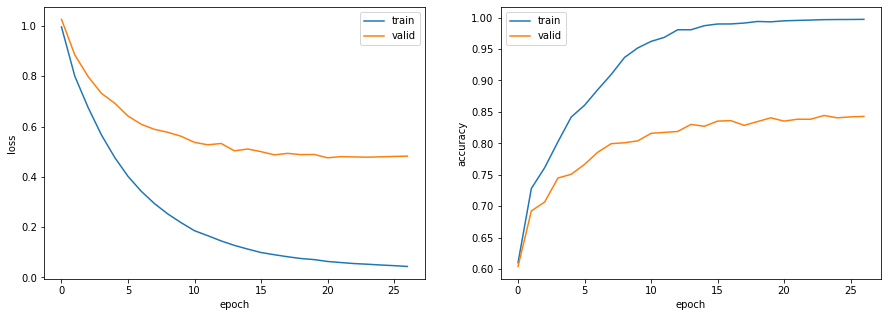

正解率（学習データ）：0.997
正解率（評価データ）：0.850


In [29]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## #89

In [16]:
#89
!pip install transformers==2.11.0

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [17]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

In [18]:
# Datasetの定義
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

In [19]:
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

# Datasetの作成
max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',truncation=False)
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

ids: tensor([  101, 10651,  1015,  1011, 11642,  4677, 19461, 15460,  6764,  2005,
        10528,  3860,   102,     0,     0,     0,     0,     0,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])
labels: tensor([1., 0., 0., 0.])


In [20]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)
    
  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask)
    out = self.fc(self.drop(out))
    return out

In [21]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model.forward(ids, mask)

      # 損失計算
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model.forward(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [22]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

epoch: 1, loss_train: 0.0861, accuracy_train: 0.9542, loss_valid: 0.1063, accuracy_valid: 0.9334, 48.0517sec
epoch: 2, loss_train: 0.0450, accuracy_train: 0.9774, loss_valid: 0.0918, accuracy_valid: 0.9379, 50.7589sec
epoch: 3, loss_train: 0.0281, accuracy_train: 0.9854, loss_valid: 0.1005, accuracy_valid: 0.9326, 50.8258sec
epoch: 4, loss_train: 0.0209, accuracy_train: 0.9887, loss_valid: 0.1045, accuracy_valid: 0.9356, 51.0184sec


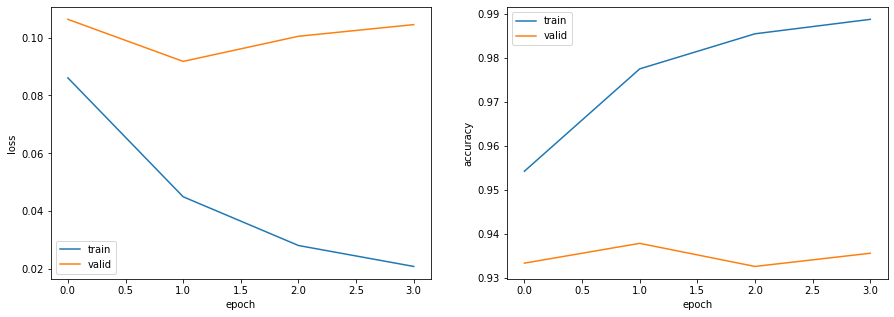

In [23]:
# ログの可視化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='train')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [27]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

device = 'cuda:2' if cuda.is_available() else 'cpu'
model.to(device)

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

正解率（学習データ）：0.989
正解率（検証データ）：0.936
正解率（評価データ）：0.942
